## Final - Wine quality classification problem
#### Chen-I Huang

## 1. Package

In [135]:
library(data.table)
library(ggplot2)
library(dplyr)
library(tidyr)
library(ggcorrplot)
library(e1071)
library(caret)
library(C50)
library(gmodels)
library(neuralnet) 
library(nnet)
library(randomForest)
library(lattice)
library(xgboost)
library(e1071)
library(party)
library(DMwR)

## 2. Read the file

In [241]:
## read the file
data <- fread('Q2_winequality-2.CSV')

In [242]:
head(data)

fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,winetype,quality
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>
7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,red,5
7.8,0.88,0.00,2.6,0.098,25,67,0.9968,3.20,0.68,9.8,red,5
7.8,0.76,0.04,2.3,0.092,15,54,0.9970,3.26,0.65,9.8,red,5
11.2,0.28,0.56,1.9,0.075,17,60,0.9980,3.16,0.58,9.8,red,6
7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,red,5
7.4,0.66,0.00,1.8,0.075,13,40,0.9978,3.51,0.56,9.4,red,5


## 3. Explor the data

In [5]:
dim(data)
#### 8 columns  541909 rows
summary(data)
str(data)

[1] 6497   13

 fixed acidity    volatile acidity  citric acid     residual sugar  
 Min.   : 3.800   Min.   :0.0800   Min.   :0.0000   Min.   : 0.600  
 1st Qu.: 6.400   1st Qu.:0.2300   1st Qu.:0.2500   1st Qu.: 1.800  
 Median : 7.000   Median :0.2900   Median :0.3100   Median : 3.000  
 Mean   : 7.215   Mean   :0.3397   Mean   :0.3186   Mean   : 5.443  
 3rd Qu.: 7.700   3rd Qu.:0.4000   3rd Qu.:0.3900   3rd Qu.: 8.100  
 Max.   :15.900   Max.   :1.5800   Max.   :1.6600   Max.   :65.800  
   chlorides       free sulfur dioxide total sulfur dioxide    density      
 Min.   :0.00900   Min.   :  1.00      Min.   :  6.0        Min.   :0.9871  
 1st Qu.:0.03800   1st Qu.: 17.00      1st Qu.: 77.0        1st Qu.:0.9923  
 Median :0.04700   Median : 29.00      Median :118.0        Median :0.9949  
 Mean   :0.05603   Mean   : 30.52      Mean   :115.7        Mean   :0.9947  
 3rd Qu.:0.06500   3rd Qu.: 41.00      3rd Qu.:156.0        3rd Qu.:0.9970  
 Max.   :0.61100   Max.   :289.00      Max.   :440.0   

Classes 'data.table' and 'data.frame':	6497 obs. of  13 variables:
 $ fixed acidity       : num  7.4 7.8 7.8 11.2 7.4 7.4 7.9 7.3 7.8 7.5 ...
 $ volatile acidity    : num  0.7 0.88 0.76 0.28 0.7 0.66 0.6 0.65 0.58 0.5 ...
 $ citric acid         : num  0 0 0.04 0.56 0 0 0.06 0 0.02 0.36 ...
 $ residual sugar      : num  1.9 2.6 2.3 1.9 1.9 1.8 1.6 1.2 2 6.1 ...
 $ chlorides           : num  0.076 0.098 0.092 0.075 0.076 0.075 0.069 0.065 0.073 0.071 ...
 $ free sulfur dioxide : int  11 25 15 17 11 13 15 15 9 17 ...
 $ total sulfur dioxide: int  34 67 54 60 34 40 59 21 18 102 ...
 $ density             : num  0.998 0.997 0.997 0.998 0.998 ...
 $ pH                  : num  3.51 3.2 3.26 3.16 3.51 3.51 3.3 3.39 3.36 3.35 ...
 $ sulphates           : num  0.56 0.68 0.65 0.58 0.56 0.56 0.46 0.47 0.57 0.8 ...
 $ alcohol             : num  9.4 9.8 9.8 9.8 9.4 9.4 9.4 10 9.5 10.5 ...
 $ winetype            : chr  "red" "red" "red" "red" ...
 $ quality             : int  5 5 5 6 5 5 5 7 7 5 ...


In [243]:
## check missing value
sum(is.na(data))
#### no missing value

[1] 0

#### duplicate

In [244]:
## check duplicate
sum(duplicated(data))
#### 1177 duplicated data
#### remove it
data <- data[!duplicated(data), ]
sum(duplicated(data))

[1] 1177

[1] 0

#### count of quality

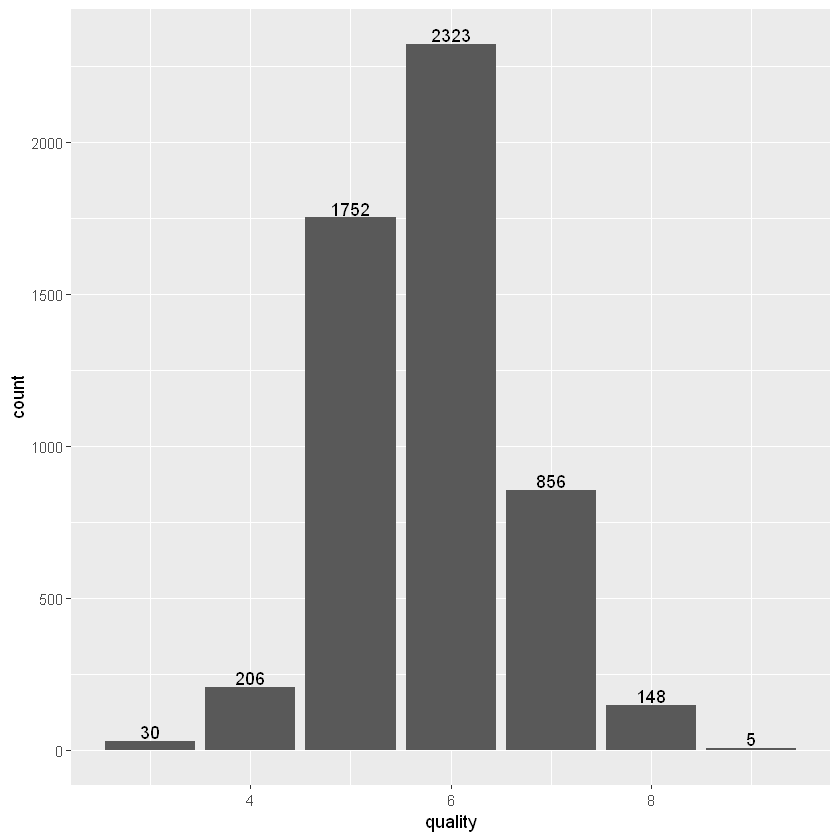

In [8]:
quality <- group_by(data, quality)
quality <- summarise(quality, count=n())
ggplot(data = quality,aes(x=quality, y=count)) + geom_bar(stat="identity")+ geom_text(aes(label=count), vjust=-0.2)
## we can see the distribution of quality are not equal, mostly are 5 and 6

#### coorelation

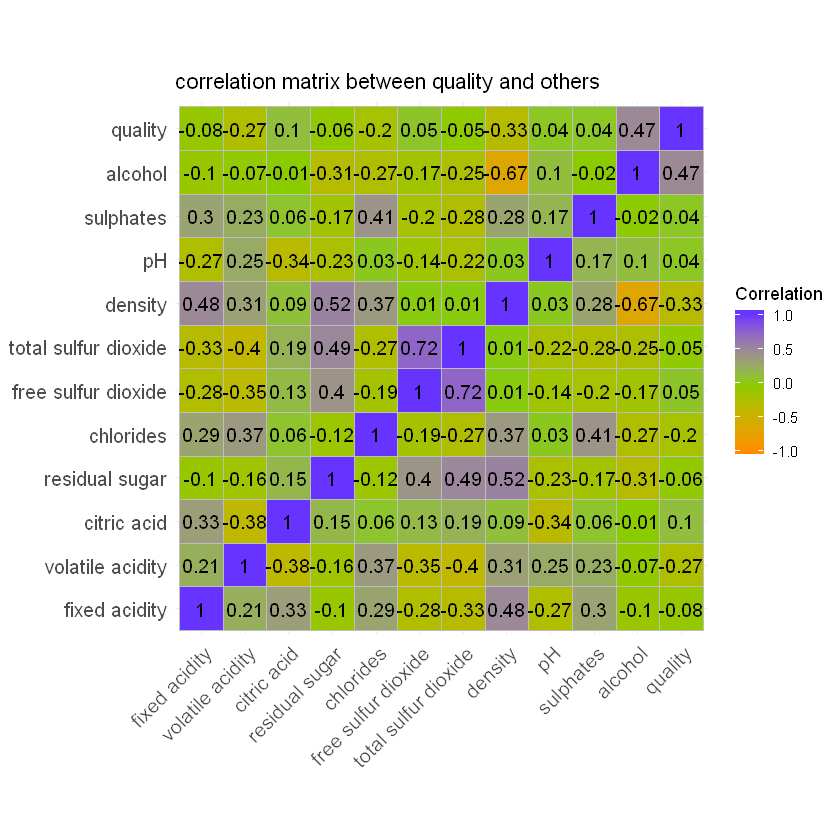

In [9]:
## coorelation (don't check the winetype)
cor(data[,-12])%>%
ggcorrplot(lab = TRUE,
colors = colorRampPalette(c("darkorange","#88CC00","#6633FF"))(3),
title = "correlation matrix between quality and others",
legend.title = "Correlation")
## alcohle has more coorelation with quality

#### group by quility

In [12]:
## group by quility
quality <- group_by(data, quality)
quality <- summarise(quality, fixed_acidity = mean(`fixed acidity`), volatile_acidity = mean(`volatile acidity`),
                     citric_acid = mean(`citric acid`), residual_sugar = mean(`residual sugar`),
                     chlorides = mean(chlorides), free_sulfur_dioxide = mean(`free sulfur dioxide`),
                     total_sulfur_dioxide = mean(`total sulfur dioxide`), density = mean(density),
                     pH = mean(pH), sulphates = mean(sulphates), sulphates = mean(sulphates))
quality
#### the mean of these 10 columns for all quality are pretty close
#### it will be hard to classify them

quality,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3,7.853333,0.5170000,0.2810000,5.140000,0.07703333,39.16667,122.0000,0.9957440,3.257667,0.5063333
4,7.304369,0.4623786,0.2715049,4.034951,0.06050971,20.32524,101.5146,0.9948016,3.235874,0.5074757
5,7.333248,0.3939697,0.3058447,5.481906,0.06603881,29.79395,119.5708,0.9957342,3.214275,0.5290411
6,7.169027,0.3156263,0.3246707,5.153142,0.05436634,30.77400,114.4318,0.9943771,3.224120,0.5343134
7,7.122021,0.2923423,0.3360397,4.171320,0.04521846,29.97196,105.1554,0.9928381,3.240479,0.5496379
8,6.820270,0.3029730,0.3405405,4.771622,0.04038514,33.10811,111.9730,0.9921299,3.239595,0.5190541
9,7.420000,0.2980000,0.3860000,4.120000,0.02740000,33.40000,116.0000,0.9914600,3.308000,0.4660000


#### scatter plot

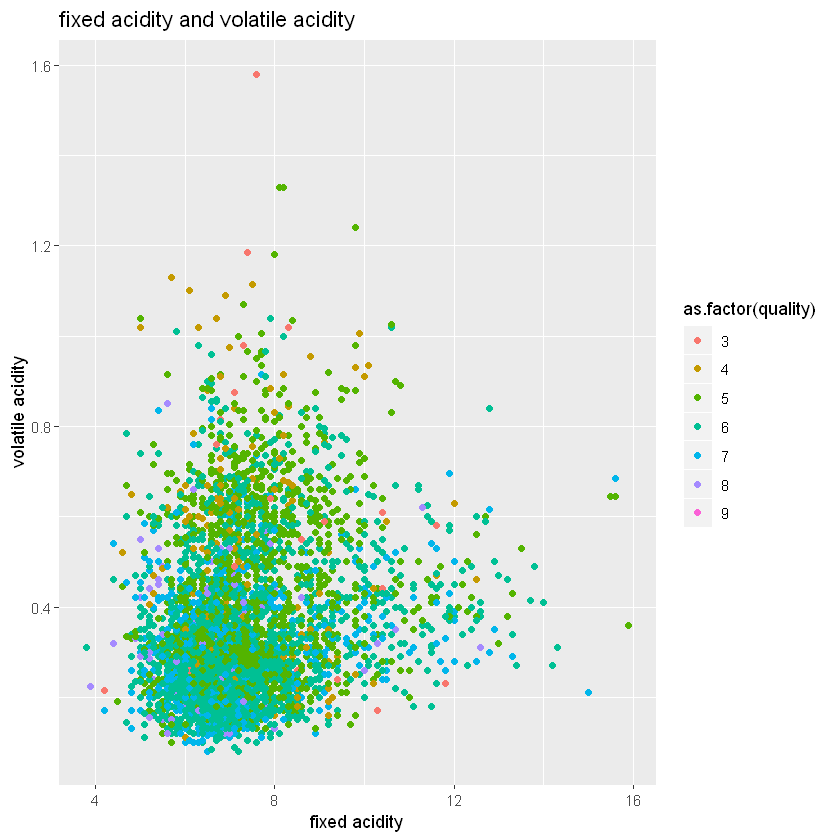

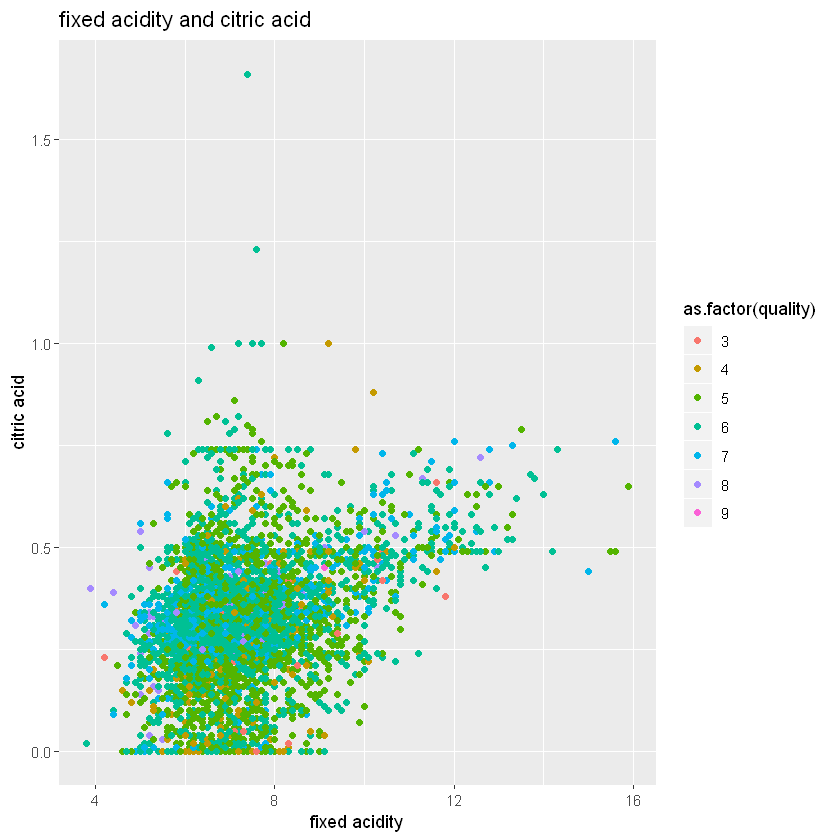

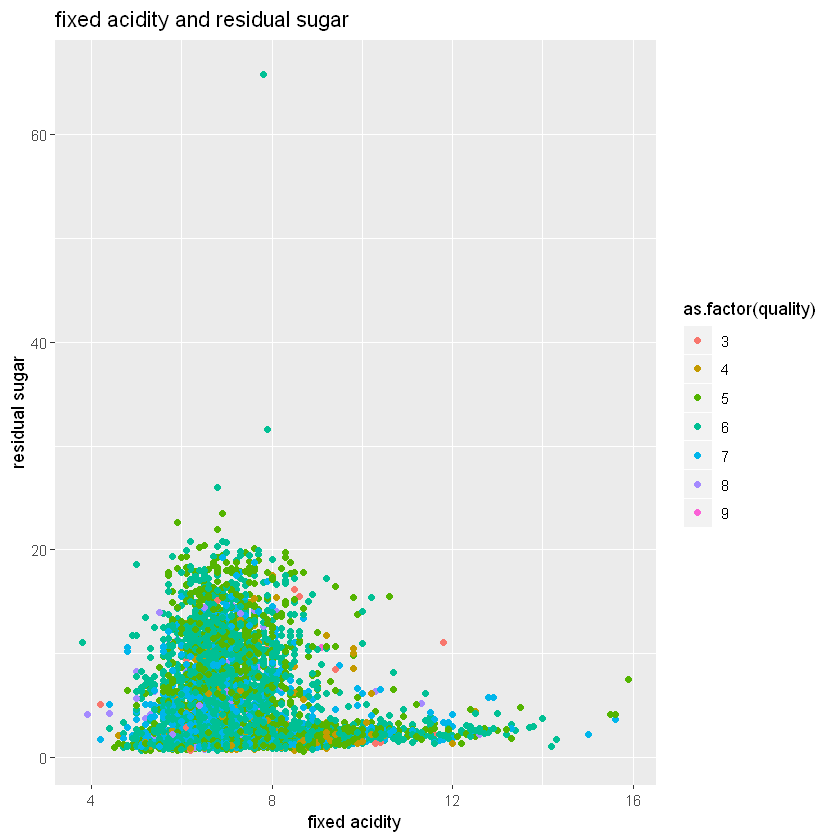

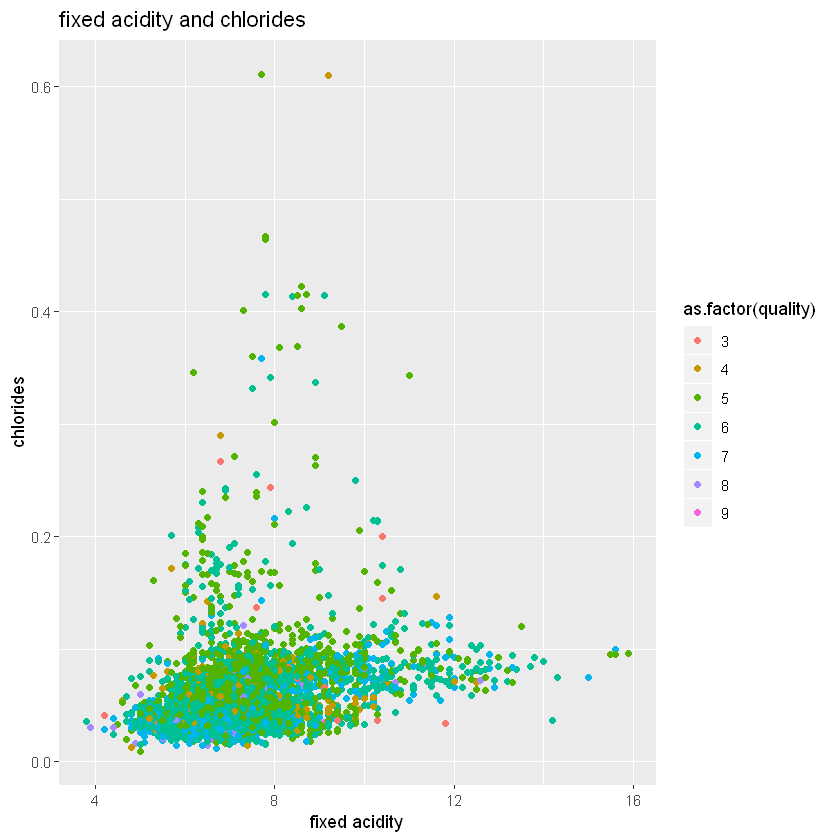

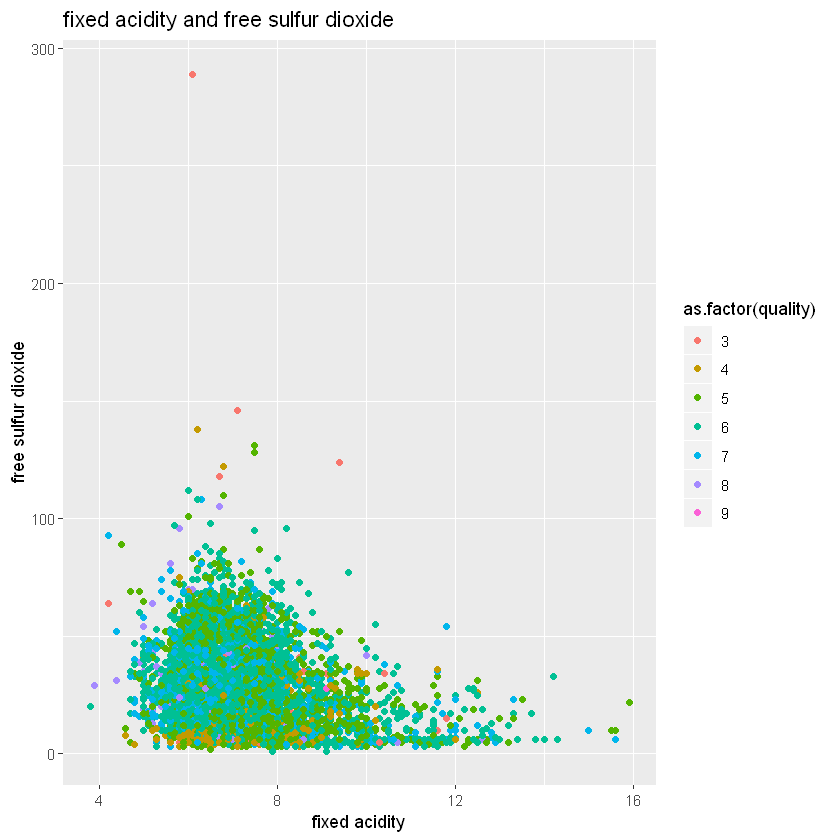

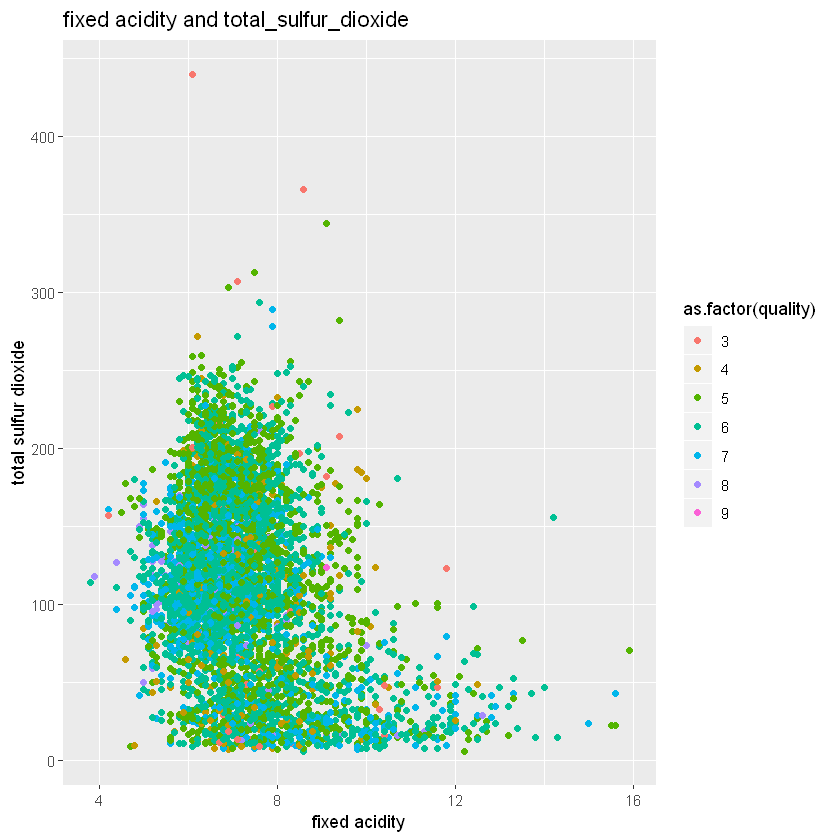

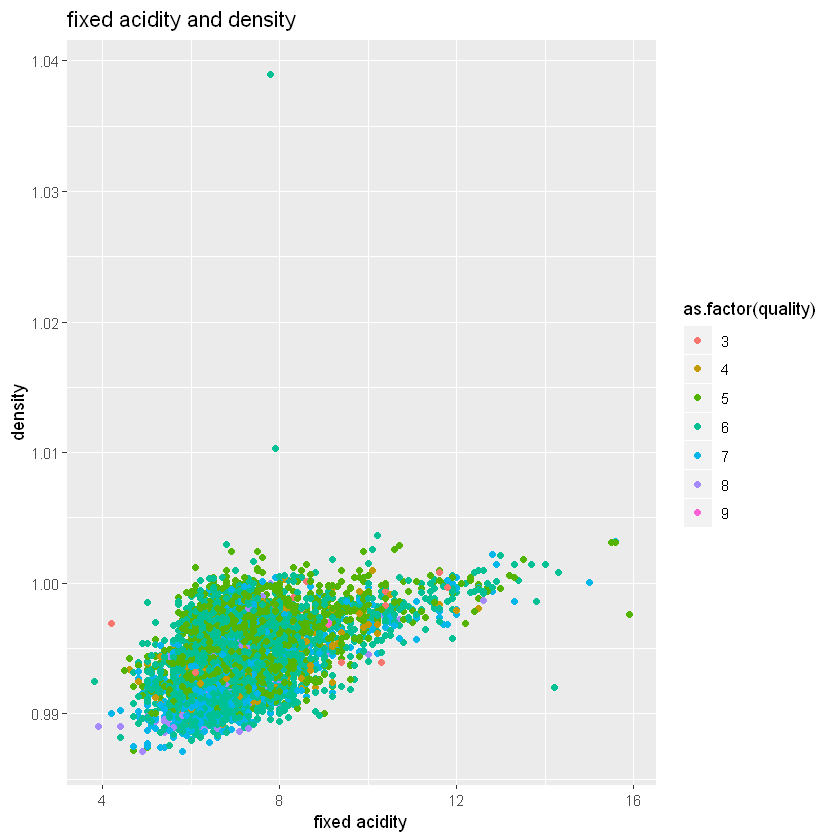

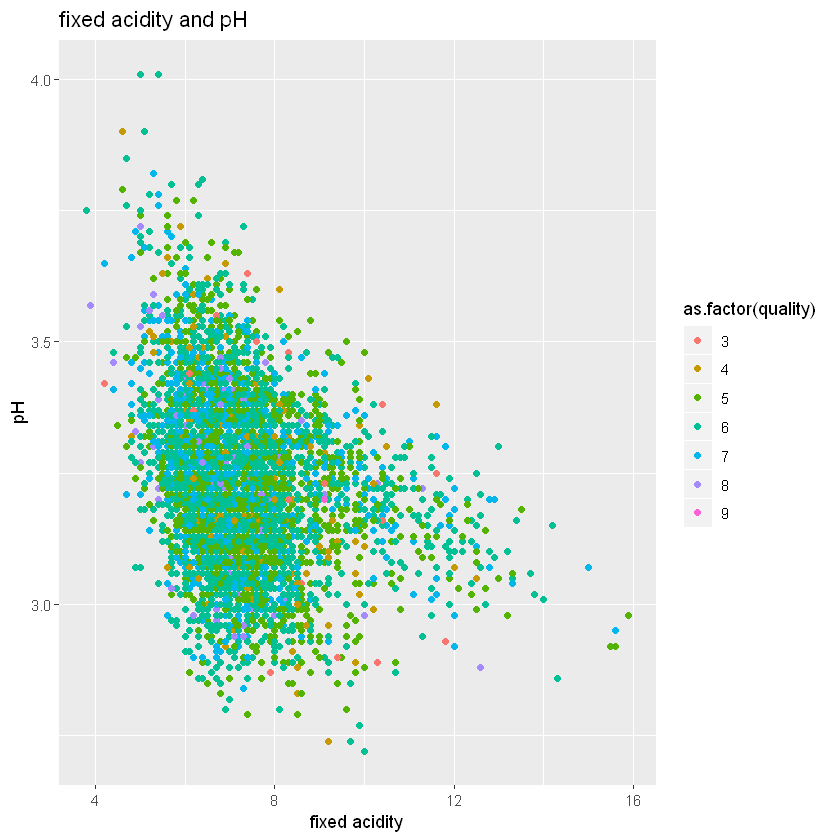

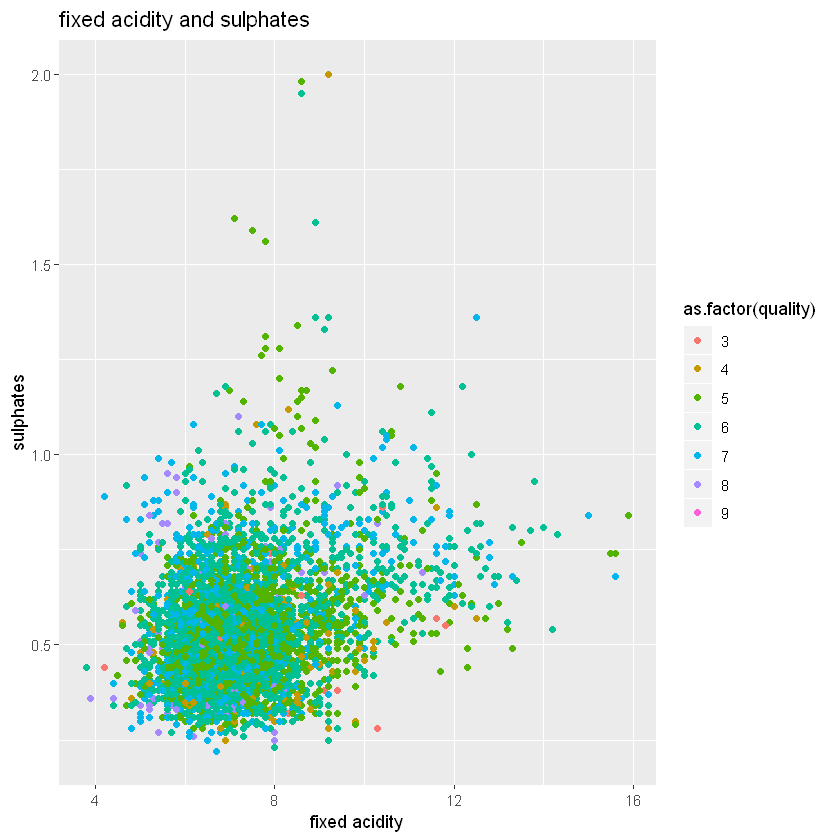

In [24]:
## scatter plot fixed acidity and others
ggplot(data, aes(x =`fixed acidity`, y =`volatile acidity`, color = as.factor(quality)))+ geom_point() + labs(title="fixed acidity and volatile acidity")
ggplot(data, aes(x =`fixed acidity`, y =`citric acid`, color = as.factor(quality)))+ geom_point() + labs(title="fixed acidity and citric acid")
ggplot(data, aes(x =`fixed acidity`, y =`residual sugar`, color = as.factor(quality)))+ geom_point() + labs(title="fixed acidity and residual sugar")
ggplot(data, aes(x =`fixed acidity`, y =chlorides, color = as.factor(quality)))+ geom_point() + labs(title="fixed acidity and chlorides")
ggplot(data, aes(x =`fixed acidity`, y =`free sulfur dioxide`, color = as.factor(quality)))+ geom_point() + labs(title="fixed acidity and free sulfur dioxide")
ggplot(data, aes(x =`fixed acidity`, y =`total sulfur dioxide`, color = as.factor(quality)))+ geom_point() + labs(title="fixed acidity and total_sulfur_dioxide")
ggplot(data, aes(x =`fixed acidity`, y =density, color = as.factor(quality)))+ geom_point() + labs(title="fixed acidity and density")
ggplot(data, aes(x =`fixed acidity`, y =pH, color = as.factor(quality)))+ geom_point() + labs(title="fixed acidity and pH")
ggplot(data, aes(x =`fixed acidity`, y =sulphates, color = as.factor(quality)))+ geom_point() + labs(title="fixed acidity and sulphates")

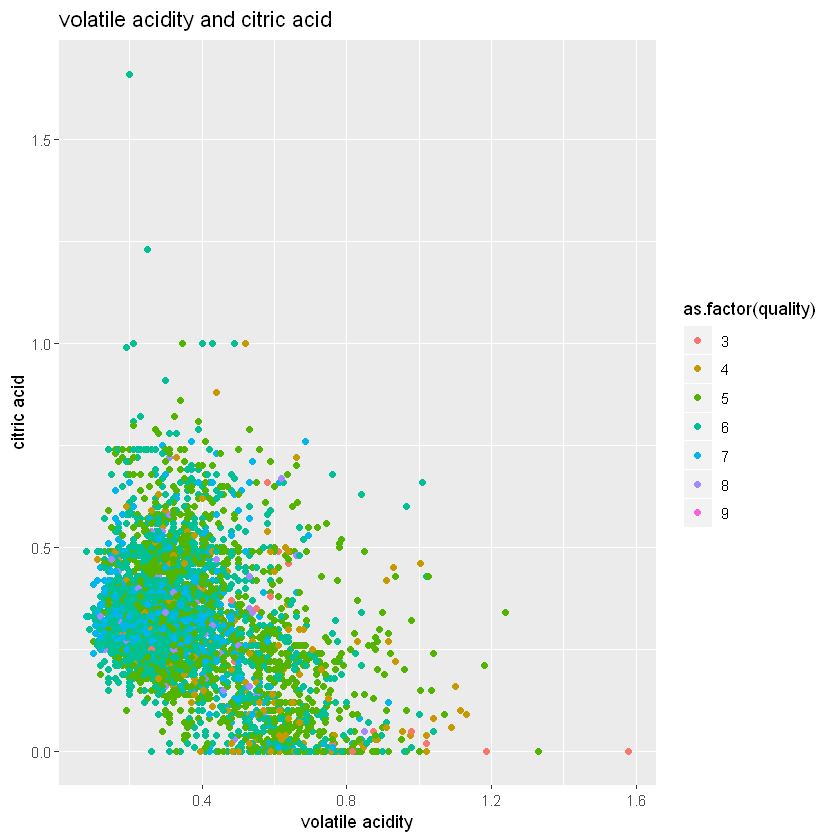

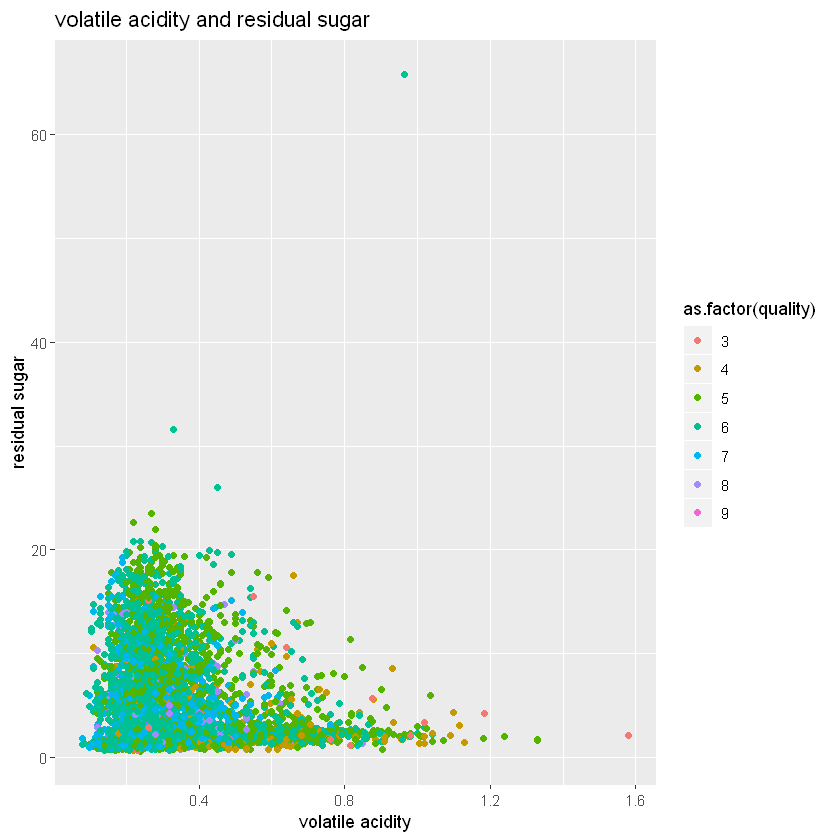

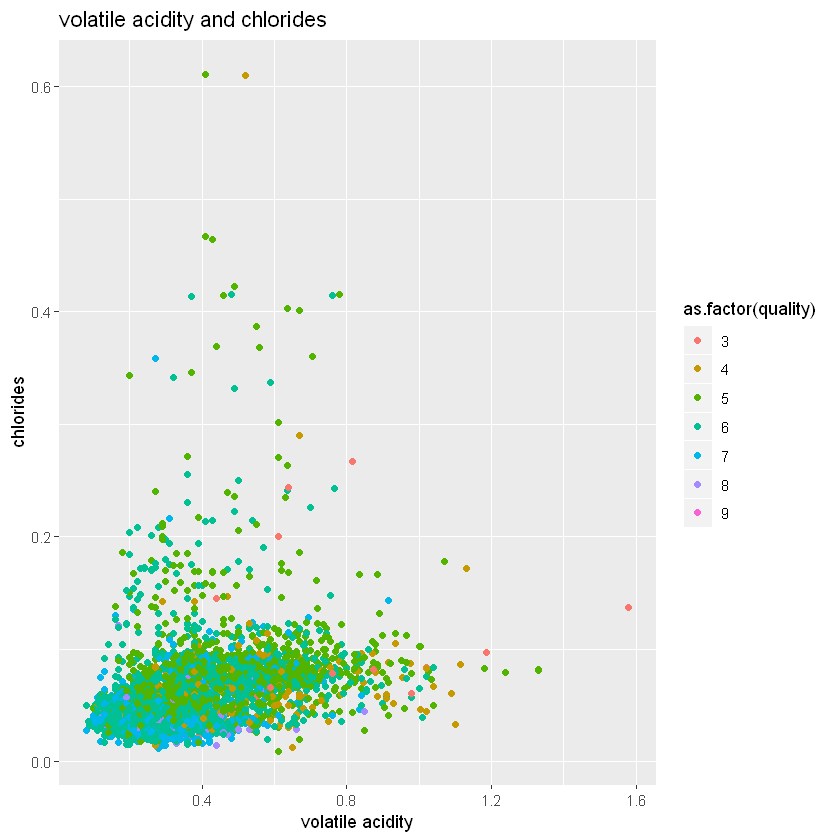

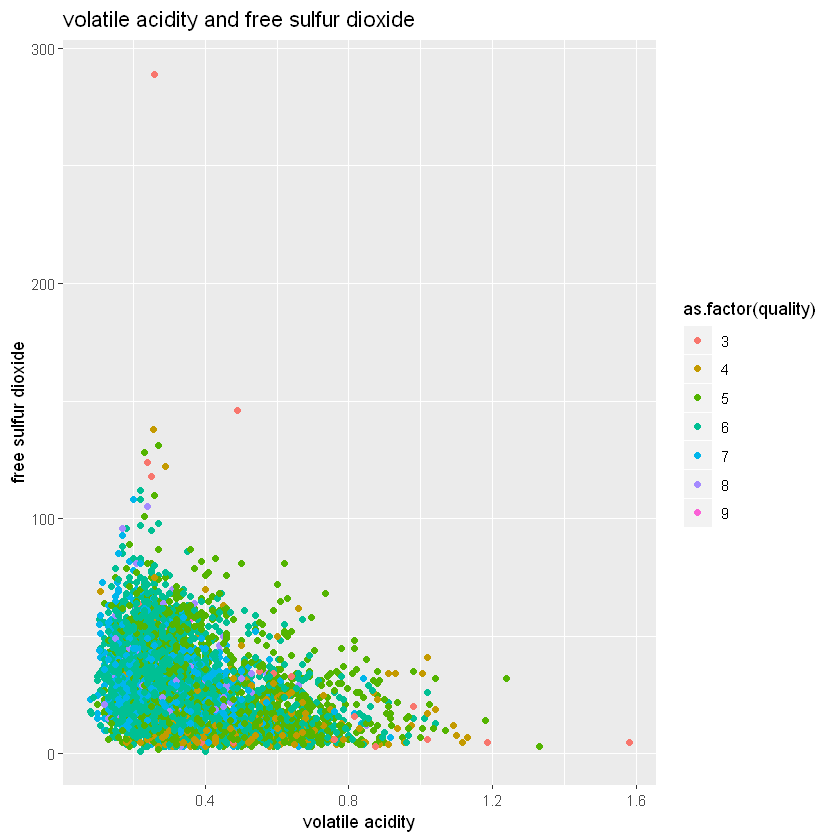

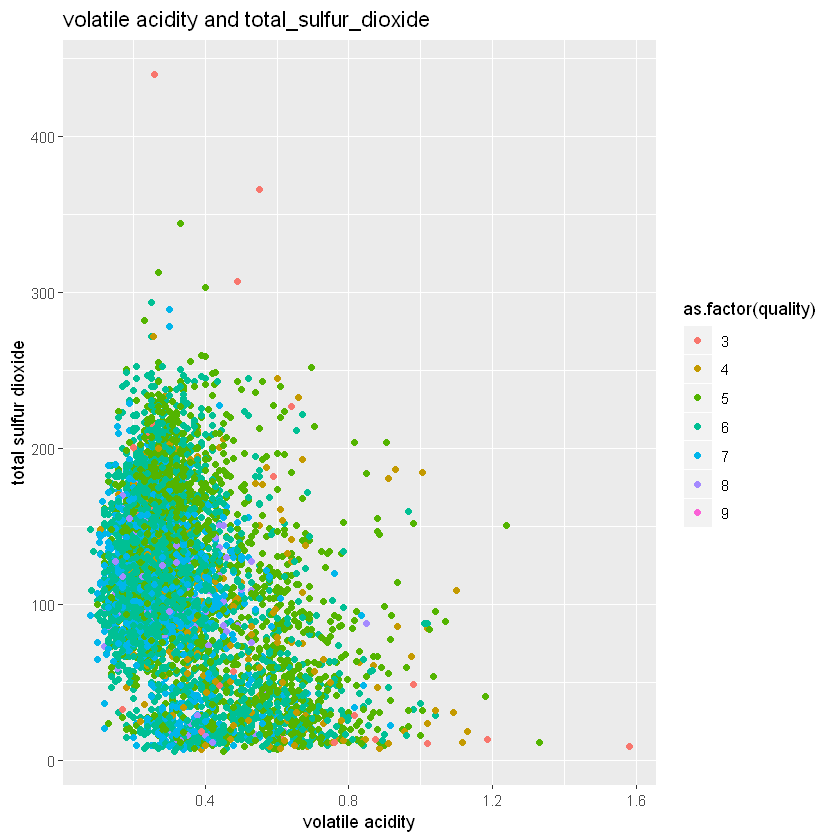

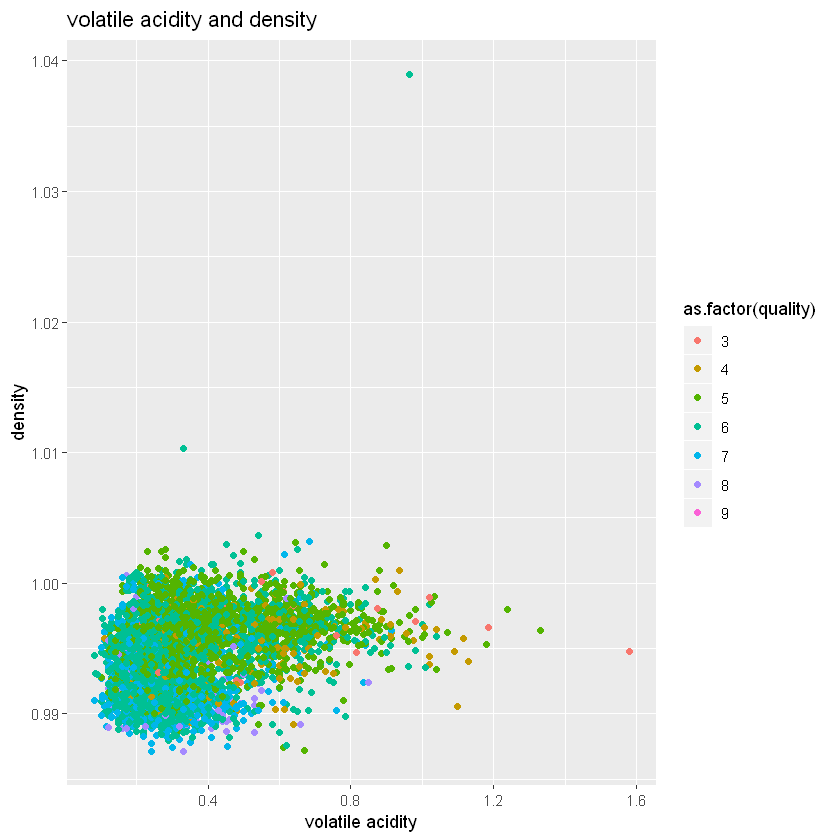

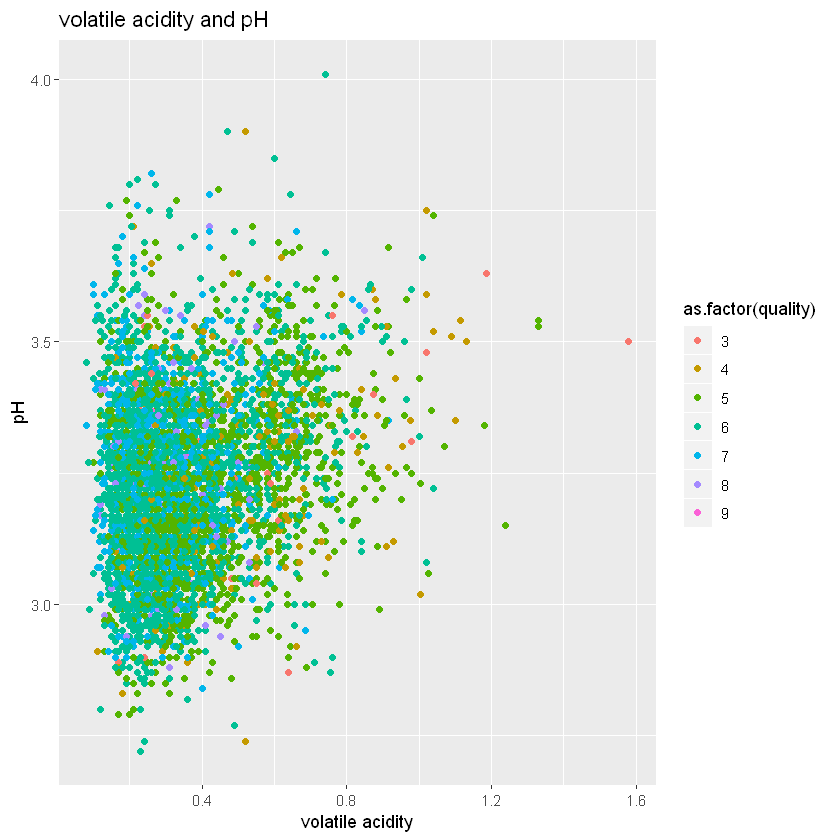

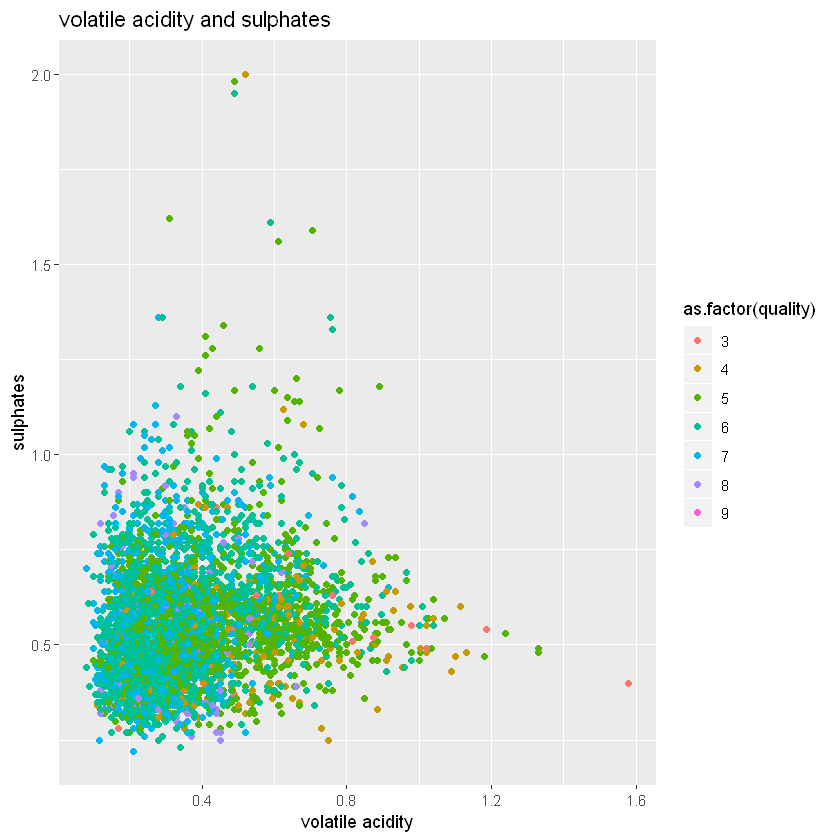

In [25]:
## scatter plot volatile acidity and others
ggplot(data, aes(x =`volatile acidity`, y =`citric acid`, color = as.factor(quality)))+ geom_point() + labs(title="volatile acidity and citric acid")
ggplot(data, aes(x =`volatile acidity`, y =`residual sugar`, color = as.factor(quality)))+ geom_point() + labs(title="volatile acidity and residual sugar")
ggplot(data, aes(x =`volatile acidity`, y =chlorides, color = as.factor(quality)))+ geom_point() + labs(title="volatile acidity and chlorides")
ggplot(data, aes(x =`volatile acidity`, y =`free sulfur dioxide`, color = as.factor(quality)))+ geom_point() + labs(title="volatile acidity and free sulfur dioxide")
ggplot(data, aes(x =`volatile acidity`, y =`total sulfur dioxide`, color = as.factor(quality)))+ geom_point() + labs(title="volatile acidity and total_sulfur_dioxide")
ggplot(data, aes(x =`volatile acidity`, y =density, color = as.factor(quality)))+ geom_point() + labs(title="volatile acidity and density")
ggplot(data, aes(x =`volatile acidity`, y =pH, color = as.factor(quality)))+ geom_point() + labs(title="volatile acidity and pH")
ggplot(data, aes(x =`volatile acidity`, y =sulphates, color = as.factor(quality)))+ geom_point() + labs(title="volatile acidity and sulphates")

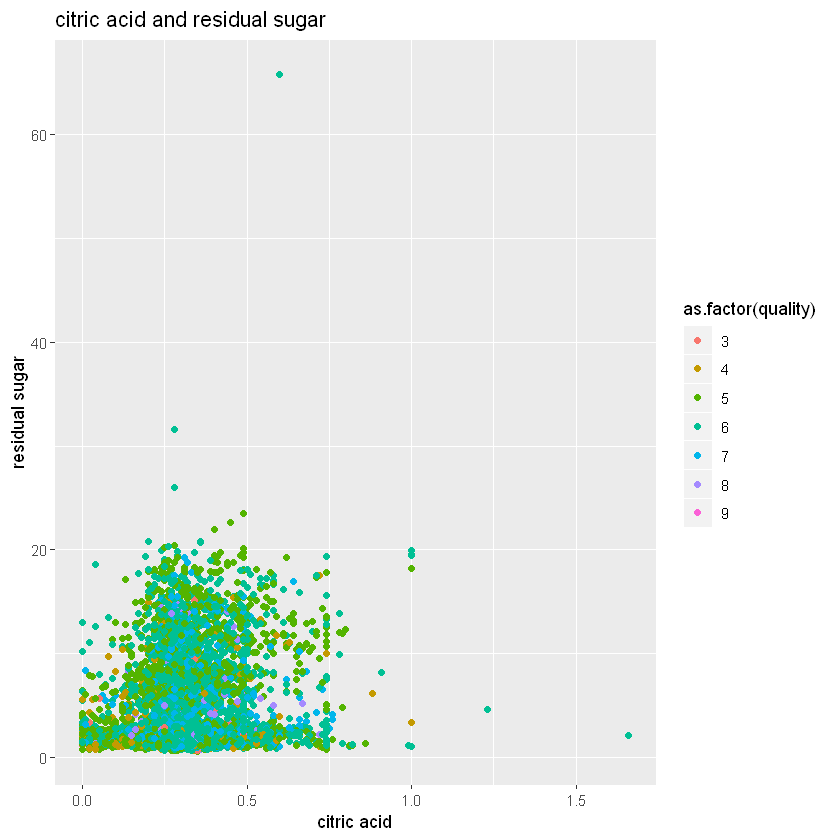

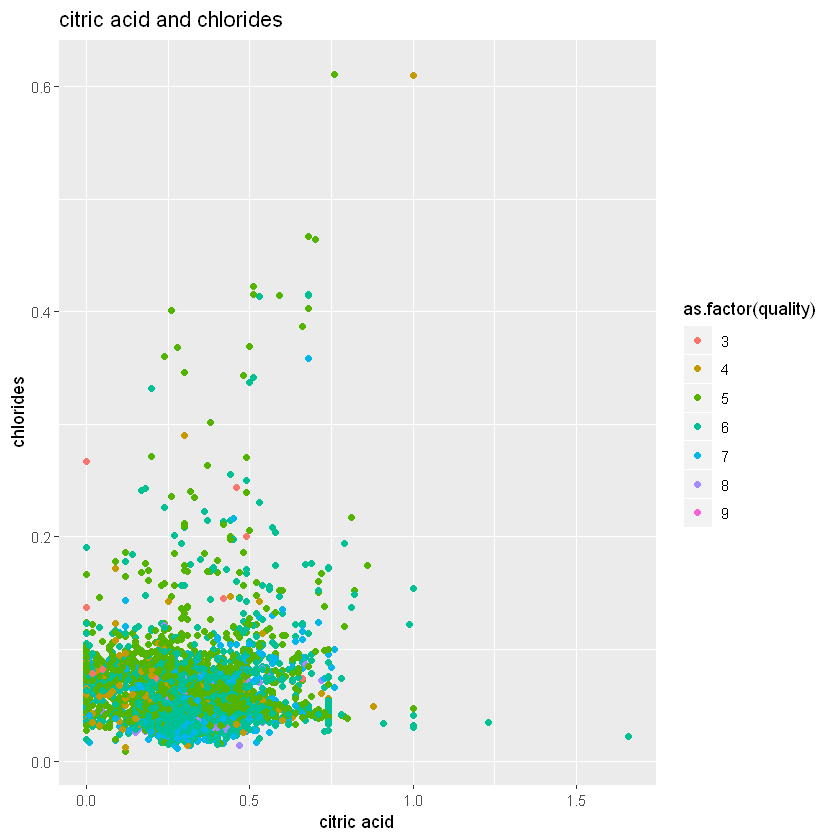

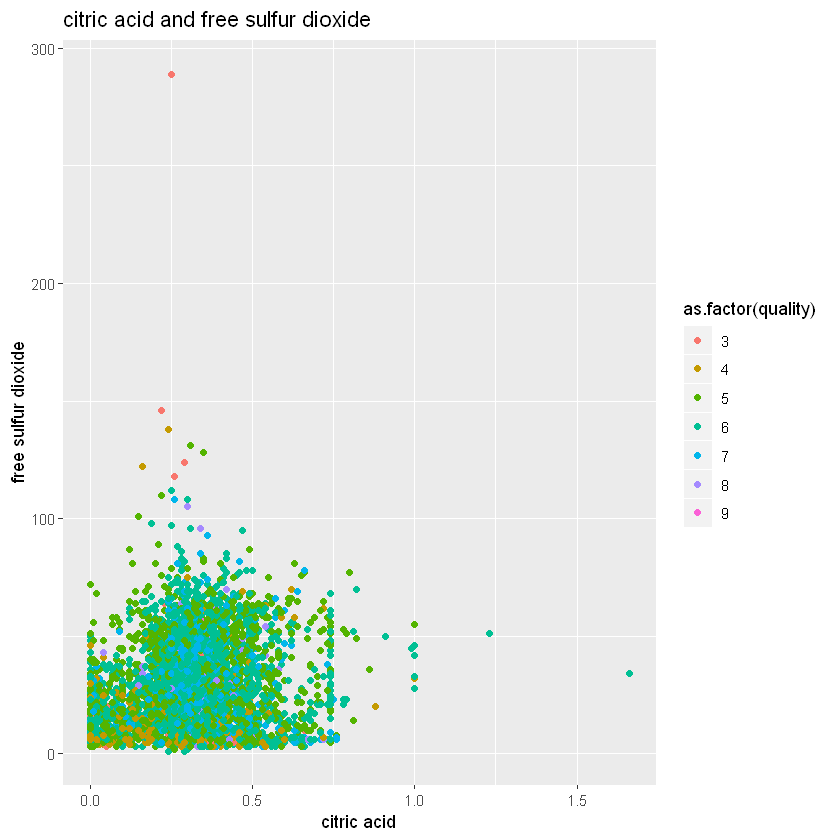

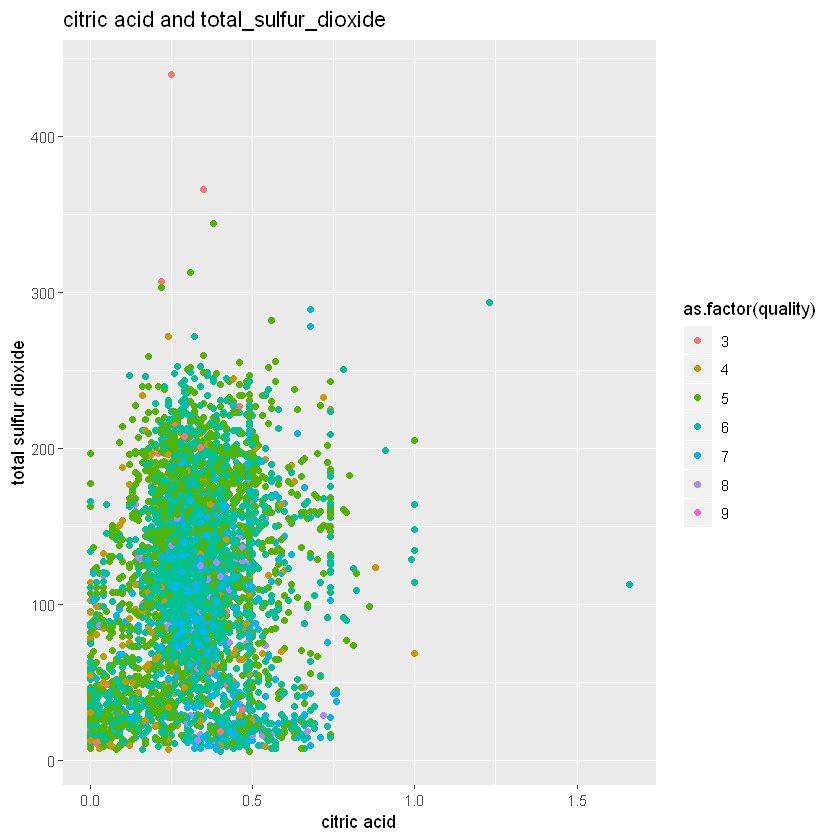

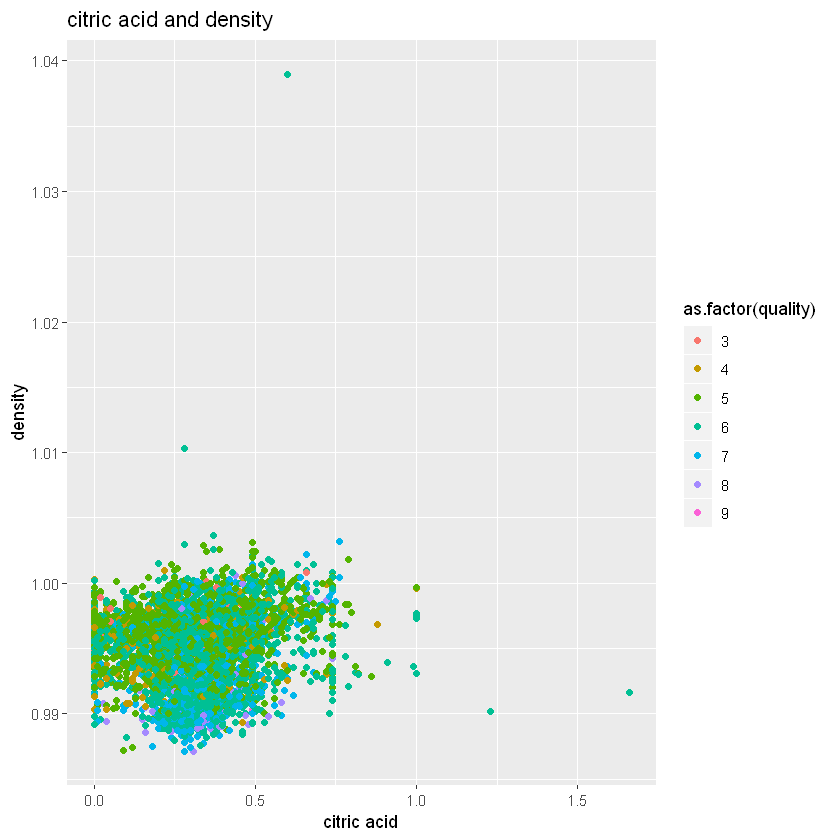

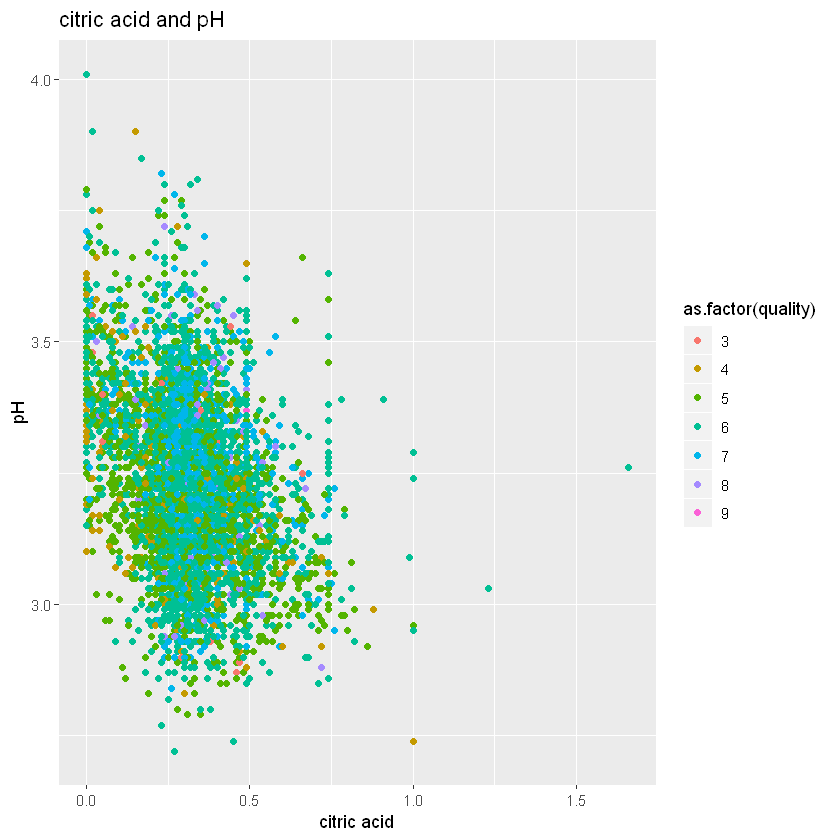

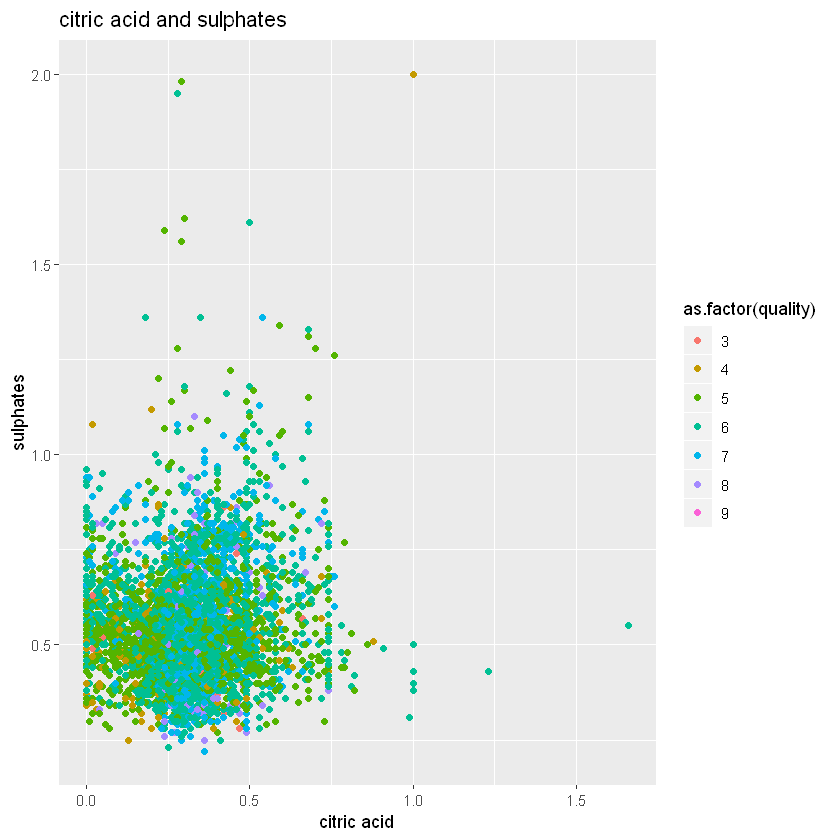

In [26]:
## scatter plot citric acid and others
ggplot(data, aes(x =`citric acid`, y =`residual sugar`, color = as.factor(quality)))+ geom_point() + labs(title="citric acid and residual sugar")
ggplot(data, aes(x =`citric acid`, y =chlorides, color = as.factor(quality)))+ geom_point() + labs(title="citric acid and chlorides")
ggplot(data, aes(x =`citric acid`, y =`free sulfur dioxide`, color = as.factor(quality)))+ geom_point() + labs(title="citric acid and free sulfur dioxide")
ggplot(data, aes(x =`citric acid`, y =`total sulfur dioxide`, color = as.factor(quality)))+ geom_point() + labs(title="citric acid and total_sulfur_dioxide")
ggplot(data, aes(x =`citric acid`, y =density, color = as.factor(quality)))+ geom_point() + labs(title="citric acid and density")
ggplot(data, aes(x =`citric acid`, y =pH, color = as.factor(quality)))+ geom_point() + labs(title="citric acid and pH")
ggplot(data, aes(x =`citric acid`, y =sulphates, color = as.factor(quality)))+ geom_point() + labs(title="citric acid and sulphates")

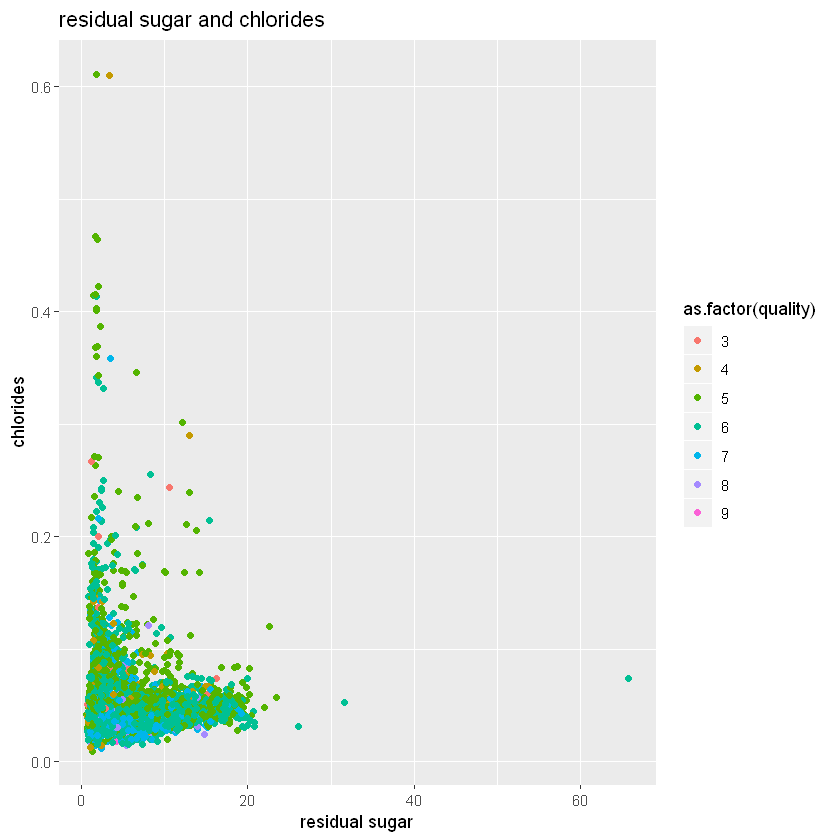

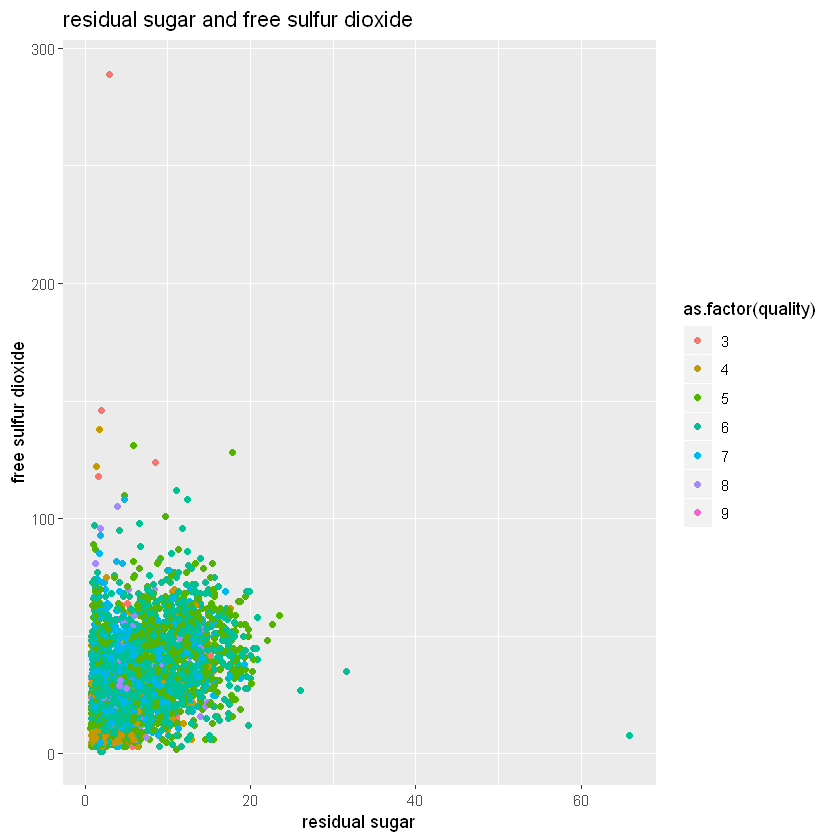

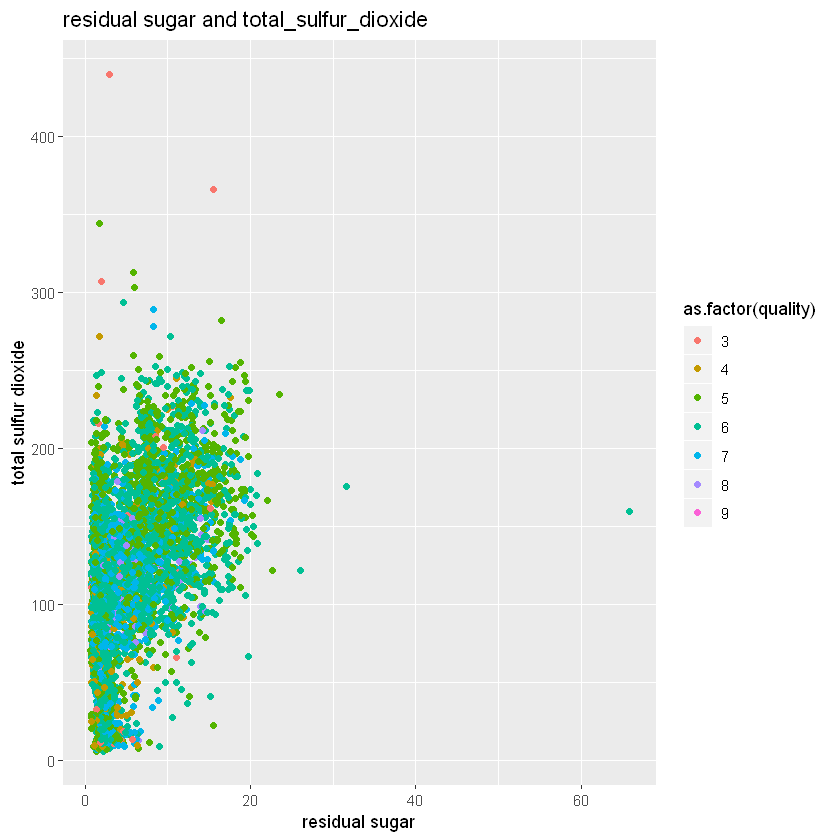

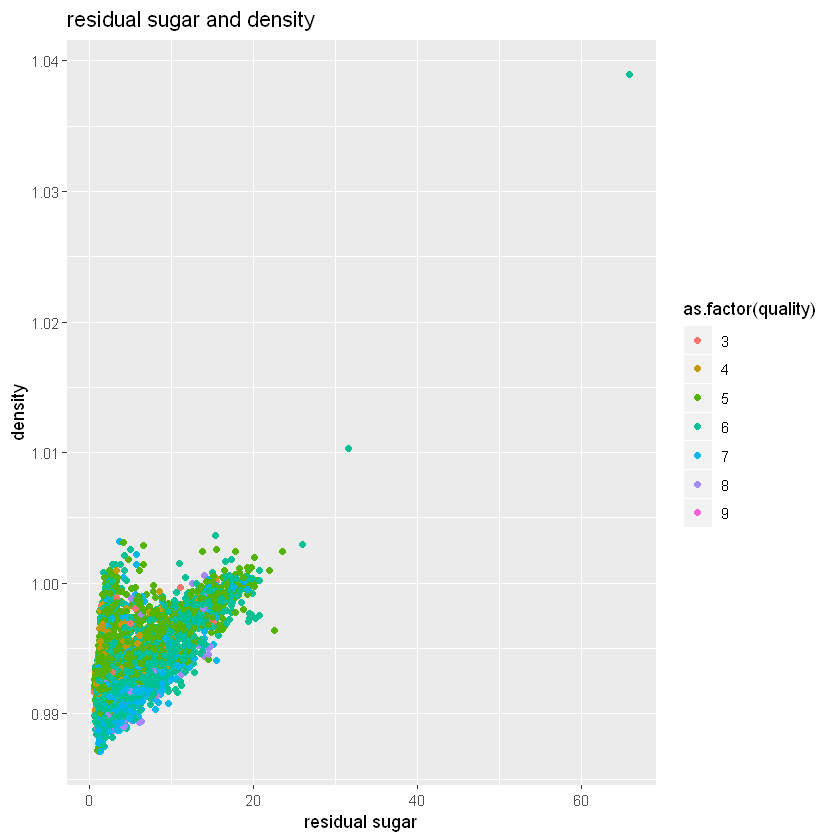

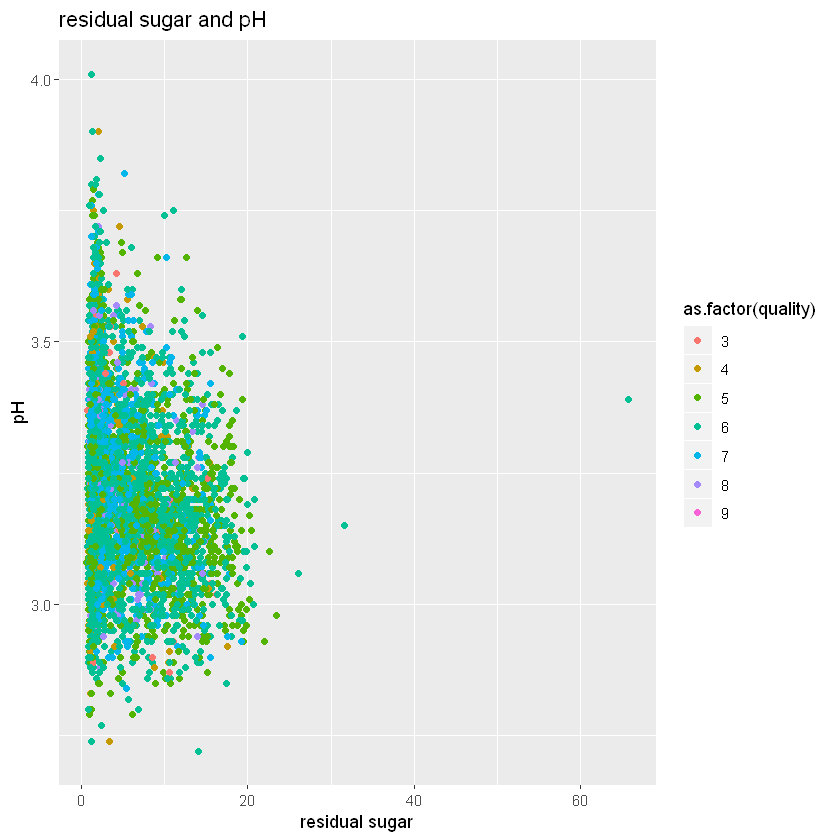

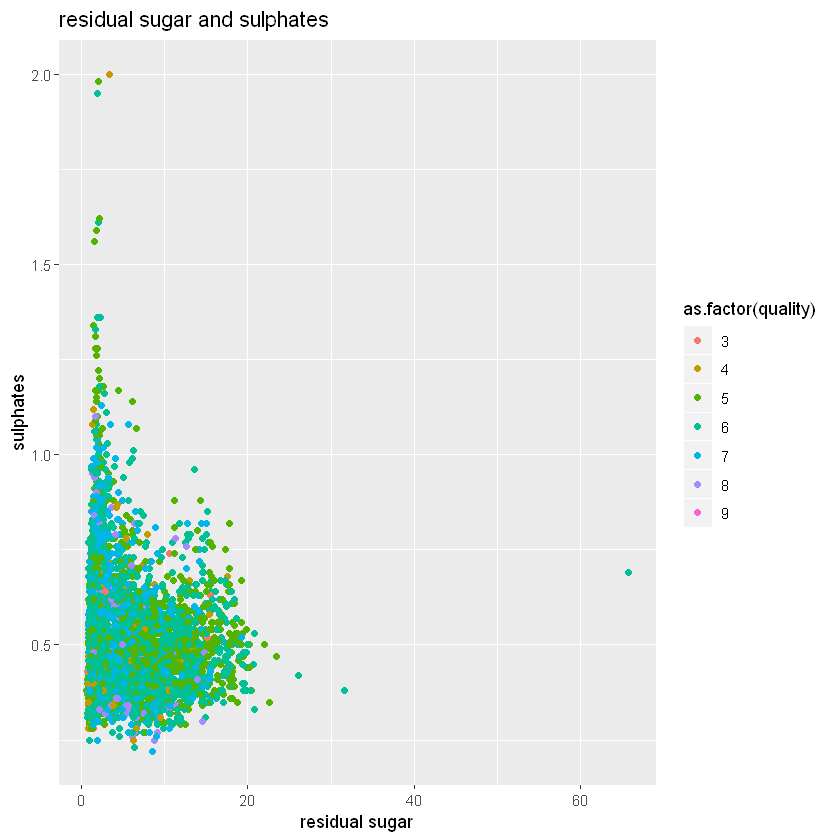

In [27]:
## scatter plot residual sugar acid and others
ggplot(data, aes(x =`residual sugar`, y =chlorides, color = as.factor(quality)))+ geom_point() + labs(title="residual sugar and chlorides")
ggplot(data, aes(x =`residual sugar`, y =`free sulfur dioxide`, color = as.factor(quality)))+ geom_point() + labs(title="residual sugar and free sulfur dioxide")
ggplot(data, aes(x =`residual sugar`, y =`total sulfur dioxide`, color = as.factor(quality)))+ geom_point() + labs(title="residual sugar and total_sulfur_dioxide")
ggplot(data, aes(x =`residual sugar`, y =density, color = as.factor(quality)))+ geom_point() + labs(title="residual sugar and density")
ggplot(data, aes(x =`residual sugar`, y =pH, color = as.factor(quality)))+ geom_point() + labs(title="residual sugar and pH")
ggplot(data, aes(x =`residual sugar`, y =sulphates, color = as.factor(quality)))+ geom_point() + labs(title="residual sugar and sulphates")

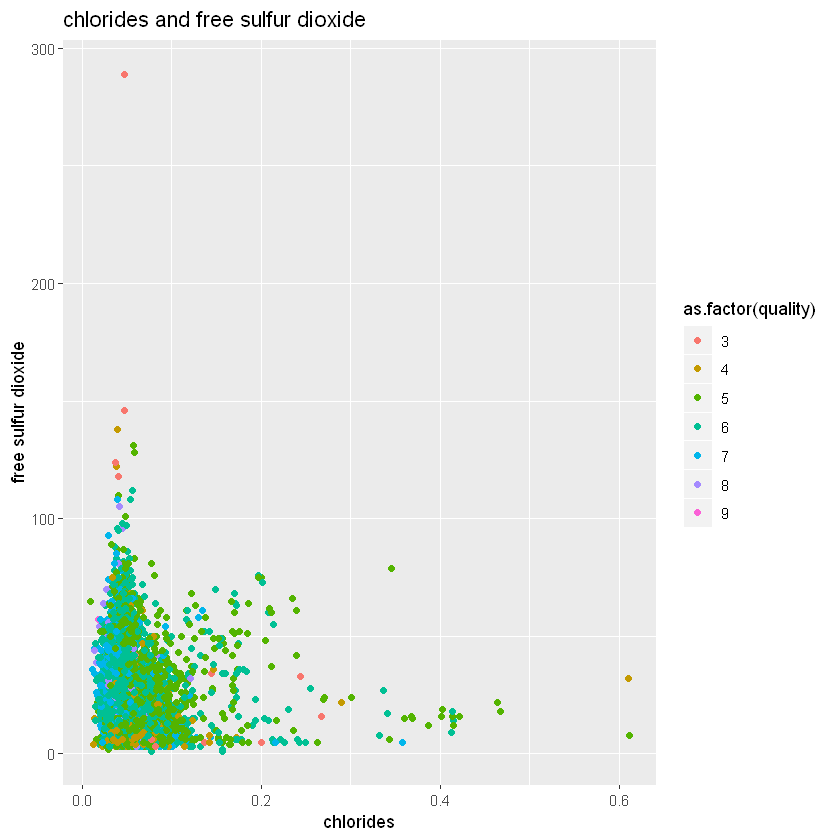

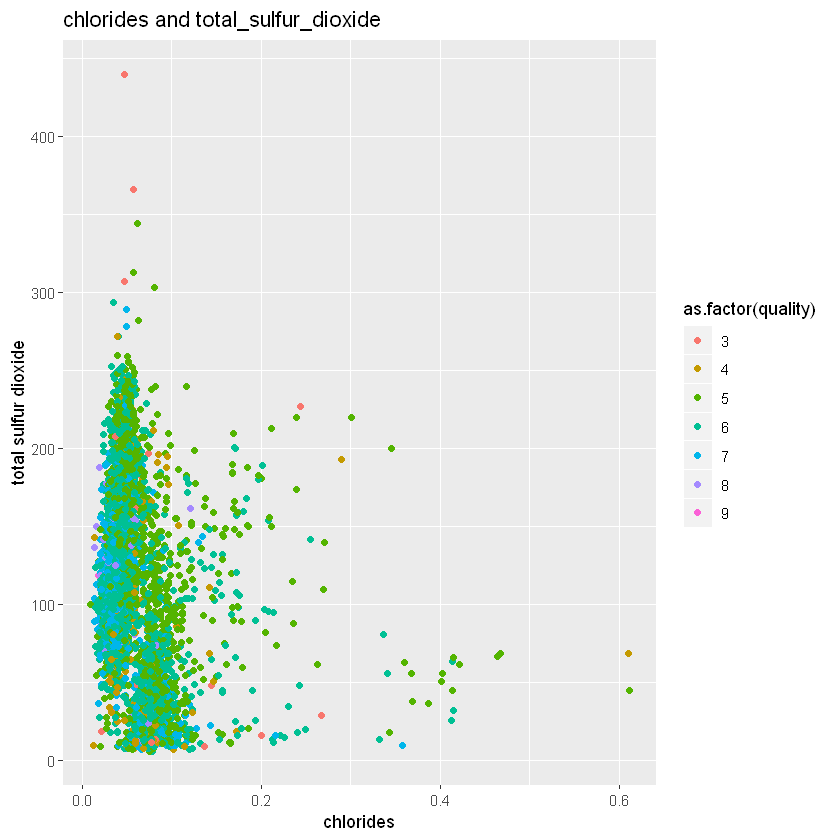

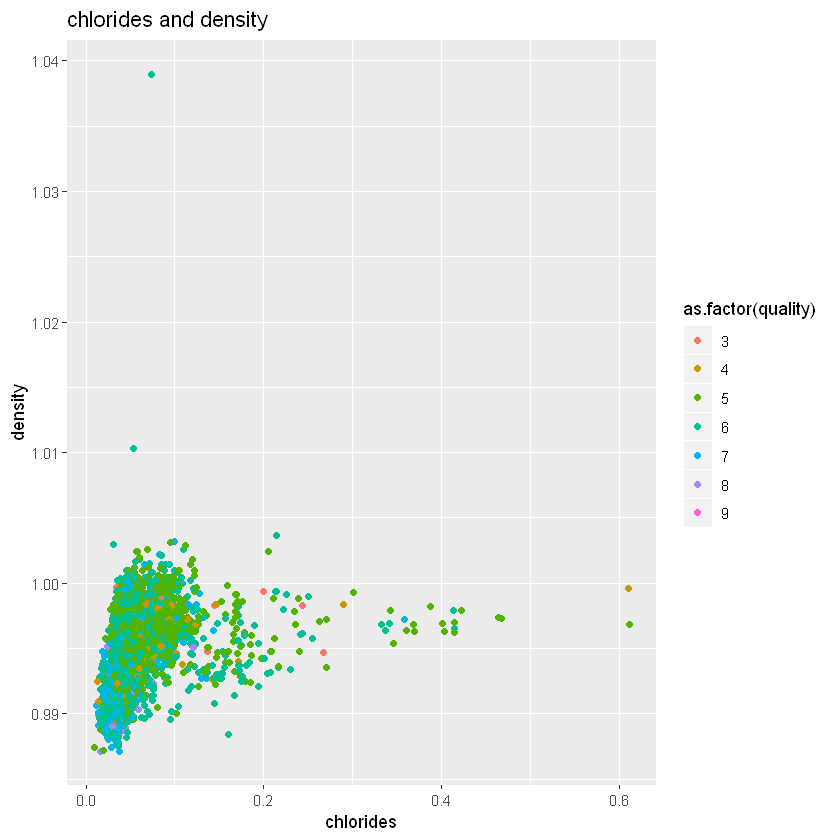

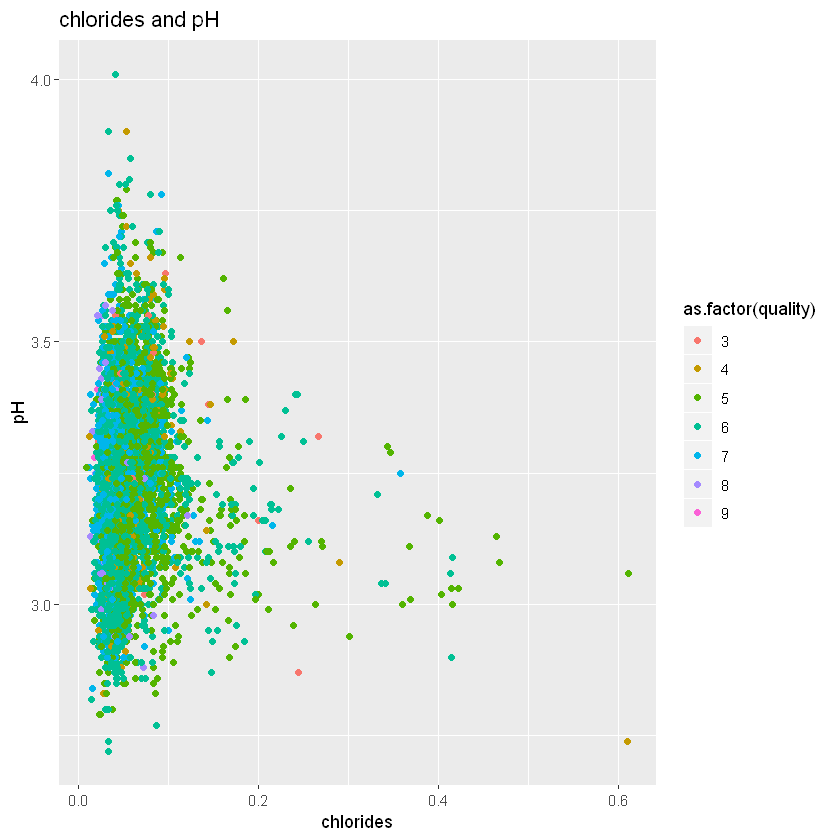

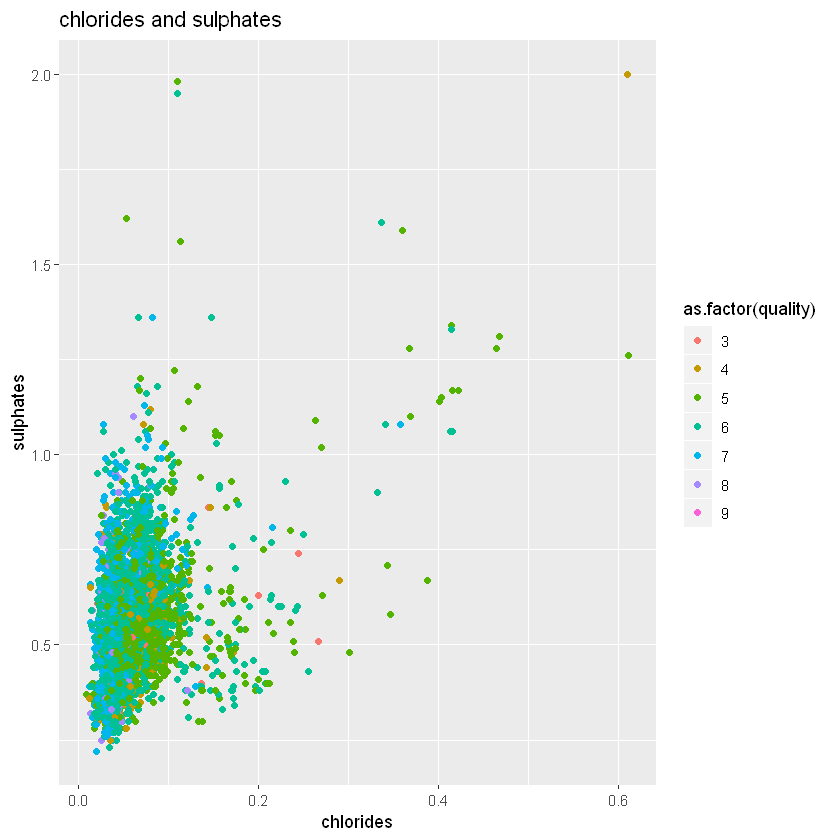

In [42]:
## scatter plot chlorides and others
ggplot(data, aes(x =chlorides, y =`free sulfur dioxide`, color = as.factor(quality)))+ geom_point() + labs(title="chlorides and free sulfur dioxide")
ggplot(data, aes(x =chlorides, y =`total sulfur dioxide`, color = as.factor(quality)))+ geom_point() + labs(title="chlorides and total_sulfur_dioxide")
ggplot(data, aes(x =chlorides, y =density, color = as.factor(quality)))+ geom_point() + labs(title="chlorides and density")
ggplot(data, aes(x =chlorides, y =pH, color = as.factor(quality)))+ geom_point() + labs(title="chlorides and pH")
ggplot(data, aes(x =chlorides, y =sulphates, color = as.factor(quality)))+ geom_point() + labs(title="chlorides and sulphates")

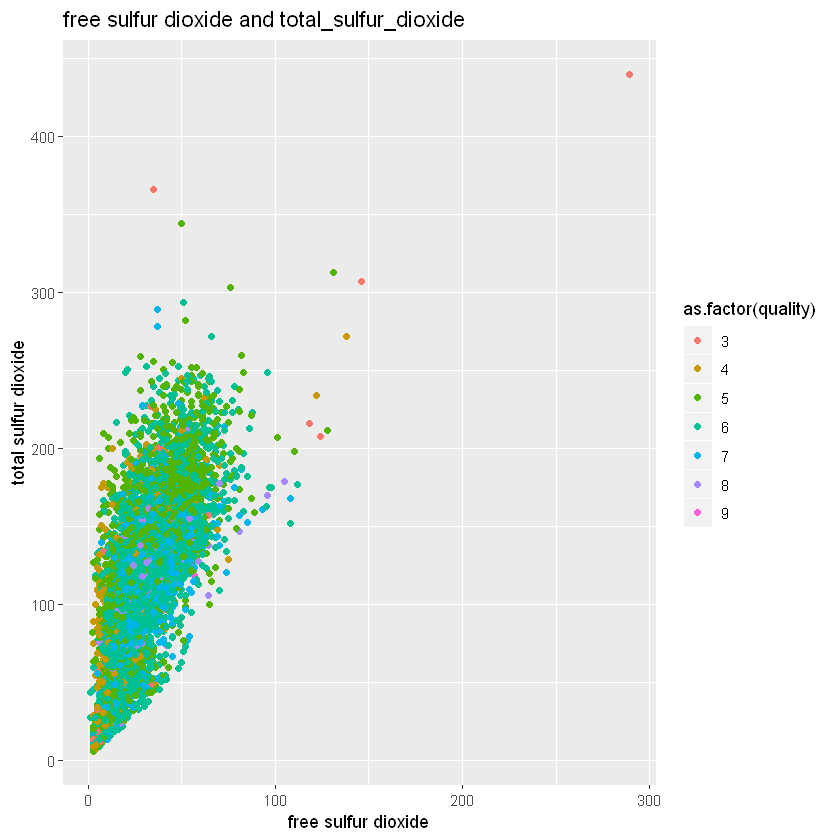

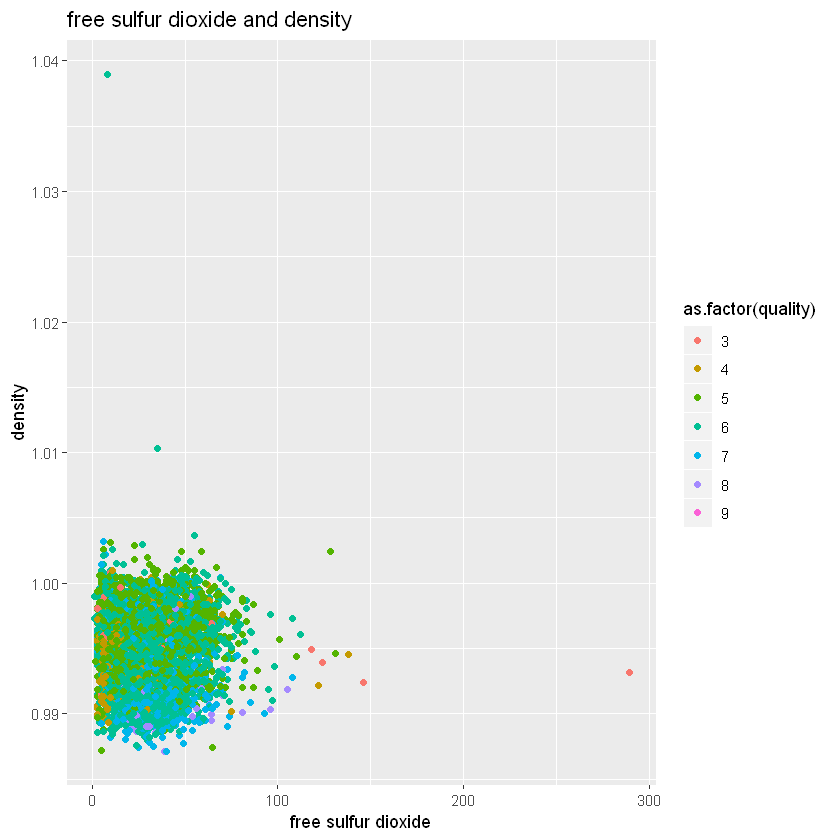

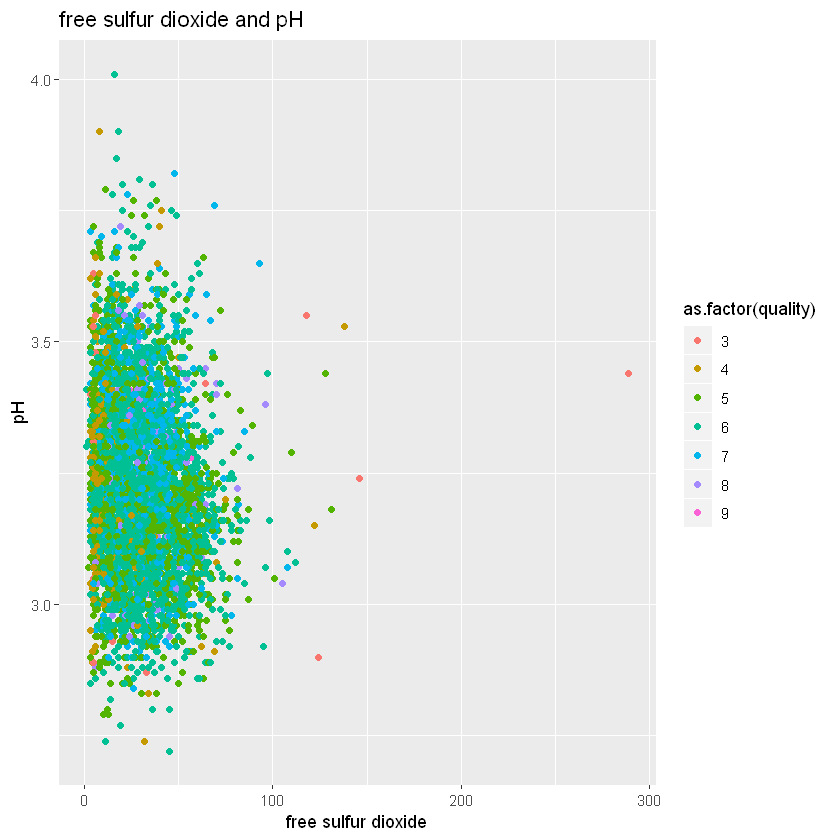

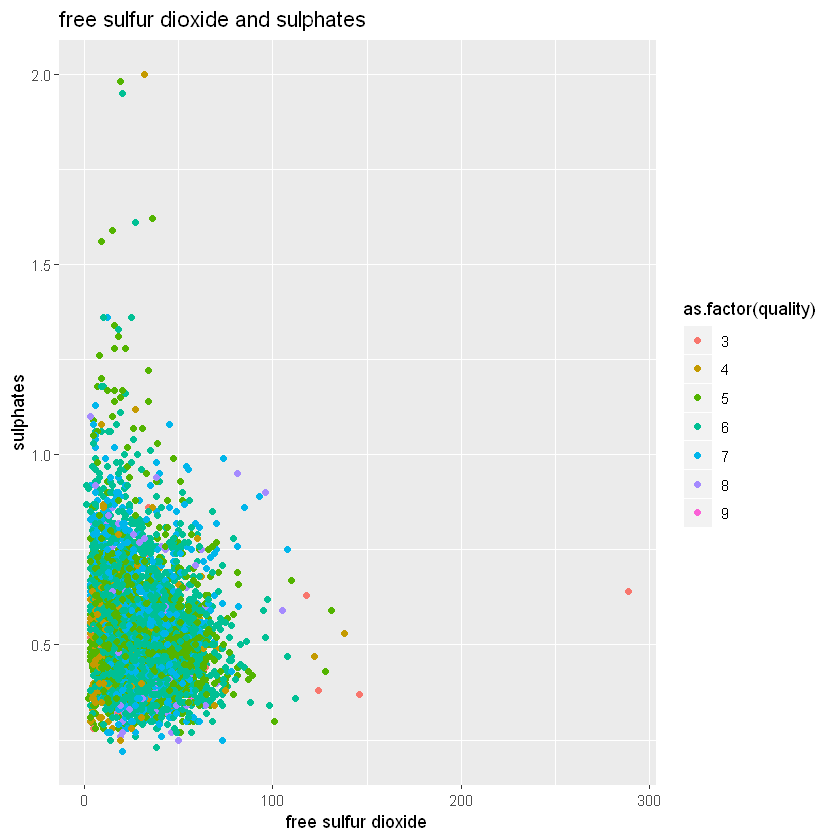

In [43]:
## scatter plot free sulfur dioxide and others
ggplot(data, aes(x =`free sulfur dioxide`, y =`total sulfur dioxide`, color = as.factor(quality)))+ geom_point() + labs(title="free sulfur dioxide and total_sulfur_dioxide")
ggplot(data, aes(x =`free sulfur dioxide`, y =density, color = as.factor(quality)))+ geom_point() + labs(title="free sulfur dioxide and density")
ggplot(data, aes(x =`free sulfur dioxide`, y =pH, color = as.factor(quality)))+ geom_point() + labs(title="free sulfur dioxide and pH")
ggplot(data, aes(x =`free sulfur dioxide`, y =sulphates, color = as.factor(quality)))+ geom_point() + labs(title="free sulfur dioxide and sulphates")

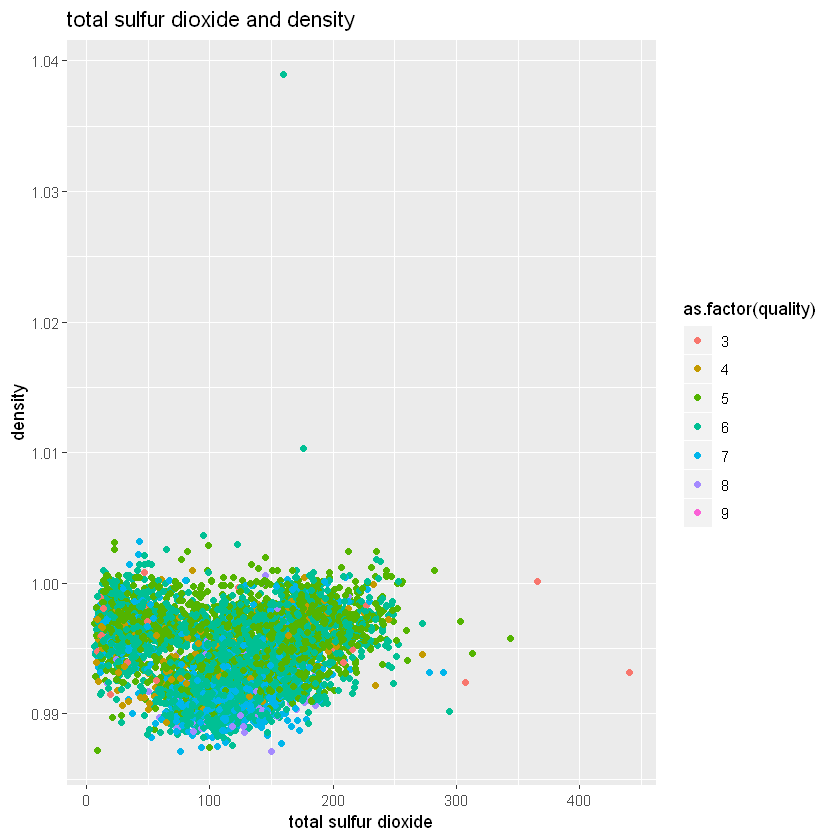

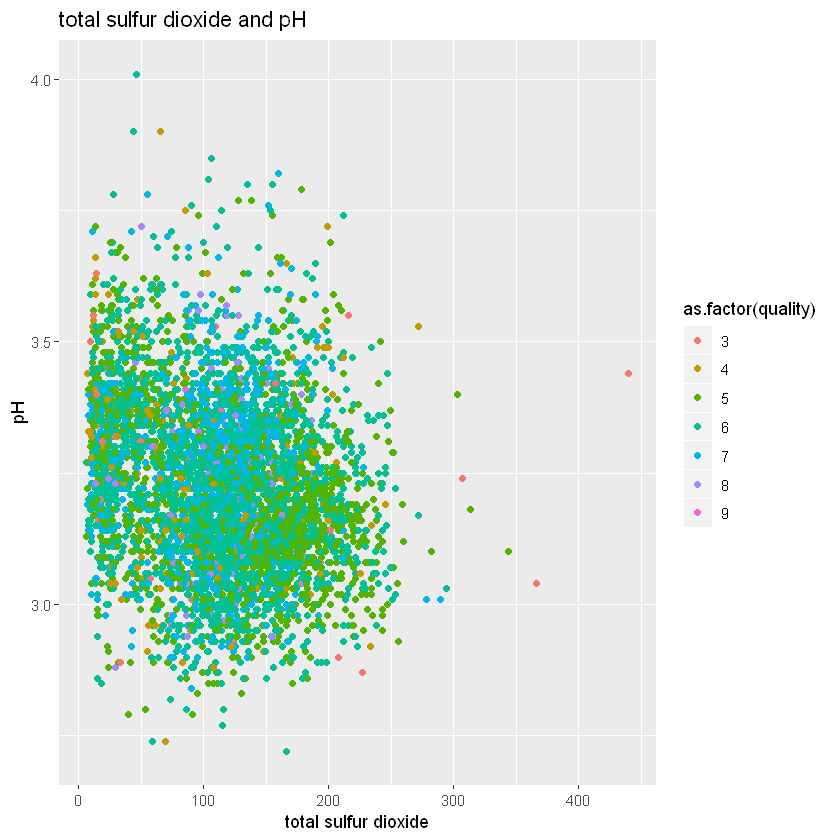

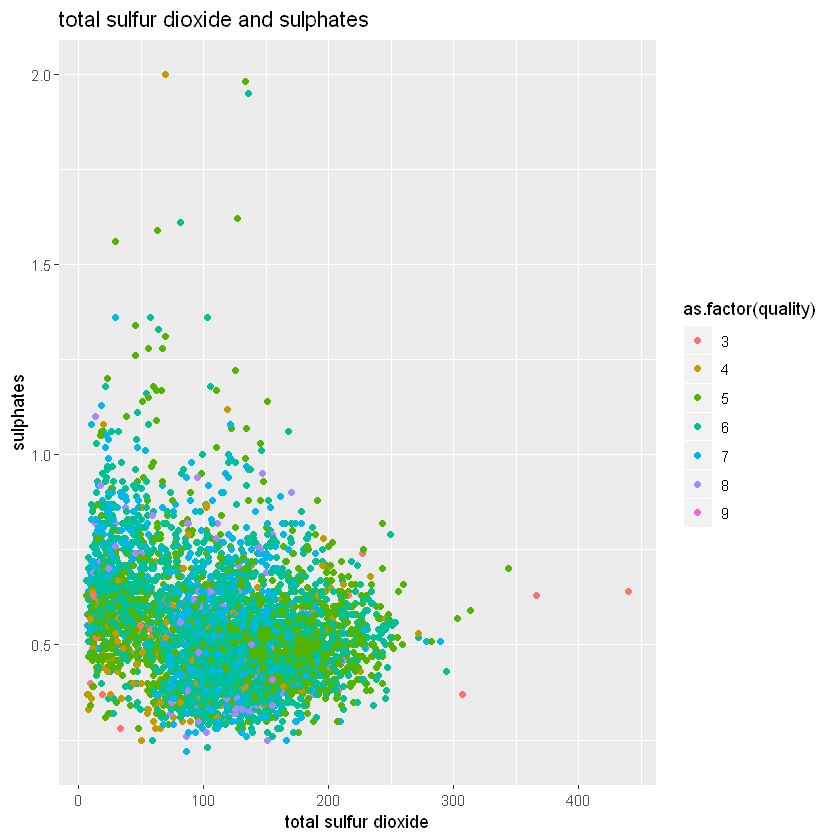

In [44]:
## scatter plot total sulfur dioxide and others
ggplot(data, aes(x =`total sulfur dioxide`, y =density, color = as.factor(quality)))+ geom_point() + labs(title="total sulfur dioxide and density")
ggplot(data, aes(x =`total sulfur dioxide`, y =pH, color = as.factor(quality)))+ geom_point() + labs(title="total sulfur dioxide and pH")
ggplot(data, aes(x =`total sulfur dioxide`, y =sulphates, color = as.factor(quality)))+ geom_point() + labs(title="total sulfur dioxide and sulphates")

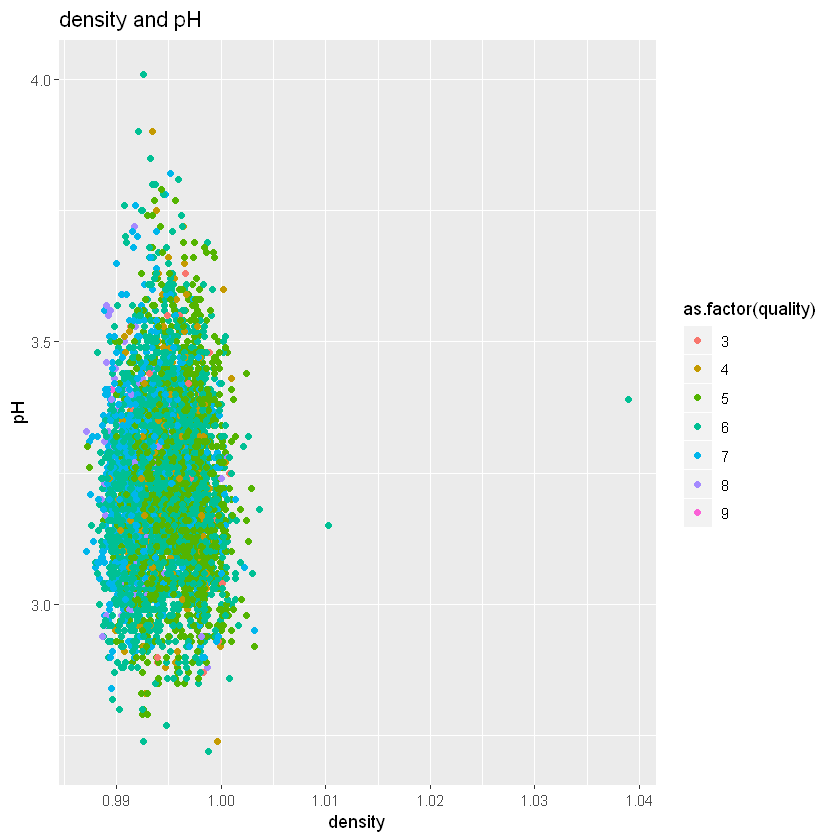

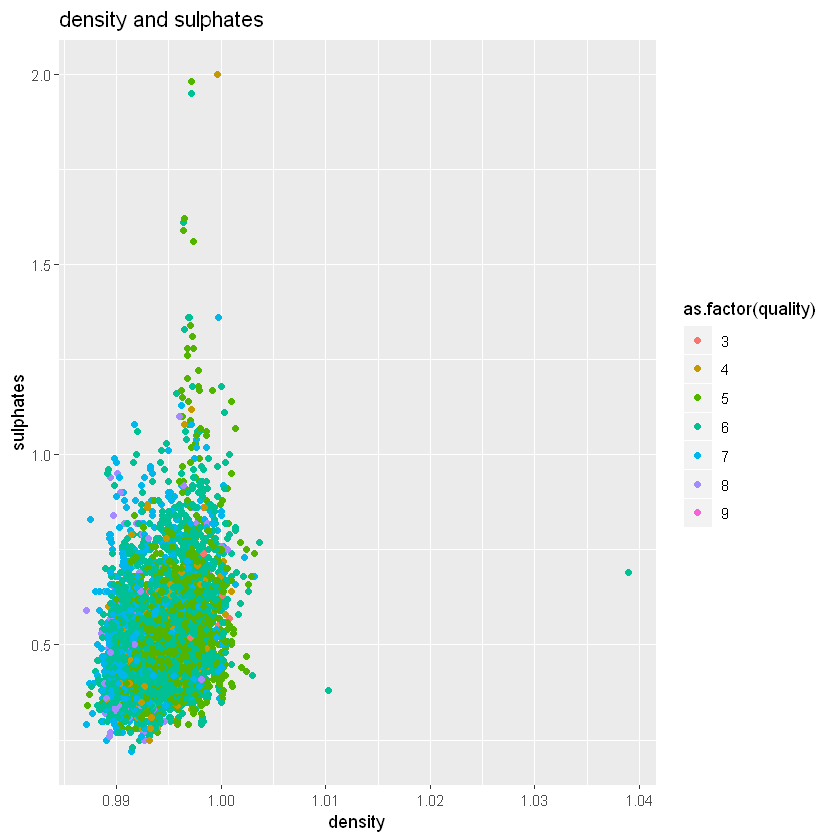

In [45]:
## scatter plot density and others
ggplot(data, aes(x =density, y =pH, color = as.factor(quality)))+ geom_point() + labs(title="density and pH")
ggplot(data, aes(x =density, y =sulphates, color = as.factor(quality)))+ geom_point() + labs(title="density and sulphates")

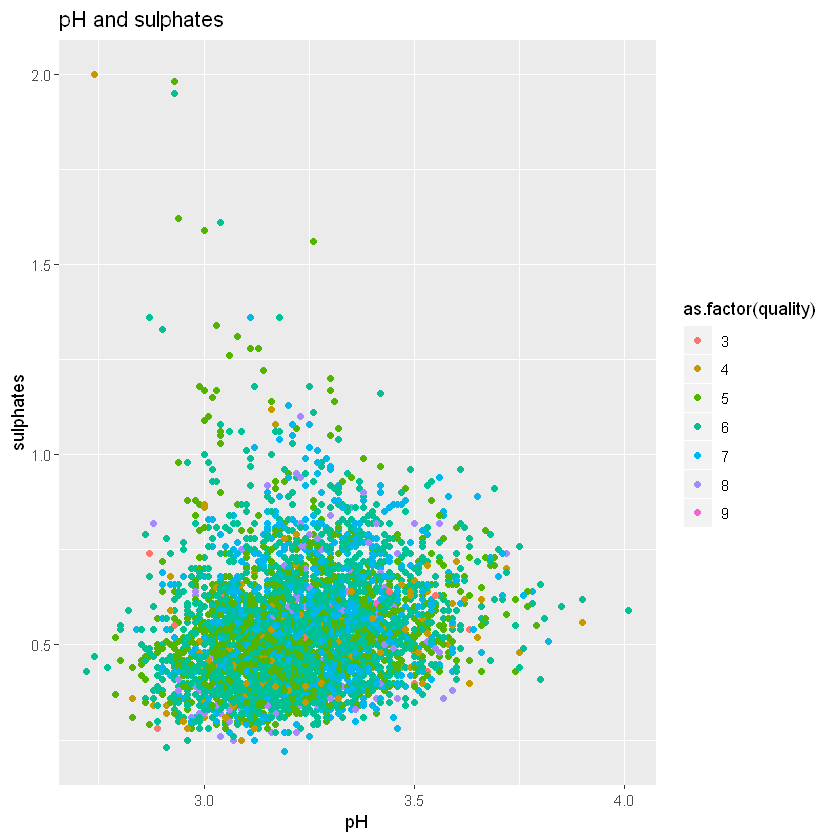

In [46]:
## scatter plot pH and others
ggplot(data, aes(x =pH, y =sulphates, color = as.factor(quality)))+ geom_point() + labs(title="pH and sulphates")

#### From all the scatter plot, we can see that it's hard to discrete the quality, all of them are together

#### Hist plot

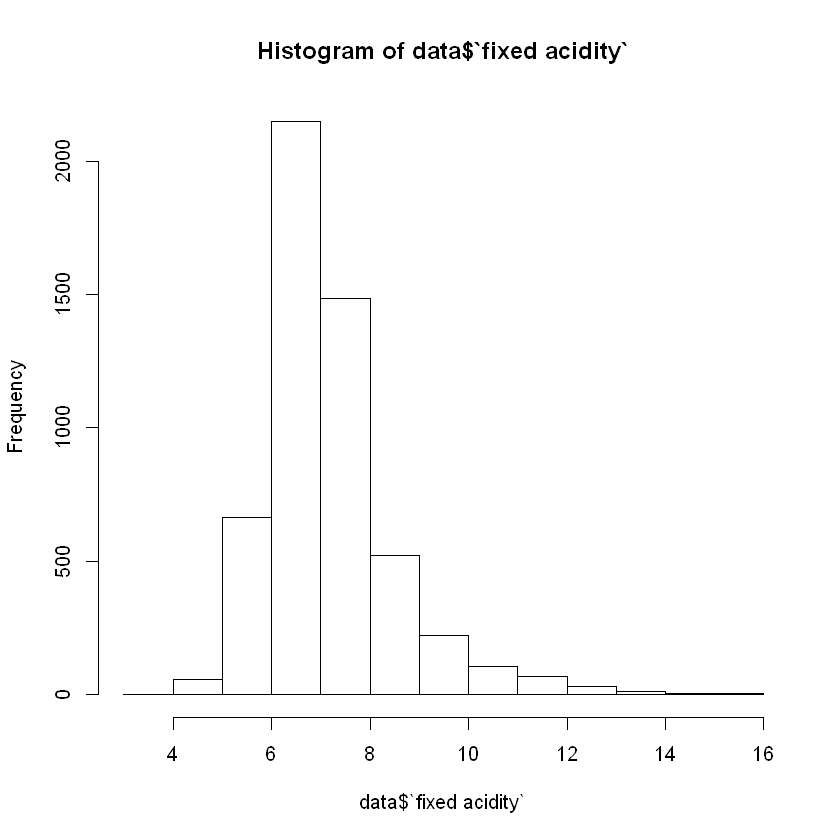

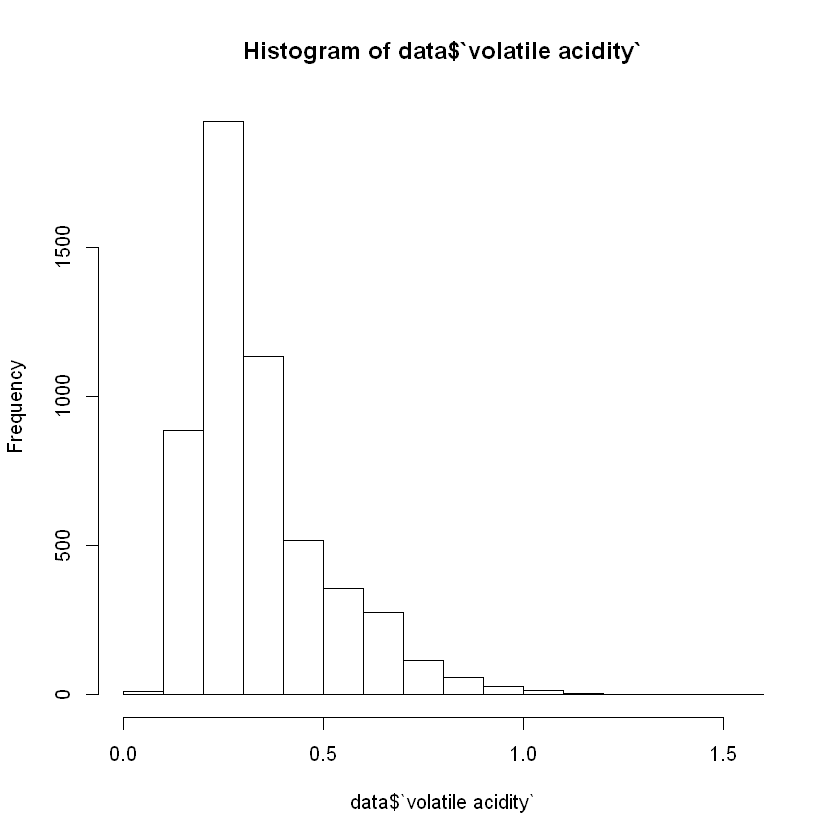

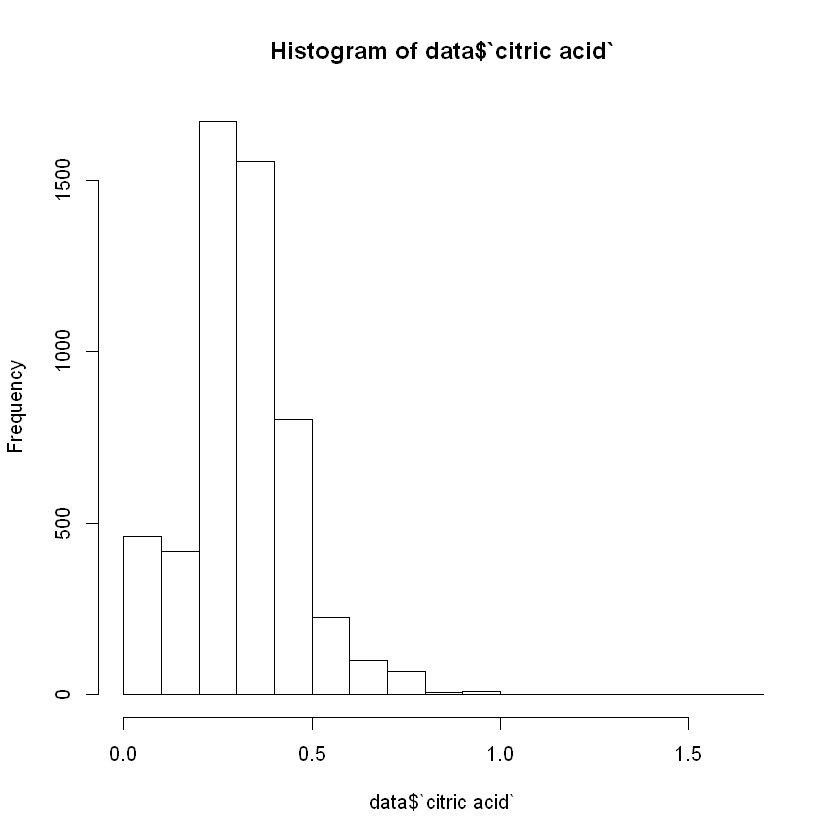

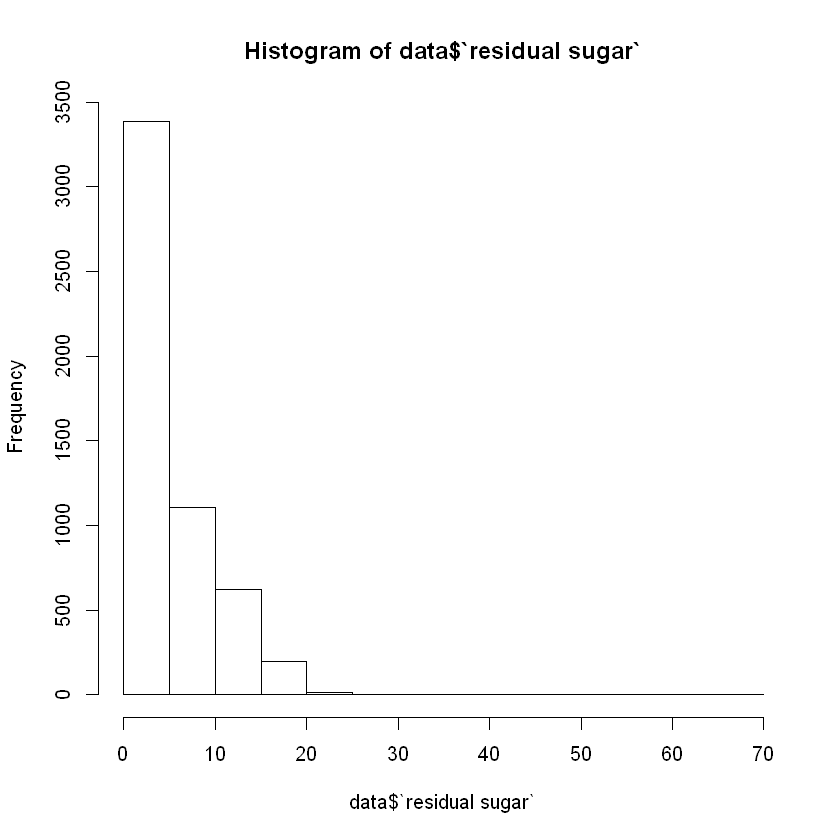

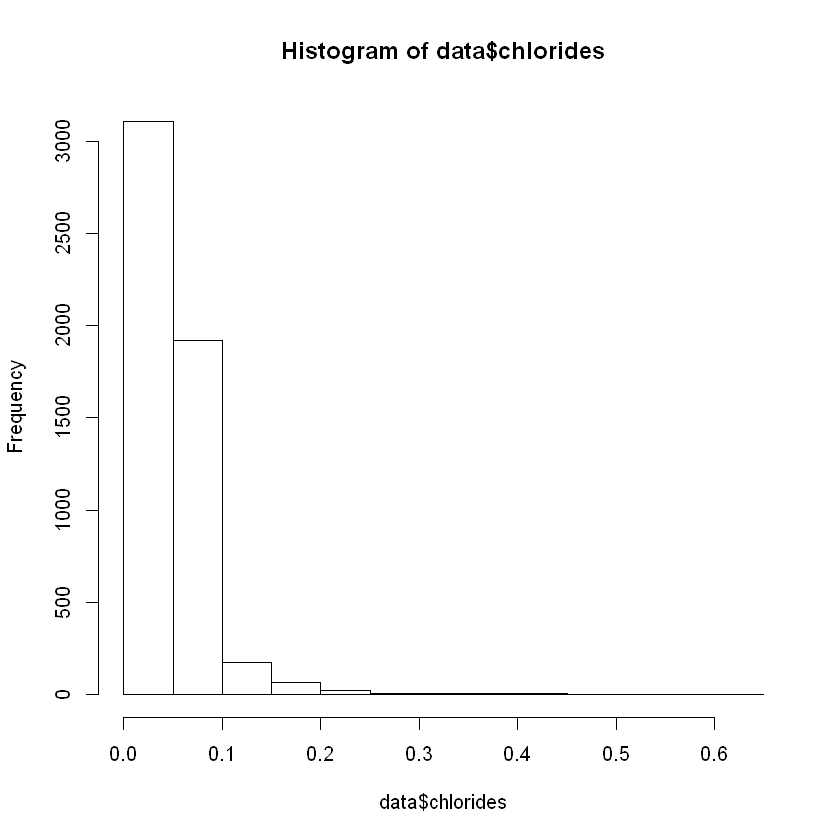

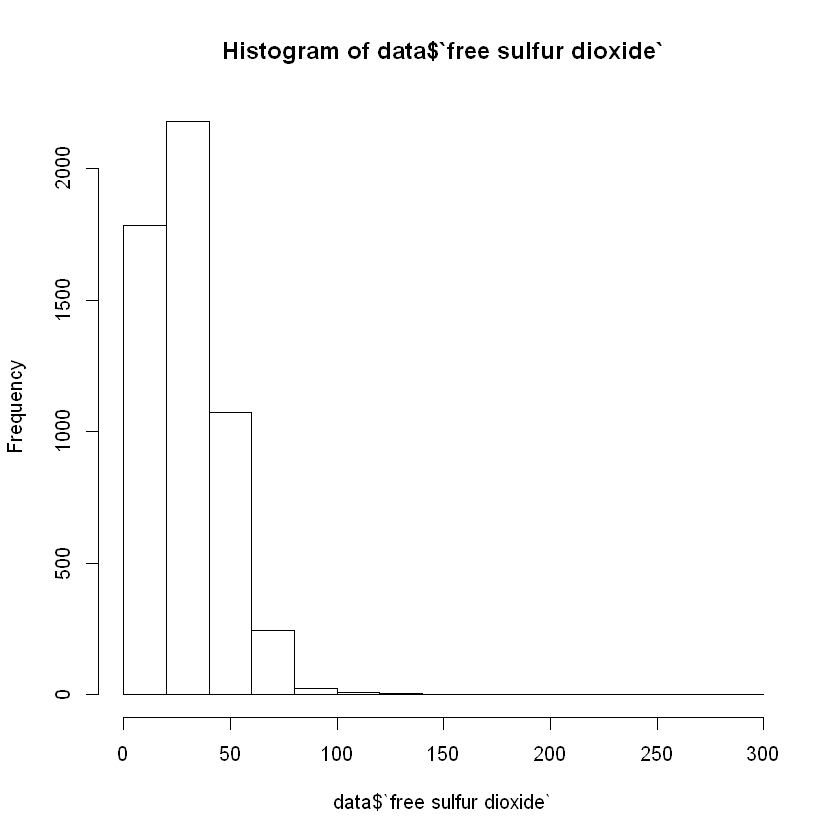

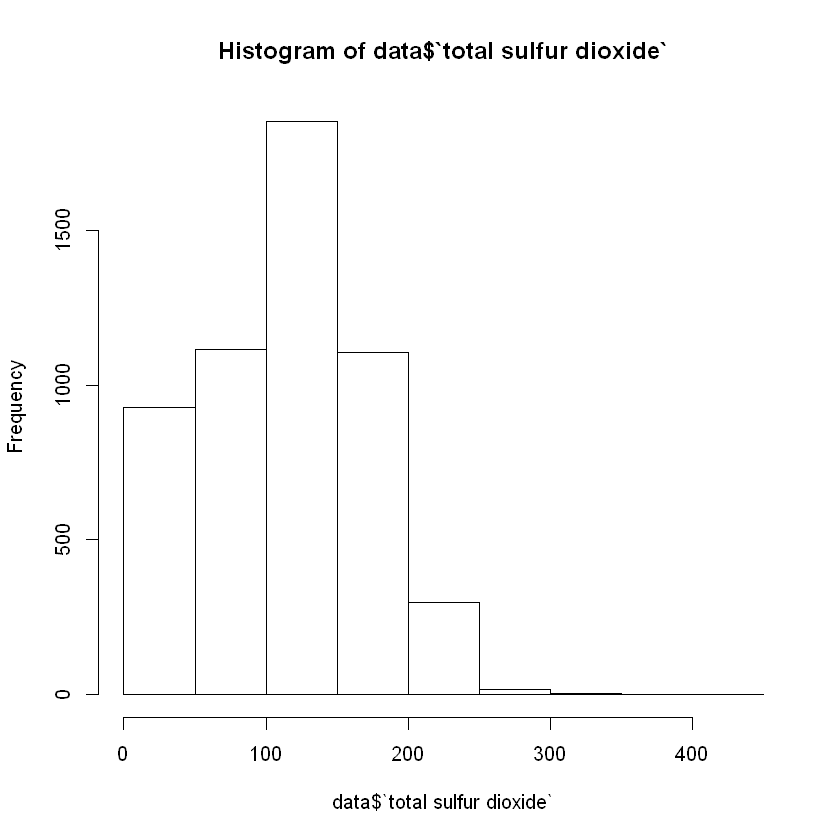

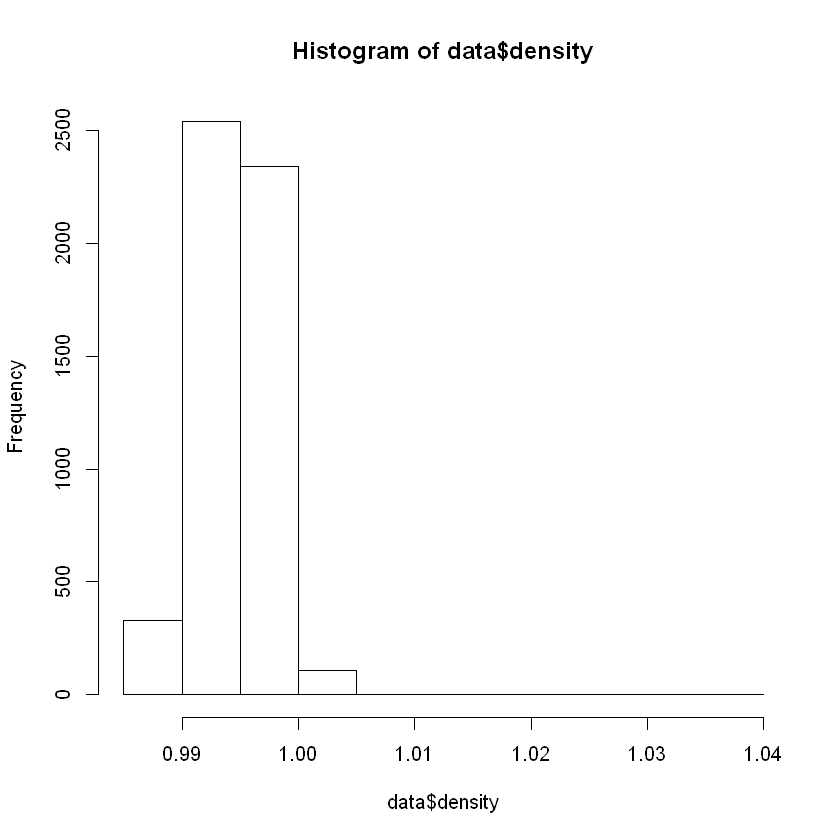

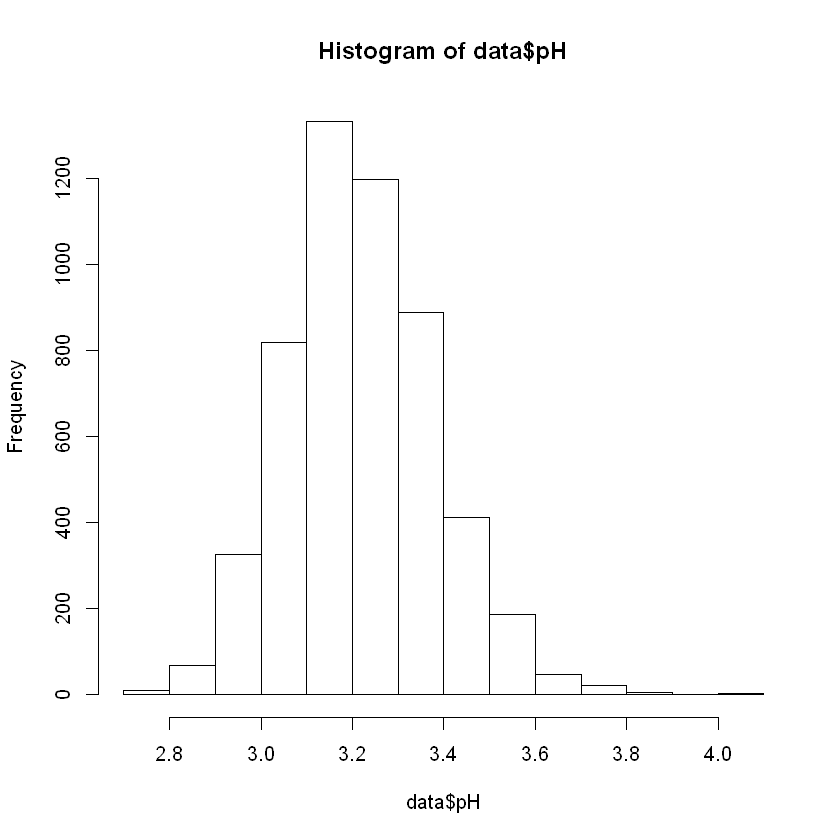

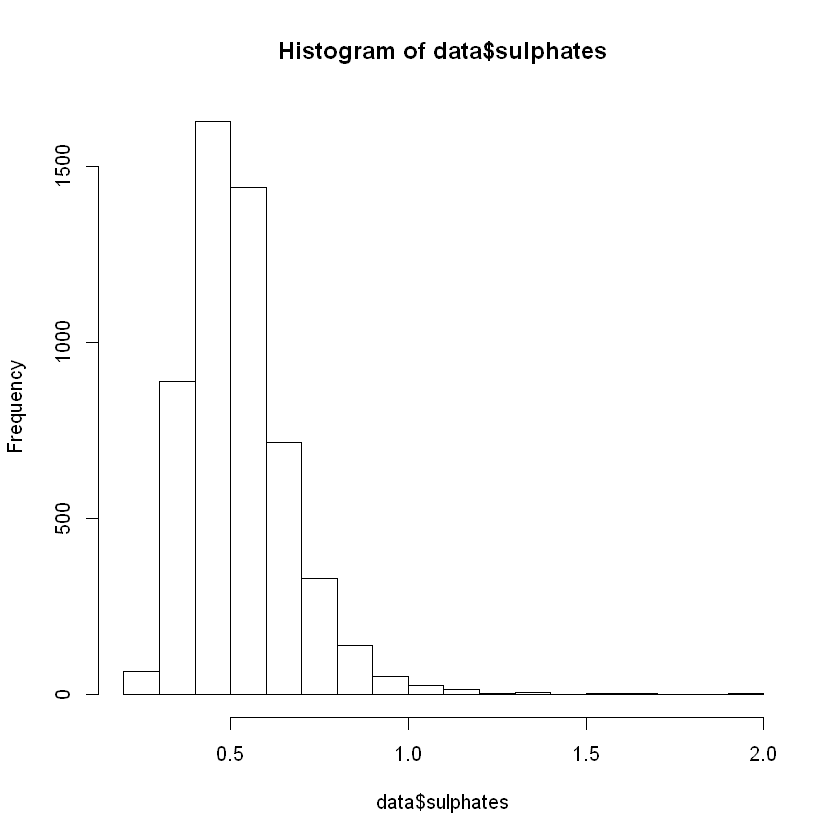

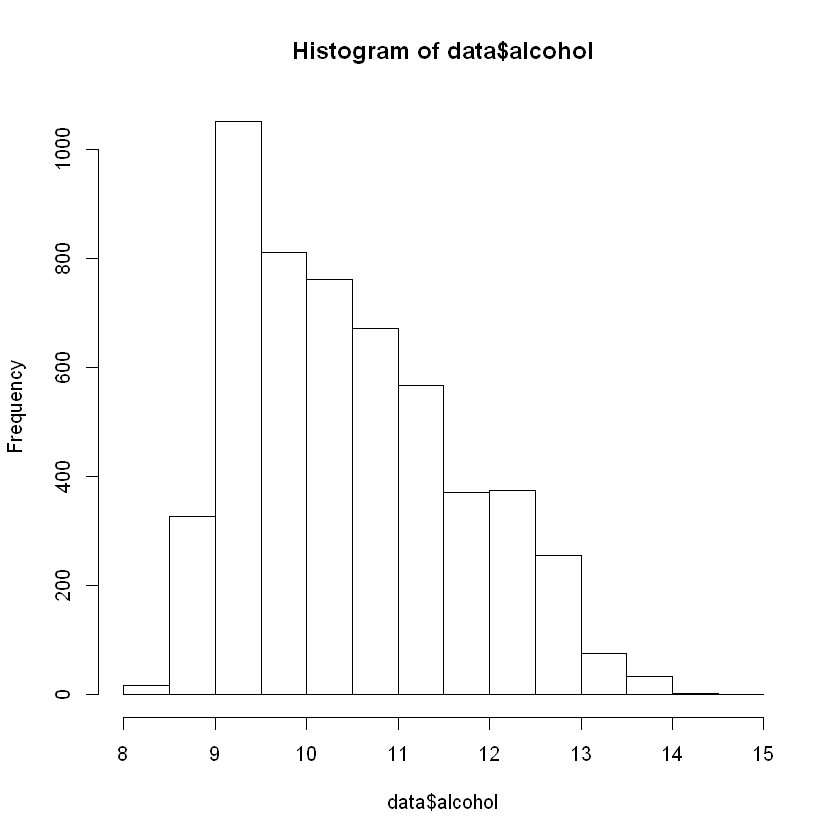

In [13]:
hist(data$`fixed acidity`)
hist(data$`volatile acidity`)
hist(data$`citric acid`)
hist(data$`residual sugar`)
hist(data$chlorides)
hist(data$`free sulfur dioxide`)
hist(data$`total sulfur dioxide`)
hist(data$density)
hist(data$pH)
hist(data$sulphates)
hist(data$alcohol)
## we can see that the distribution of most factor are not normal

#### Box plot

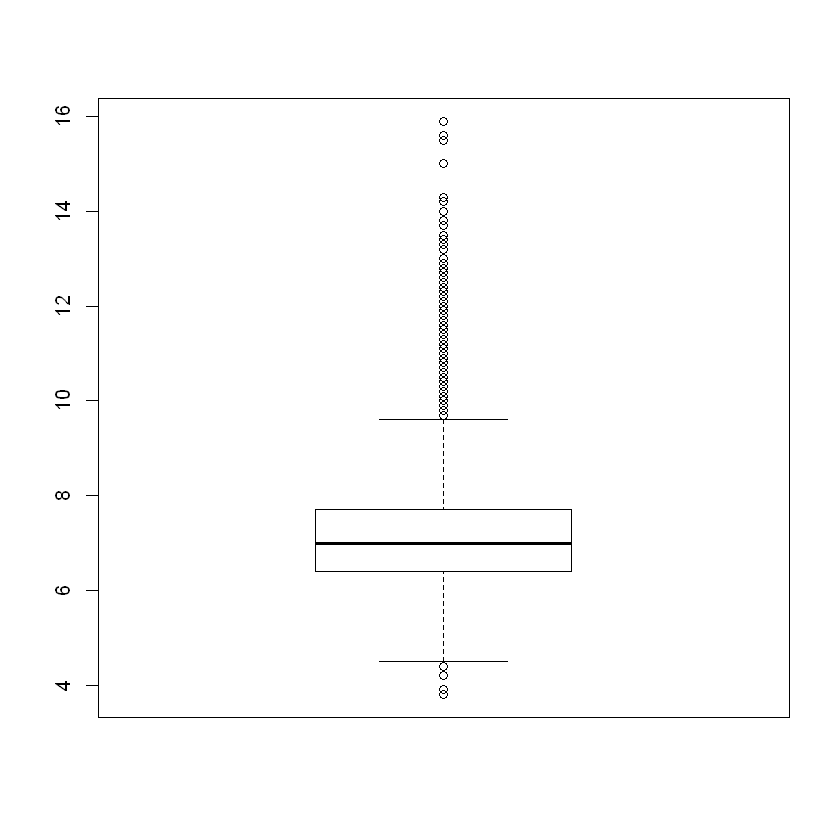

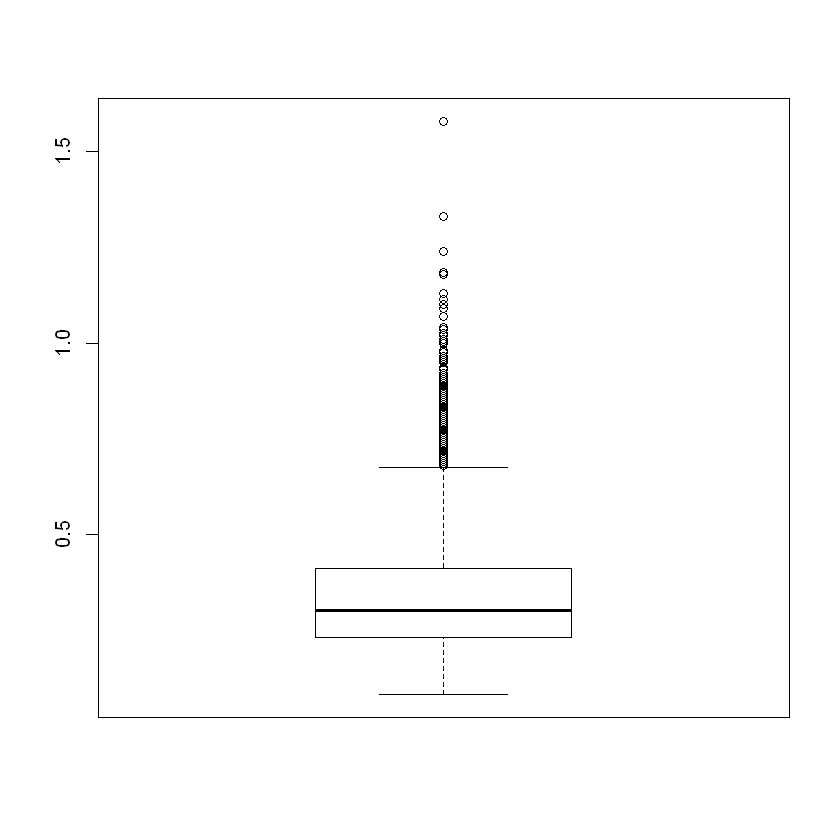

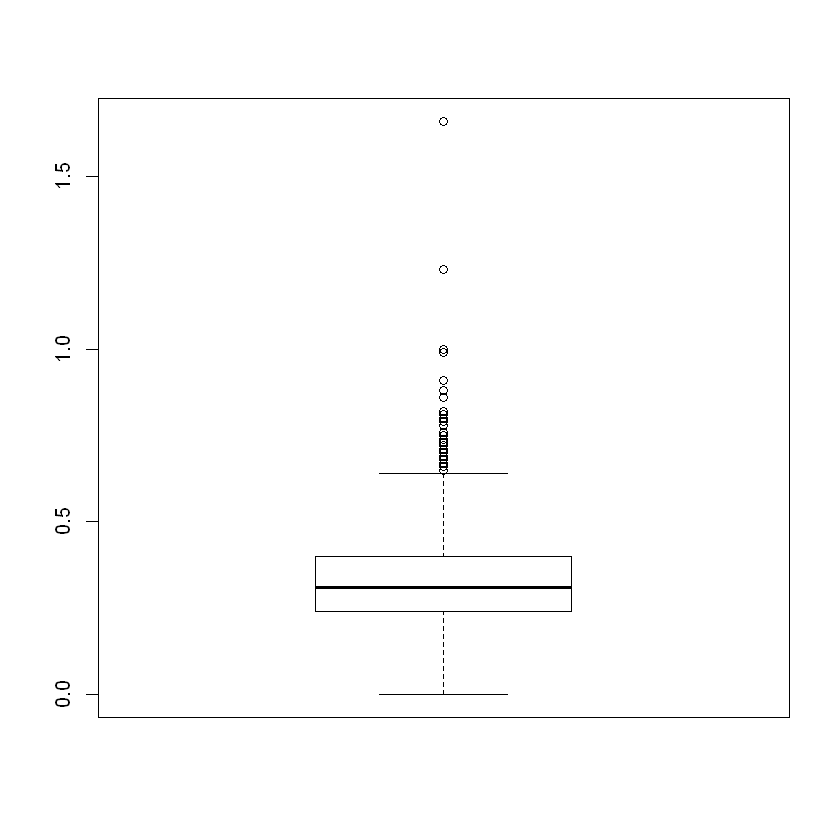

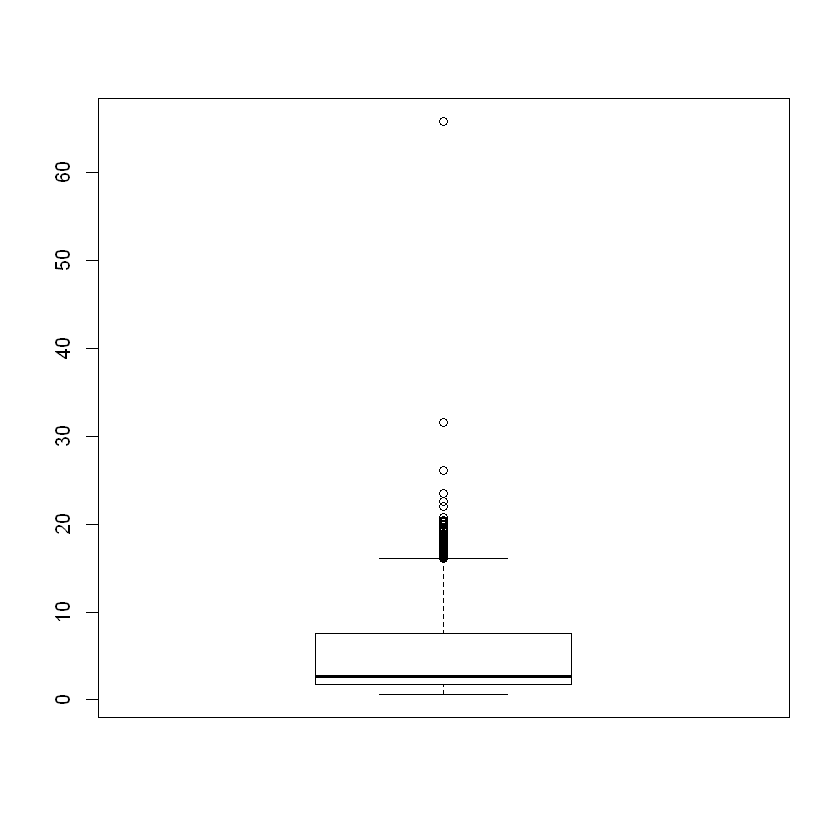

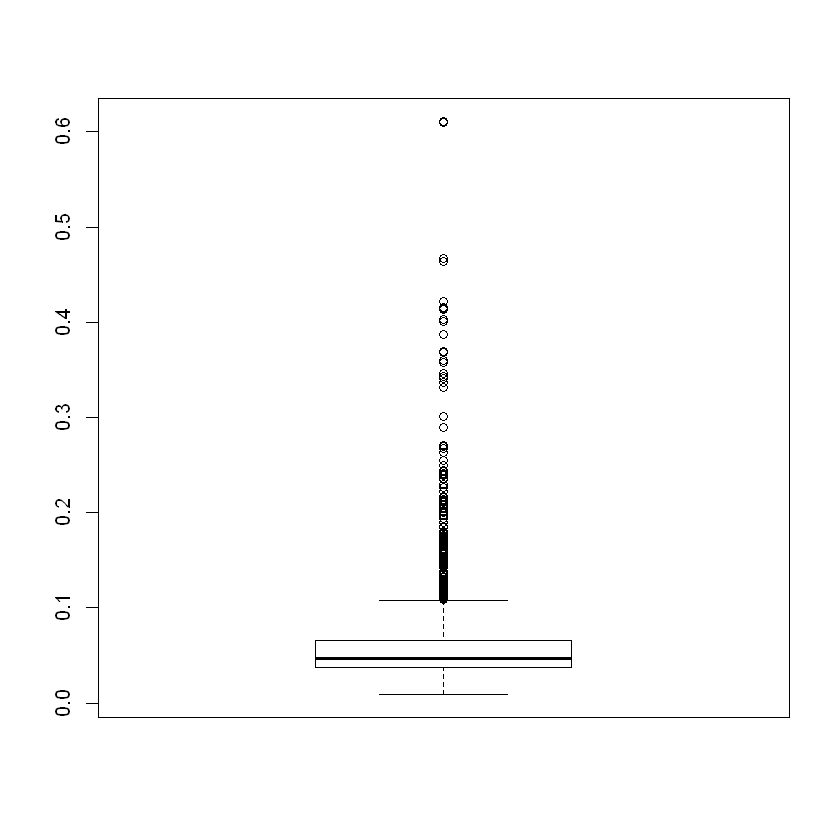

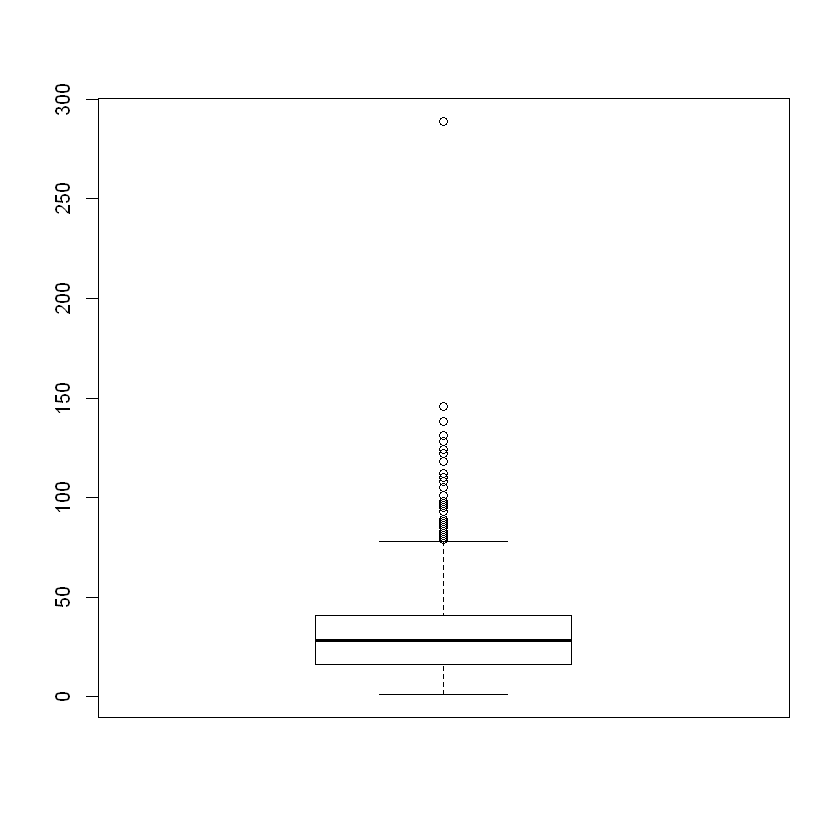

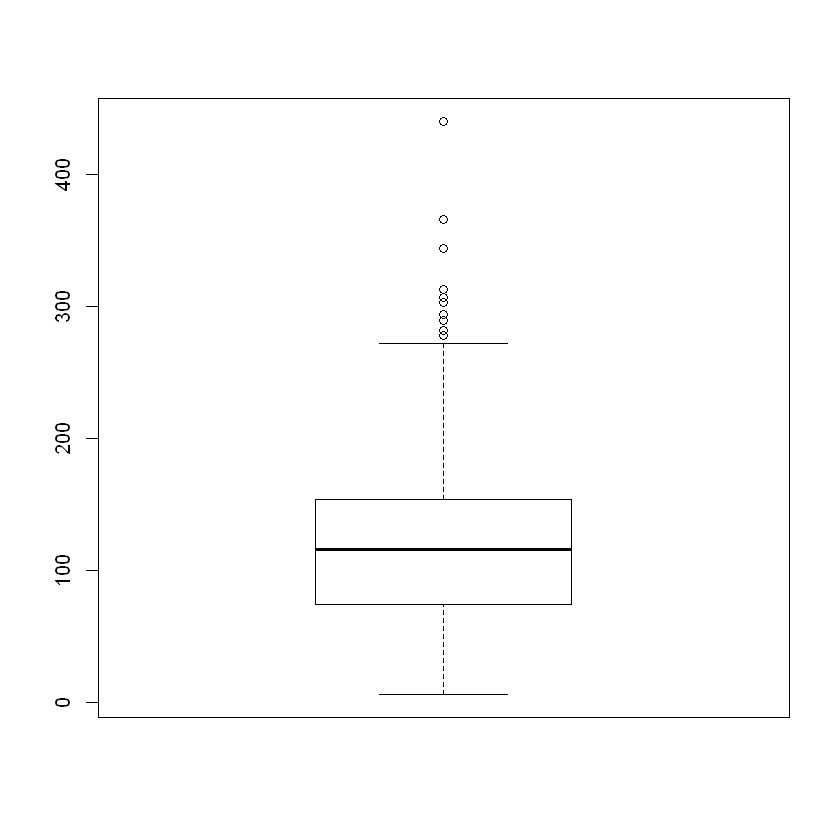

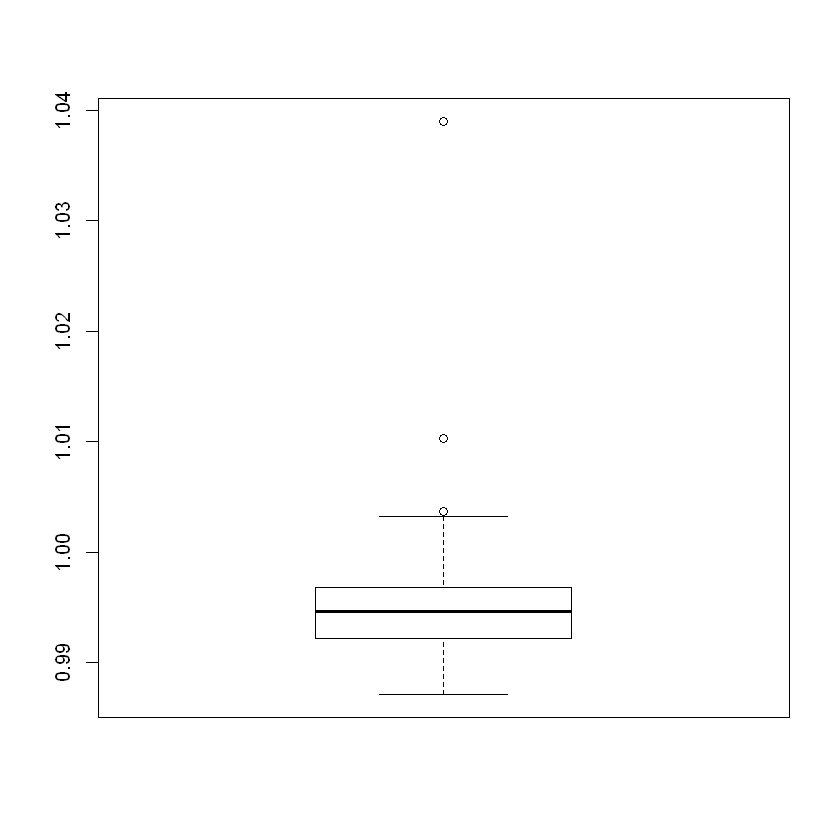

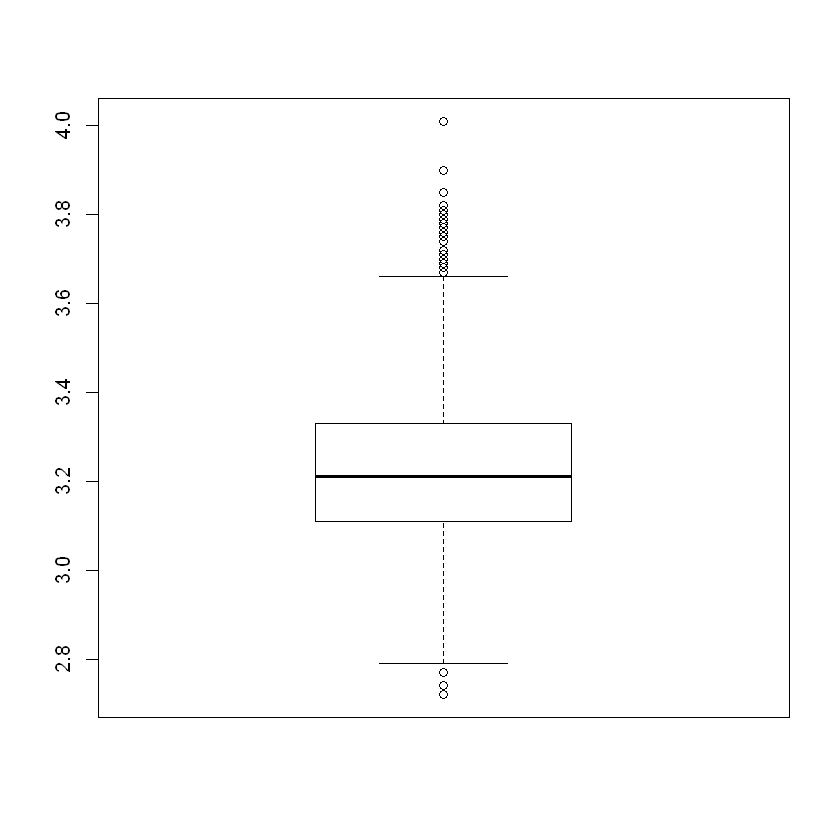

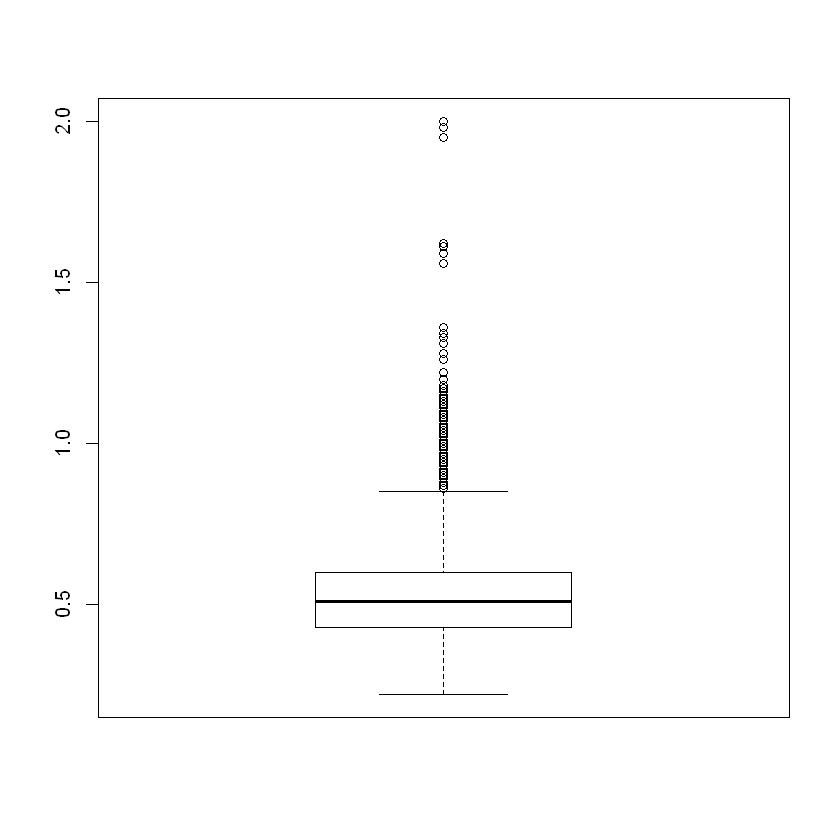

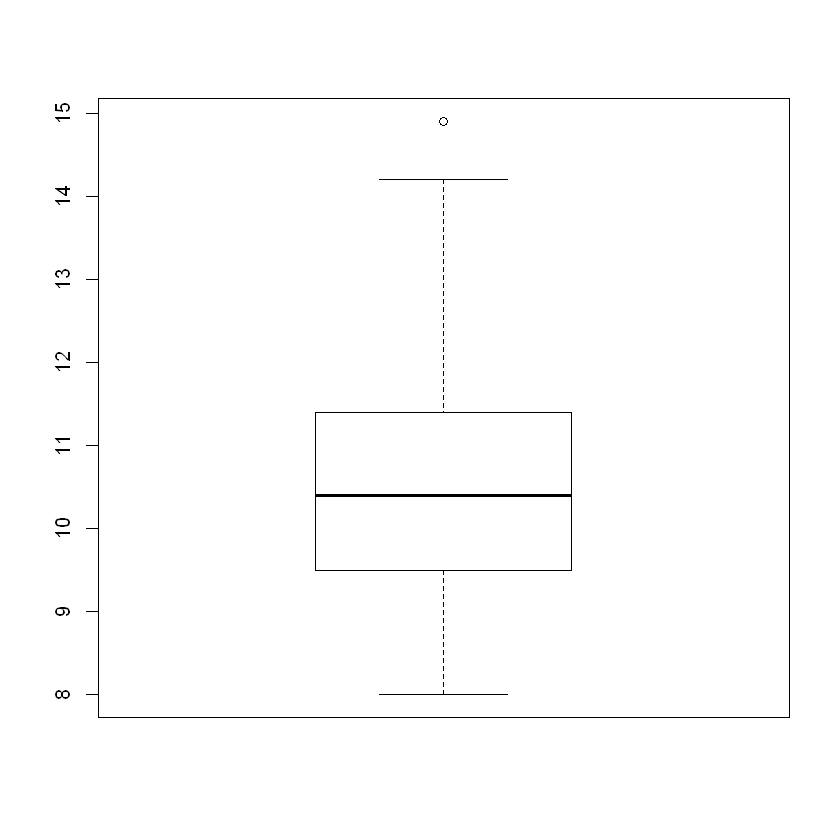

In [15]:
boxplot(data$`fixed acidity`)
boxplot(data$`volatile acidity`)
boxplot(data$`citric acid`)
boxplot(data$`residual sugar`)
boxplot(data$chlorides)
boxplot(data$`free sulfur dioxide`)
boxplot(data$`total sulfur dioxide`)
boxplot(data$density)
boxplot(data$pH)
boxplot(data$sulphates)
boxplot(data$alcohol)
## we can see that the most factor have outlier

#### plot with each quality

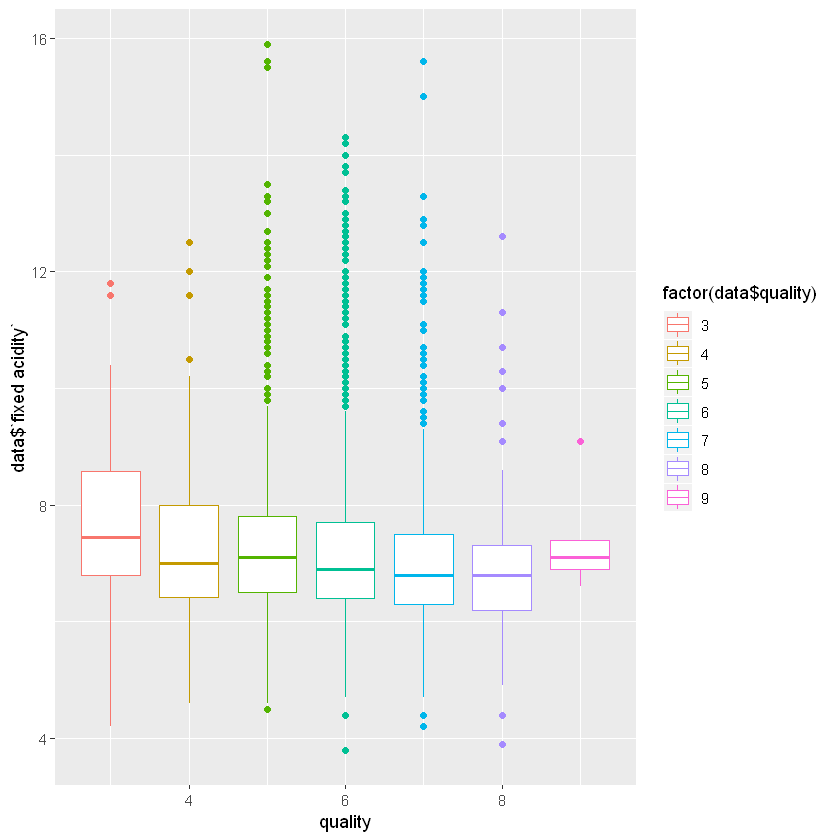

In [122]:
## fixed acidity
ggplot(data, aes(x = quality, y = data$`fixed acidity`, group=quality, color=factor(data$quality))) + geom_boxplot()

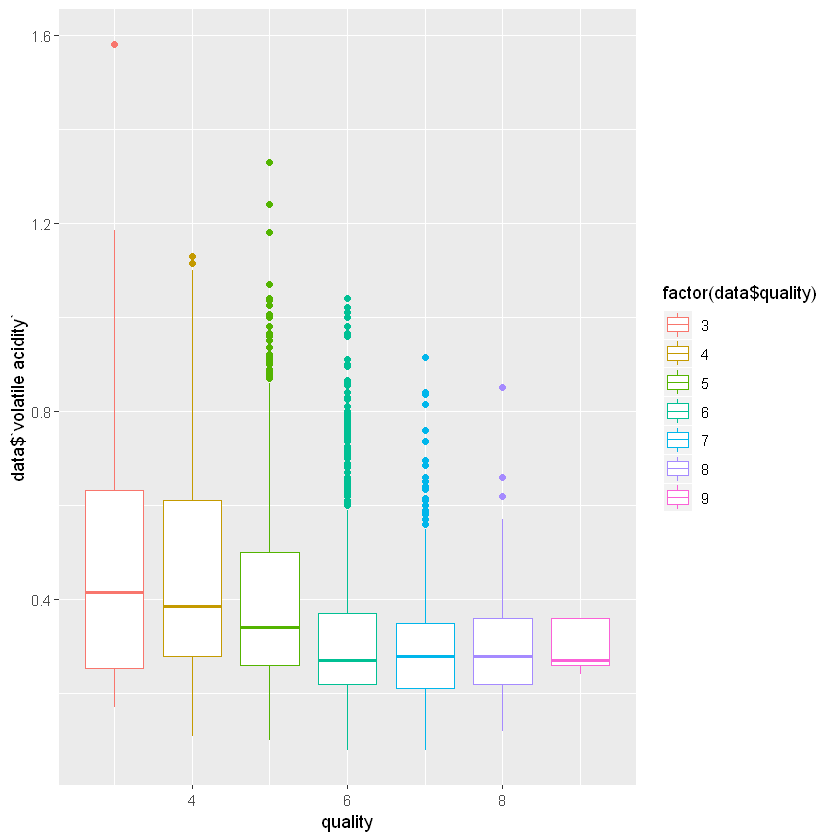

In [119]:
## volatile acidity
ggplot(data, aes(x = quality, y = data$`volatile acidity`, group=quality, color=factor(data$quality))) + geom_boxplot()

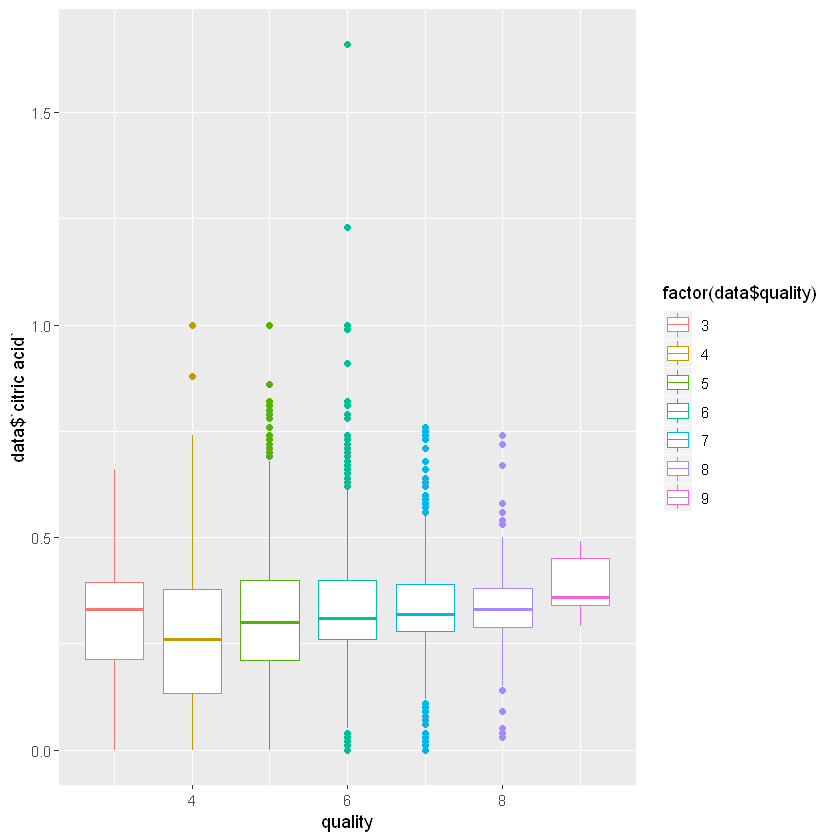

In [120]:
## citric acid
ggplot(data, aes(x = quality, y = data$`citric acid`, group=quality, color=factor(data$quality))) + geom_boxplot()

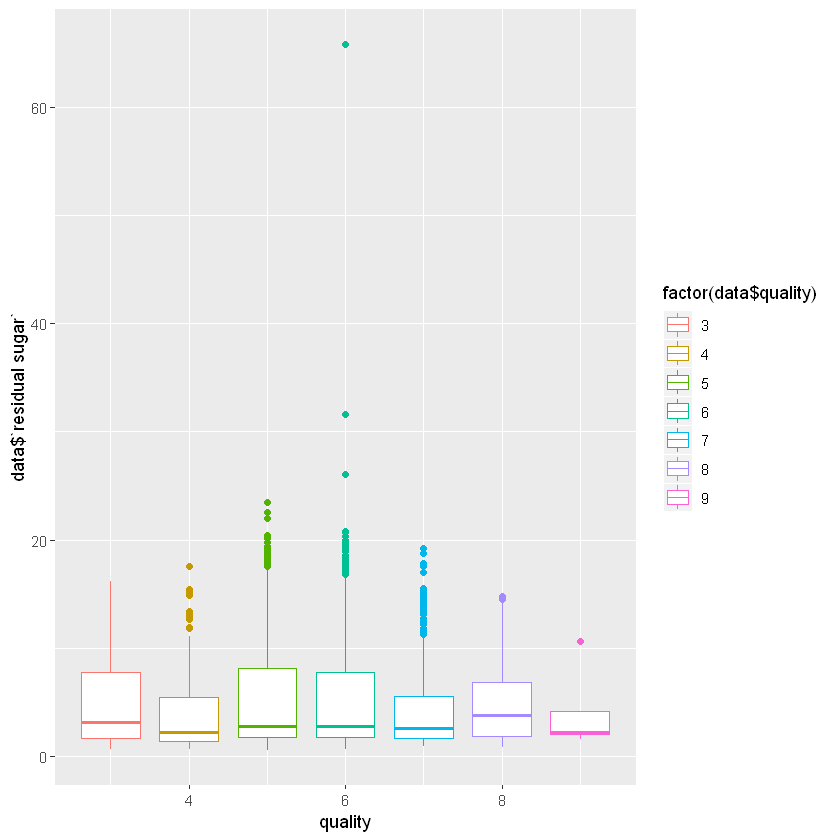

In [123]:
## residual sugar
ggplot(data, aes(x = quality, y = data$`residual sugar`, group=quality, color=factor(data$quality))) + geom_boxplot()

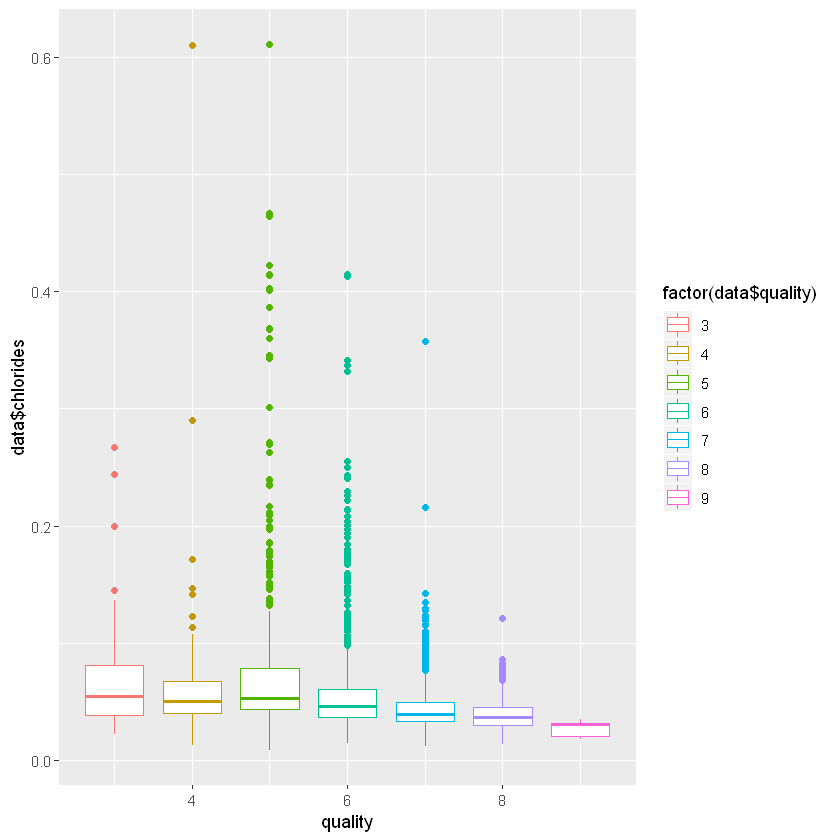

In [124]:
## chlorides
ggplot(data, aes(x = quality, y = data$chlorides, group=quality, color=factor(data$quality))) + geom_boxplot()

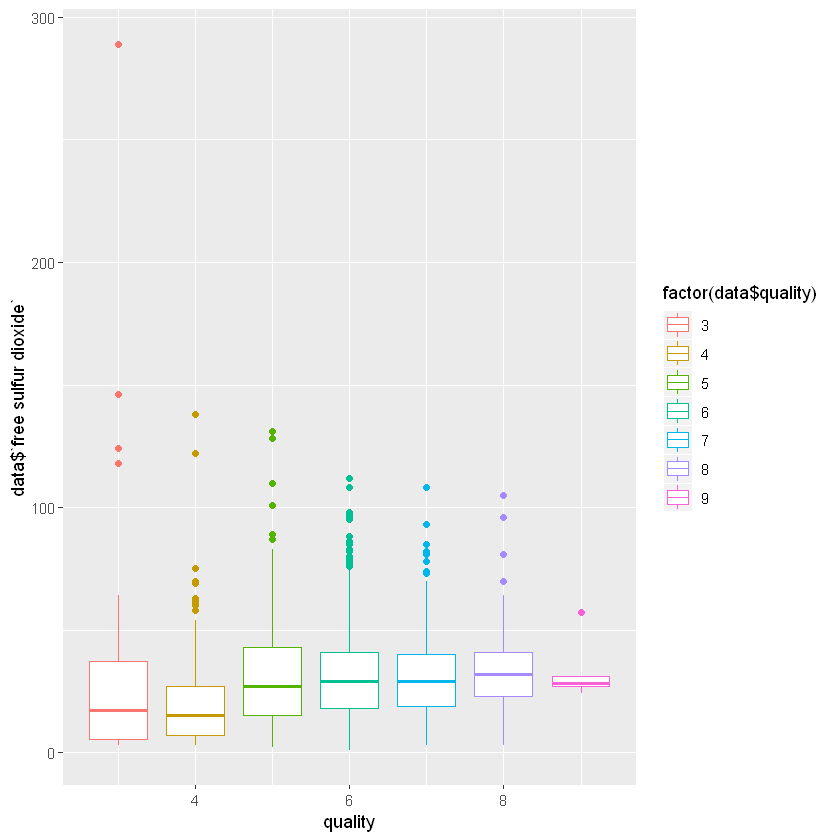

In [125]:
## free sulfur dioxide
ggplot(data, aes(x = quality, y = data$`free sulfur dioxide`, group=quality, color=factor(data$quality))) + geom_boxplot()

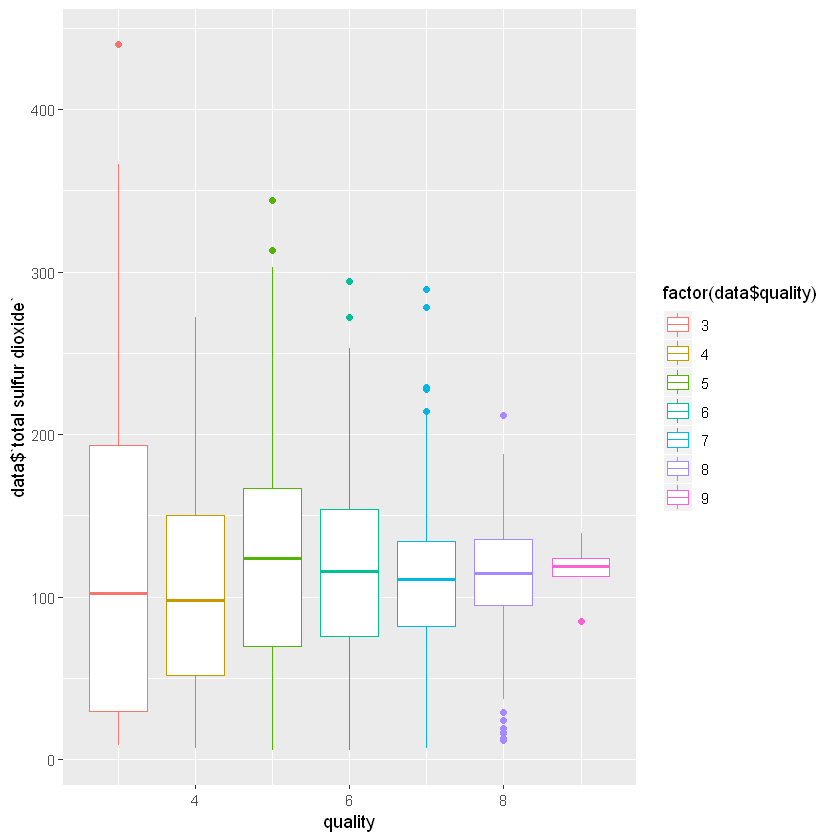

In [126]:
## total sulfur dioxide
ggplot(data, aes(x = quality, y = data$`total sulfur dioxide`, group=quality, color=factor(data$quality))) + geom_boxplot()

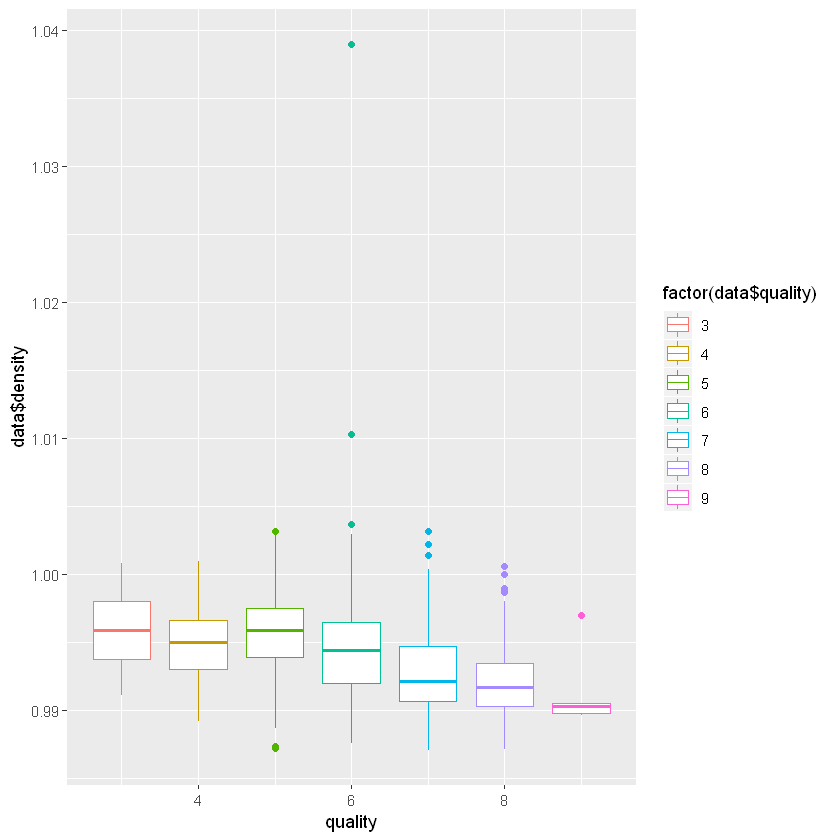

In [127]:
## density
ggplot(data, aes(x = quality, y = data$density, group=quality, color=factor(data$quality))) + geom_boxplot()

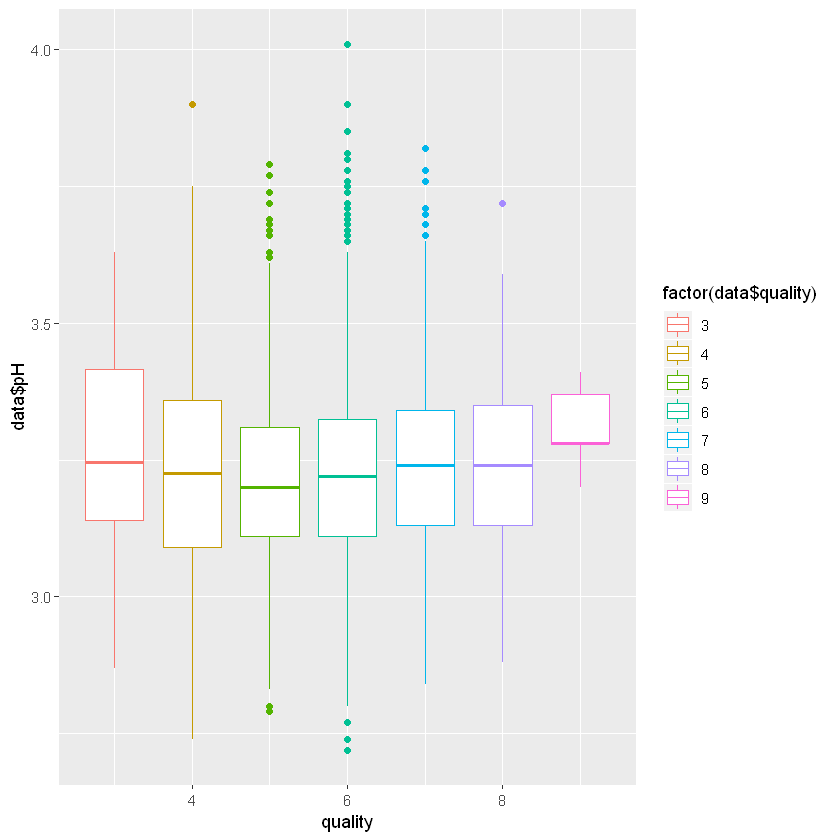

In [128]:
## pH
ggplot(data, aes(x = quality, y = data$pH, group=quality, color=factor(data$quality))) + geom_boxplot()

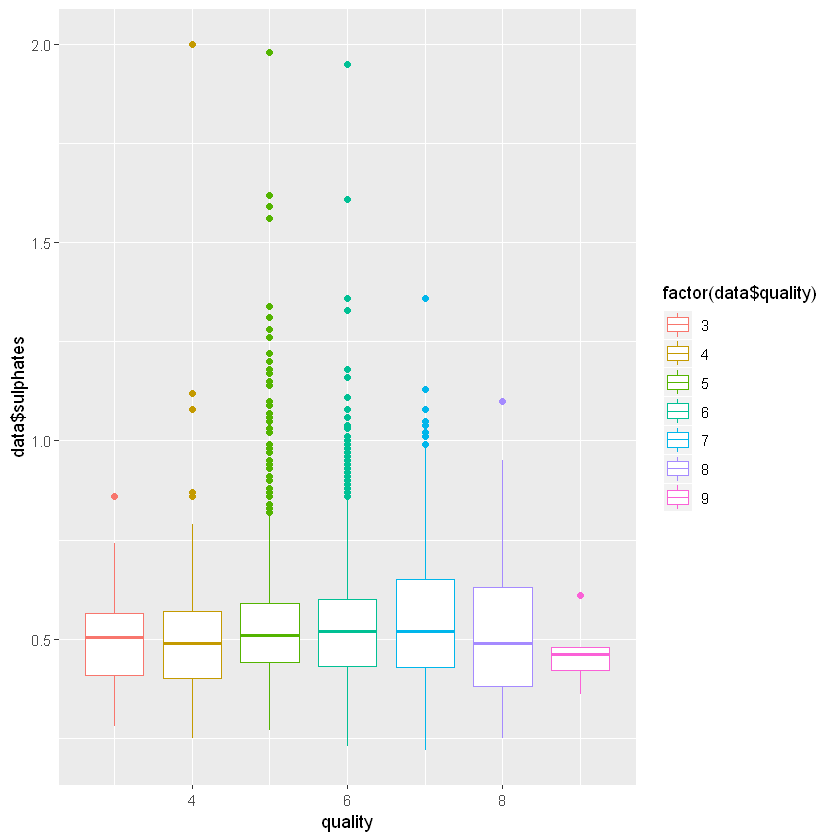

In [129]:
## sulphates
ggplot(data, aes(x = quality, y = data$sulphates, group=quality, color=factor(data$quality))) + geom_boxplot()

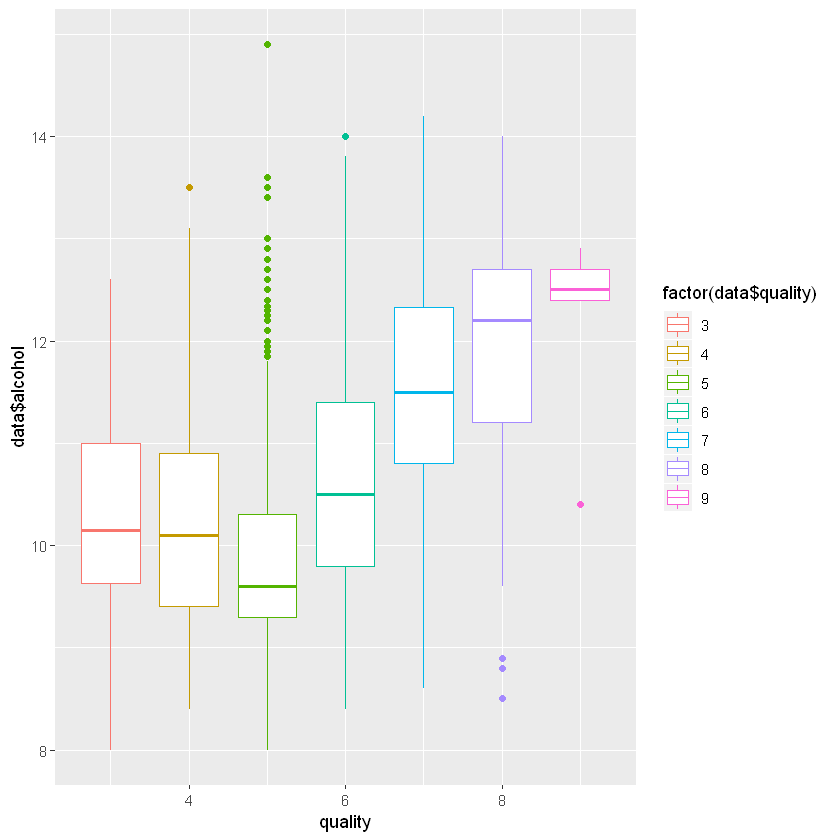

In [130]:
## alcohol
ggplot(data, aes(x = quality, y = data$alcohol, group=quality, color=factor(data$quality))) + geom_boxplot()


  red white 
 1359  3961 

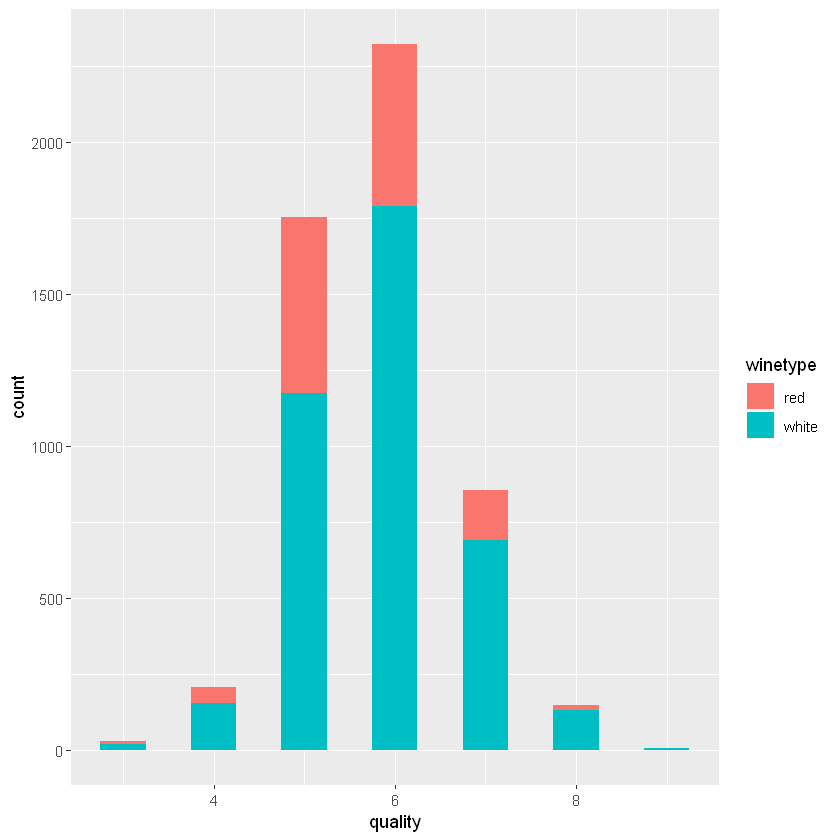

In [143]:
## wine type
ggplot(data, mapping=aes(x=quality,fill=winetype))+
  geom_bar(stat="count",width=0.5,position='stack')
table(data$winetype)

## 4. Data preprocess

#### skewness

In [245]:
apply(data[,1:11], 2, skewness)
## many columns have skew distribution

fixed acidity     volatile acidity          citric acid 
          1.64948661           1.50370887           0.48403596 
      residual sugar            chlorides  free sulfur dioxide 
          1.70558805           5.33522705           1.36062708 
total sulfur dioxide              density                   pH 
          0.06331078           0.66595012           0.38974933 
           sulphates              alcohol 
          1.80843353           0.54538829

In [246]:
## use BoxCox to transform the data
data_skew <- preProcess(data[,1:11], c("BoxCox", "center", "scale"))
data2 <- data.frame(trans = predict(data_skew, data))
apply(data2[,1:11], 2, skewness)

trans.fixed.acidity     trans.volatile.acidity 
              -0.082276196               -0.010035734 
         trans.citric.acid       trans.residual.sugar 
               0.484035956                0.326289962 
           trans.chlorides  trans.free.sulfur.dioxide 
              -0.095945807               -0.097757936 
trans.total.sulfur.dioxide              trans.density 
               0.063310775                0.541384839 
                  trans.pH            trans.sulphates 
              -0.009242589                0.020777870 
             trans.alcohol 
               0.059314754

#### outlier

In [247]:
#### scale the data and remove the z-score that >3, <-3
scaledata <- scale(data2[,1:11])
data2 <- cbind(scaledata, data2[,12:13])
data2 <- filter(data2, data2$trans.fixed.acidity <3 & data2$trans.fixed.acidity > -3)
data2 <- filter(data2, data2$trans.volatile.acidity <3 & data2$trans.volatile.acidity > -3)
data2 <- filter(data2, data2$trans.citric.acid <3 & data2$trans.citric.acid > -3)
data2 <- filter(data2, data2$trans.residual.sugar <3 & data2$trans.residual.sugar > -3)
data2 <- filter(data2, data2$trans.chlorides <3 & data2$trans.chlorides > -3)
data2 <- filter(data2, data2$trans.free.sulfur.dioxide <3 & data2$trans.free.sulfur.dioxide > -3)
data2 <- filter(data2, data2$trans.total.sulfur.dioxide <3 & data2$trans.total.sulfur.dioxide > -3)
data2 <- filter(data2, data2$trans.density <3 & data2$trans.density > -3)
data2 <- filter(data2, data2$trans.pH <3 & data2$trans.pH > -3)
data2 <- filter(data2, data2$trans.sulphates <3 & data2$trans.sulphates > -3)
data2 <- filter(data2, data2$trans.alcohol <3 & data2$trans.alcohol > -3)

#### transfer winetype (red = 1, white = 0)

In [248]:
data2$trans.winetype <- ifelse(data2$trans.winetype=='red', 1, 0)

#### PCA

In [249]:
pca.data <- data2[-13]
pca <- prcomp(formula = ~ .,
              data = pca.data, 
              scale = TRUE)  
pca

Standard deviations (1, .., p=12):
 [1] 1.9791722 1.5956991 1.2400618 0.9826772 0.8482064 0.7799386 0.7107753
 [8] 0.6521582 0.6125166 0.5022833 0.3255898 0.2036421

Rotation (n x k) = (12 x 12):
                                   PC1          PC2          PC3         PC4
trans.fixed.acidity        -0.25199352  0.224939090 -0.508970226  0.08702048
trans.volatile.acidity     -0.34006437  0.018621370  0.213746348  0.33646883
trans.citric.acid           0.12113316  0.190513455 -0.569087507 -0.36279421
trans.residual.sugar        0.16786683  0.420756990  0.153679543  0.12639254
trans.chlorides            -0.36212182  0.243694794  0.071381047 -0.04300608
trans.free.sulfur.dioxide   0.34223832  0.227144775  0.194075336 -0.23566702
trans.total.sulfur.dioxide  0.37613182  0.283279683  0.156727308 -0.13571008
trans.density              -0.23453969  0.521097406  0.085014124 -0.01881041
trans.pH                   -0.17540329 -0.191912458  0.481533383 -0.45077474
trans.sulphates            -0.2790

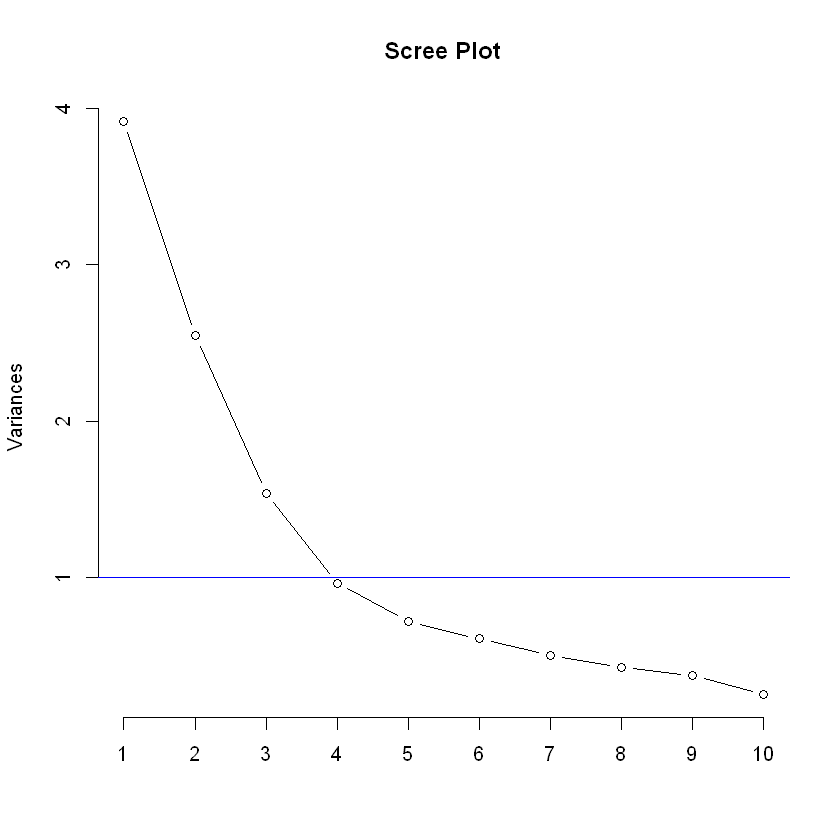

In [250]:
## plot the screet plot
plot(pca,
     type="line",
     main="Scree Plot")

# eigenvalue >1
abline(h=1, col="blue")

[1] 3.91712270 2.54625550 1.53775331 0.96565445 0.71945402 0.60830424
 [7] 0.50520156 0.42531027 0.37517661 0.25228846 0.10600874 0.04147012

[1] 0.326426891 0.212187958 0.128146109 0.080471204 0.059954502 0.050692020
 [7] 0.042100130 0.035442523 0.031264718 0.021024039 0.008834062 0.003455843

[1] 0.3264269 0.5386148 0.6667610 0.7472322 0.8071867 0.8578787 0.8999788
 [8] 0.9354213 0.9666861 0.9877101 0.9965442 1.0000000

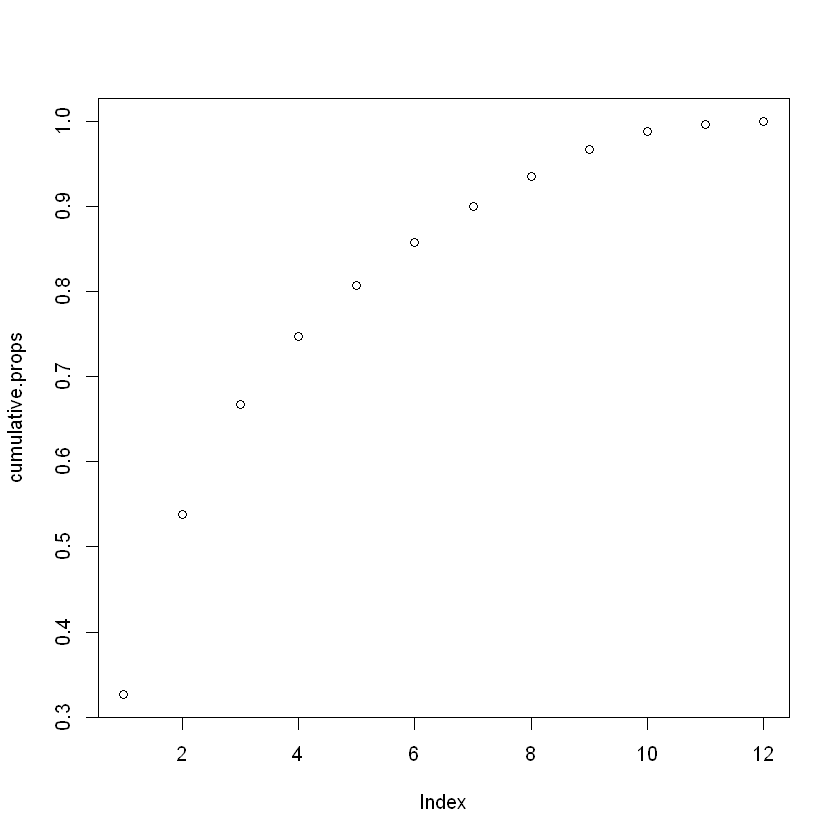

In [251]:
#### calculate the variance
vars <- (pca$sdev)^2
vars
props <- vars / sum(vars)    
props
cumulative.props <- cumsum(props)
cumulative.props
plot(cumulative.props)

In [252]:
#### we choose pc1 to pc4, can explain 74% of data
top4_pca.data <- pca$x[, 1:4]

In [253]:
pca4_data <- cbind(top4_pca.data, data2$trans.quality)
pca4_data <- data.frame(pca4_data)
head(pca4_data)

,PC1,PC2,PC3,PC4,V5
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,-3.923360,-0.2768065,2.108666,0.7702967,5
2,-3.445590,0.4806142,1.413634,0.9191997,5
3,-3.675690,0.1662319,1.188200,0.8502422,5
4,-2.589050,1.3625530,-2.496124,-0.5287916,6
5,-3.782054,-0.2388660,2.127738,0.6675579,5
6,-2.993296,-0.1071893,1.106001,1.4680486,5


In [254]:
pca$rotation[,1:4]
#### PC1 is more relate to total.sulfur.dioxide and free.sulfur.dioxide	
#### PC2 is more relate to residual.sugar and density
#### PC3 is more relate to pH
#### PC4 is negative relate to pH and sulphates

,PC1,PC2,PC3,PC4
trans.fixed.acidity,-0.25199352,0.224939090,-0.508970226,0.08702048
trans.volatile.acidity,-0.34006437,0.018621370,0.213746348,0.33646883
trans.citric.acid,0.12113316,0.190513455,-0.569087507,-0.36279421
trans.residual.sugar,0.16786683,0.420756990,0.153679543,0.12639254
trans.chlorides,-0.36212182,0.243694794,0.071381047,-0.04300608
trans.free.sulfur.dioxide,0.34223832,0.227144775,0.194075336,-0.23566702
trans.total.sulfur.dioxide,0.37613182,0.283279683,0.156727308,-0.13571008
trans.density,-0.23453969,0.521097406,0.085014124,-0.01881041
trans.pH,-0.17540329,-0.191912458,0.481533383,-0.45077474
trans.sulphates,-0.27908874,0.052852685,-0.021259314,-0.66373521


## 5. classification models 

In [255]:
## seperate the data (7:3)
#### pca
split1 <- createDataPartition(y=pca4_data$V5 ,p=0.7,list = FALSE)
train_data_pca <- pca4_data[split1,]
test_data_pca <- pca4_data[-split1,]
#### no pca
split1 <- createDataPartition(y=data2$trans.quality ,p=0.7,list = FALSE)
train_data <- data2[split1,]
test_data <- data2[-split1,]

#### c50

In [221]:
## train the model
#### no pca
c50 <- C5.0(x= train_data[-13], y= as.factor(train_data$trans.quality), trials = 10)
c50
## tree size 478.2

#### pca
c50_pca <- C5.0(x= train_data_pca[1:4], y= as.factor(train_data_pca$V5), trials = 10)
c50_pca
## tree size 47.3, much smaller than previous one


Call:
C5.0.default(x = train_data[-13], y =
 as.factor(train_data$trans.quality), trials = 10)

Classification Tree
Number of samples: 3613 
Number of predictors: 12 

Number of boosting iterations: 10 
Average tree size: 478.2 

Non-standard options: attempt to group attributes



Call:
C5.0.default(x = train_data_pca[1:4], y = as.factor(train_data_pca$V5),
 trials = 10)

Classification Tree
Number of samples: 3613 
Number of predictors: 4 

Number of boosting iterations: 10 requested;  3 used due to early stopping
Average tree size: 47.3 

Non-standard options: attempt to group attributes


In [211]:
## see how c50 seperate the data
summary(c50)
summary(c50_pca)


Call:
C5.0.default(x = train_data[1:4], y = as.factor(train_data$V5), trials = 10)


C5.0 [Release 2.07 GPL Edition]  	Sun Mar 01 19:44:17 2020
-------------------------------

Class specified by attribute `outcome'

Read 3613 cases (5 attributes) from undefined.data

-----  Trial 0:  -----

Decision tree:

PC2 <= -0.4199238:
:...PC1 > 0.8457257:
:   :...PC3 > 0.4838761:
:   :   :...PC1 > 2.053474:
:   :   :   :...PC2 <= -2.473232:
:   :   :   :   :...PC1 <= 2.21011: 6 (2/1)
:   :   :   :   :   PC1 > 2.21011: 7 (3)
:   :   :   :   PC2 > -2.473232:
:   :   :   :   :...PC3 > 1.716405: 6 (3)
:   :   :   :       PC3 <= 1.716405:
:   :   :   :       :...PC2 <= -1.578782: 8 (3)
:   :   :   :           PC2 > -1.578782:
:   :   :   :           :...PC4 <= 0.02495576: 6 (2)
:   :   :   :               PC4 > 0.02495576: 4 (2/1)
:   :   :   PC1 <= 2.053474:
:   :   :   :...PC2 > -1.897793: 6 (104/49)
:   :   :       PC2 <= -1.897793:
:   :   :       :...PC4 > 0.3048826: 6 (13/6)
:   :   :        

In [219]:
#### predict
pred <- predict(c50, test_data[-13])
#### accuracy
mean(pred == test_data$trans.quality)
CrossTable(test_data$trans.quality, pred,
           prop.chisq = FALSE,  prop.c = FALSE,
           dnn = c('actual', 'predicted'))
## accuracy = 0.51

[1] 0.5184228


 
   Cell Contents
|-------------------------|
|                       N |
|           N / Row Total |
|         N / Table Total |
|-------------------------|

 
Total Observations in Table:  1547 

 
             | predicted 
      actual |         3 |         4 |         5 |         6 |         7 |         8 | Row Total | 
-------------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|
           3 |         0 |         1 |         3 |         2 |         0 |         0 |         6 | 
             |     0.000 |     0.167 |     0.500 |     0.333 |     0.000 |     0.000 |     0.004 | 
             |     0.000 |     0.001 |     0.002 |     0.001 |     0.000 |     0.000 |           | 
-------------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|
           4 |         1 |         6 |        29 |        23 |         1 |         0 |        60 | 
             |     0.017 |     0.100 |     0.483 |     0.383 |     0.017 |

In [222]:
## pca
#### predict
pred_pca <- predict(c50_pca, test_data_pca[1:4])
#### accuracy
mean(pred_pca == test_data_pca$V5)
CrossTable(test_data_pca$V5, pred_pca,
           prop.chisq = FALSE,  prop.c = FALSE,
           dnn = c('actual', 'predicted'))

[1] 0.5481577


 
   Cell Contents
|-------------------------|
|                       N |
|           N / Row Total |
|         N / Table Total |
|-------------------------|

 
Total Observations in Table:  1547 

 
             | predicted 
      actual |      high |       low |       mid | Row Total | 
-------------|-----------|-----------|-----------|-----------|
        high |        53 |        36 |       202 |       291 | 
             |     0.182 |     0.124 |     0.694 |     0.188 | 
             |     0.034 |     0.023 |     0.131 |           | 
-------------|-----------|-----------|-----------|-----------|
         low |        13 |       384 |       181 |       578 | 
             |     0.022 |     0.664 |     0.313 |     0.374 | 
             |     0.008 |     0.248 |     0.117 |           | 
-------------|-----------|-----------|-----------|-----------|
         mid |        43 |       224 |       411 |       678 | 
             |     0.063 |     0.330 |     0.606 |     0.438 | 
       

#### naiveBayes

In [224]:
## train the model
nb_model <- naiveBayes(train_data[-13], as.factor(train_data$trans.quality))
nb_model
## pca
nb_model_pca <- naiveBayes(train_data_pca[1:4], as.factor(train_data_pca$V5))
nb_model_pca


Naive Bayes Classifier for Discrete Predictors

Call:
naiveBayes.default(x = train_data[-13], y = as.factor(train_data$trans.quality))

A-priori probabilities:
as.factor(train_data$trans.quality)
           3            4            5            6            7            8 
0.0047052311 0.0381954055 0.3304732909 0.4386936064 0.1608081926 0.0262939386 
           9 
0.0008303349 

Conditional probabilities:
                                   trans.fixed.acidity
as.factor(train_data$trans.quality)        [,1]      [,2]
                                  3  0.66569736 1.1648364
                                  4  0.11597263 0.9765930
                                  5  0.10137321 0.8982706
                                  6 -0.02505105 0.9610456
                                  7 -0.05358519 1.0169753
                                  8 -0.31328346 1.0321878
                                  9  0.38248954 0.9332217

                                   trans.volatile.acidity
as.factor(t


Naive Bayes Classifier for Discrete Predictors

Call:
naiveBayes.default(x = train_data_pca[1:4], y = as.factor(train_data_pca$V5))

A-priori probabilities:
as.factor(train_data_pca$V5)
     high       low       mid 
0.1879325 0.3733739 0.4386936 

Conditional probabilities:
                            PC1
as.factor(train_data_pca$V5)       [,1]     [,2]
                        high  0.4608667 1.818983
                        low  -0.4679632 2.033715
                        mid   0.1812591 1.939865

                            PC2
as.factor(train_data_pca$V5)        [,1]     [,2]
                        high -0.94193319 1.363570
                        low   0.57115592 1.493728
                        mid  -0.06990093 1.528469

                            PC3
as.factor(train_data_pca$V5)        [,1]     [,2]
                        high -0.31132472 1.133776
                        low   0.21700310 1.271751
                        mid  -0.04918101 1.227067

                            

In [225]:
#### predict
pred1 <- predict(nb_model, test_data[-13])

## accuracy
mean(pred1 == test_data$trans.quality)

## crosstable
CrossTable(pred1, test_data$trans.quality,
           prop.chisq = FALSE, prop.t = FALSE, prop.r = FALSE,
           dnn = c('predicted', 'actual'))

[1] 0.4421461


 
   Cell Contents
|-------------------------|
|                       N |
|           N / Col Total |
|-------------------------|

 
Total Observations in Table:  1547 

 
             | actual 
   predicted |         3 |         4 |         5 |         6 |         7 |         8 |         9 | Row Total | 
-------------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|
           3 |         0 |         0 |         5 |        15 |         3 |         0 |         0 |        23 | 
             |     0.000 |     0.000 |     0.010 |     0.022 |     0.012 |     0.000 |     0.000 |           | 
-------------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|
           4 |         1 |         5 |        14 |        15 |         2 |         1 |         0 |        38 | 
             |     0.167 |     0.083 |     0.027 |     0.022 |     0.008 |     0.021 |     0.000 |           | 
-------------|-------

In [228]:
## pca
#### predict
pred1 <- predict(nb_model_pca, test_data_pca[1:4])
## accuracy
mean(pred1 == test_data_pca$V5)

## crosstable
CrossTable(pred1, test_data_pca$V5,
           prop.chisq = FALSE, prop.t = FALSE, prop.r = FALSE,
           dnn = c('predicted', 'actual'))

[1] 0.5281189


 
   Cell Contents
|-------------------------|
|                       N |
|           N / Col Total |
|-------------------------|

 
Total Observations in Table:  1547 

 
             | actual 
   predicted |      high |       low |       mid | Row Total | 
-------------|-----------|-----------|-----------|-----------|
        high |        47 |        15 |        44 |       106 | 
             |     0.162 |     0.026 |     0.065 |           | 
-------------|-----------|-----------|-----------|-----------|
         low |        32 |       335 |       199 |       566 | 
             |     0.110 |     0.580 |     0.294 |           | 
-------------|-----------|-----------|-----------|-----------|
         mid |       212 |       228 |       435 |       875 | 
             |     0.729 |     0.394 |     0.642 |           | 
-------------|-----------|-----------|-----------|-----------|
Column Total |       291 |       578 |       678 |      1547 | 
             |     0.188 |     0.374 | 

#### Neural Networks

In [229]:
#### train the model
formula.bpn <- train_data$trans.quality ~ .
bpn1 <- neuralnet(formula = formula.bpn, 
                 data = train_data, 
                 hidden = c(10,5),
                 learningrate = 0.01,
                 threshold = 0.1
)

In [312]:
plot(bpn1)

In [230]:
## predict
predicted2 <- predict(bpn1, test_data[,-13],type="class")
predicted2 <- round(predicted2)
## accuracy
mean(predicted2 == test_data$trans.quality)
## CrossTable
CrossTable(test_data$trans.quality, predicted2,
           prop.chisq = FALSE,  prop.c = FALSE,
           dnn = c('actual', 'predicted'))

[1] 0.5294118


 
   Cell Contents
|-------------------------|
|                       N |
|           N / Row Total |
|         N / Table Total |
|-------------------------|

 
Total Observations in Table:  1547 

 
             | predicted 
      actual |         3 |         4 |         5 |         6 |         7 |         8 | Row Total | 
-------------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|
           3 |         0 |         1 |         3 |         2 |         0 |         0 |         6 | 
             |     0.000 |     0.167 |     0.500 |     0.333 |     0.000 |     0.000 |     0.004 | 
             |     0.000 |     0.001 |     0.002 |     0.001 |     0.000 |     0.000 |           | 
-------------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|
           4 |         0 |         7 |        33 |        20 |         0 |         0 |        60 | 
             |     0.000 |     0.117 |     0.550 |     0.333 |     0.000 |

#### SVM

In [256]:
## train
svm_model = svm(train_data[-13], as.factor(train_data$trans.quality))
summary(svm_model)
##pca
svm_model_pca = svm(train_data_pca[1:4], as.factor(train_data_pca$V5))
summary(svm_model_pca)


Call:
svm.default(x = train_data[-13], y = as.factor(train_data$trans.quality))


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  radial 
       cost:  1 

Number of Support Vectors:  3168

 ( 970 1377 567 143 95 13 3 )


Number of Classes:  7 

Levels: 
 3 4 5 6 7 8 9





Call:
svm.default(x = train_data_pca[1:4], y = as.factor(train_data_pca$V5))


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  radial 
       cost:  1 

Number of Support Vectors:  3294

 ( 1045 578 146 1406 97 18 4 )


Number of Classes:  7 

Levels: 
 3 4 5 6 7 8 9




In [261]:
## predict
svm_pred = predict(svm_model, test_data[-13])
## accuracy
mean(svm_pred == test_data$trans.quality)
## crosstable
CrossTable(svm_pred, test_data$trans.quality,
           prop.chisq = FALSE, prop.t = FALSE, prop.r = FALSE,
           dnn = c('predicted', 'actual'))

[1] 0.5332902


 
   Cell Contents
|-------------------------|
|                       N |
|           N / Col Total |
|-------------------------|

 
Total Observations in Table:  1547 

 
             | actual 
   predicted |         3 |         4 |         5 |         6 |         7 |         8 |         9 | Row Total | 
-------------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|
           5 |         7 |        39 |       293 |       149 |         9 |         0 |         0 |       497 | 
             |     0.700 |     0.709 |     0.571 |     0.220 |     0.037 |     0.000 |     0.000 |           | 
-------------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|
           6 |         3 |        14 |       217 |       479 |       181 |        31 |         1 |       926 | 
             |     0.300 |     0.255 |     0.423 |     0.706 |     0.745 |     0.660 |     1.000 |           | 
-------------|-------

In [262]:
## pca
## predict
svm_pred = predict(svm_model_pca, test_data_pca[,-5])
## accuracy
mean(svm_pred == test_data_pca[,5])
## crosstable
CrossTable(svm_pred, test_data_pca[,5],
           prop.chisq = FALSE, prop.t = FALSE, prop.r = FALSE,
           dnn = c('predicted', 'actual'))

[1] 0.5216548


 
   Cell Contents
|-------------------------|
|                       N |
|           N / Col Total |
|-------------------------|

 
Total Observations in Table:  1547 

 
             | actual 
   predicted |         3 |         4 |         5 |         6 |         7 |         8 | Row Total | 
-------------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|
           5 |         3 |        32 |       264 |       135 |        11 |         0 |       445 | 
             |     0.600 |     0.615 |     0.507 |     0.199 |     0.045 |     0.000 |           | 
-------------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|
           6 |         2 |        20 |       257 |       543 |       235 |        45 |      1102 | 
             |     0.400 |     0.385 |     0.493 |     0.801 |     0.955 |     1.000 |           | 
-------------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|
Column

## 6. Ensemble classifier 

#### randomforest

In [263]:
## train
randomforest <- randomForest(
  formula = train_data$trans.quality ~ .,
  data    = train_data
)
## pca
randomforest_pca <- randomForest(
  formula = train_data_pca$V5 ~ .,
  data    = train_data_pca
)


Call:
 randomForest(formula = train_data$trans.quality ~ ., data = train_data) 
               Type of random forest: regression
                     Number of trees: 500
No. of variables tried at each split: 4

          Mean of squared residuals: 0.4489818
                    % Var explained: 40.35


Call:
 randomForest(formula = train_data_pca$V5 ~ ., data = train_data_pca) 
               Type of random forest: regression
                     Number of trees: 500
No. of variables tried at each split: 1

          Mean of squared residuals: 0.5596655
                    % Var explained: 27.23

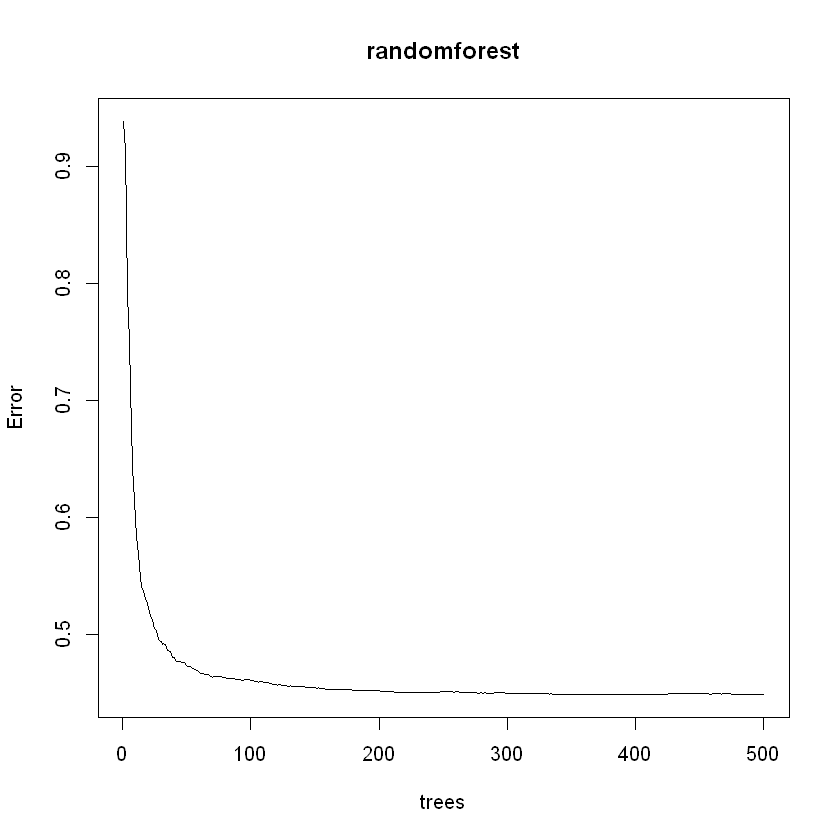

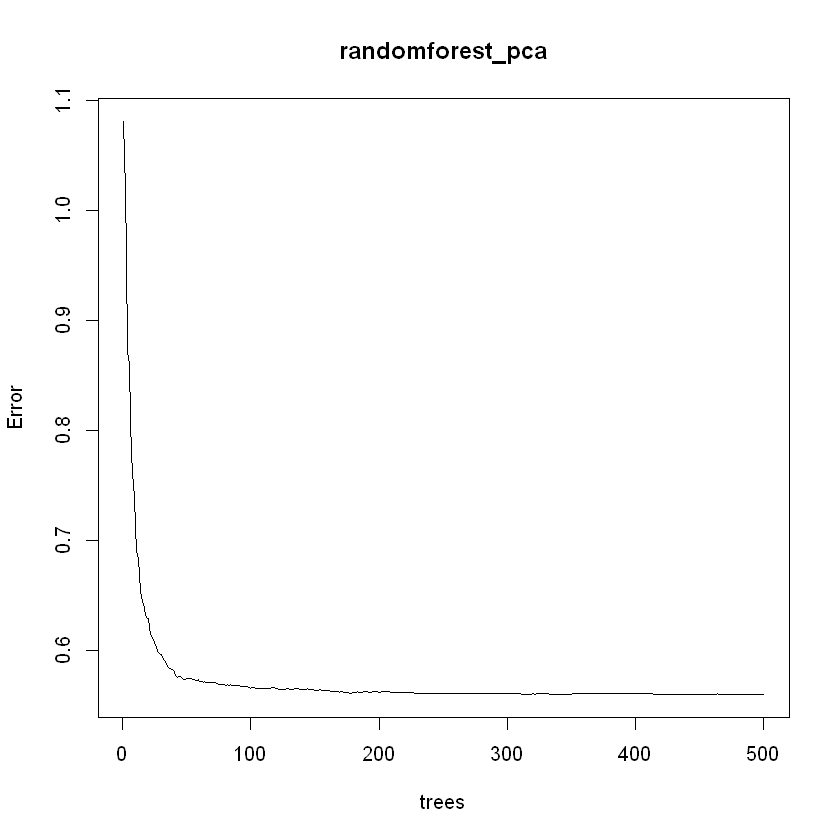

In [264]:
## observe the model
randomforest
plot(randomforest)
## pca
randomforest_pca
plot(randomforest_pca)

In [265]:
## predict
pred_randomForest <- predict(randomforest, test_data)
pred_randomForest <- round(pred_randomForest)
## accuracy
mean(pred_randomForest == test_data$trans.quality)
## no pca 0.575953458306399
## crosstable
CrossTable(pred_randomForest, test_data$trans.quality,
           prop.chisq = FALSE, prop.t = FALSE, prop.r = FALSE,
           dnn = c('predicted', 'actual'))

[1] 0.5507434


 
   Cell Contents
|-------------------------|
|                       N |
|           N / Col Total |
|-------------------------|

 
Total Observations in Table:  1547 

 
             | actual 
   predicted |         3 |         4 |         5 |         6 |         7 |         8 |         9 | Row Total | 
-------------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|
           5 |         8 |        43 |       298 |       139 |        10 |         0 |         0 |       498 | 
             |     0.800 |     0.782 |     0.581 |     0.205 |     0.041 |     0.000 |     0.000 |           | 
-------------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|
           6 |         2 |        10 |       211 |       478 |       157 |        23 |         0 |       881 | 
             |     0.200 |     0.182 |     0.411 |     0.705 |     0.646 |     0.489 |     0.000 |           | 
-------------|-------

In [266]:
## pca
## predict
pred_randomForest <- predict(randomforest_pca, test_data_pca)
pred_randomForest <- round(pred_randomForest)
## accuracy
mean(pred_randomForest == test_data_pca$V5)
## no pca 0.575953458306399
## crosstable
CrossTable(pred_randomForest, test_data_pca$V5,
           prop.chisq = FALSE, prop.t = FALSE, prop.r = FALSE,
           dnn = c('predicted', 'actual'))

[1] 0.5171299


 
   Cell Contents
|-------------------------|
|                       N |
|           N / Col Total |
|-------------------------|

 
Total Observations in Table:  1547 

 
             | actual 
   predicted |         3 |         4 |         5 |         6 |         7 |         8 | Row Total | 
-------------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|
           4 |         0 |         0 |         1 |         0 |         0 |         0 |         1 | 
             |     0.000 |     0.000 |     0.002 |     0.000 |     0.000 |     0.000 |           | 
-------------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|
           5 |         3 |        34 |       261 |       137 |         8 |         0 |       443 | 
             |     0.600 |     0.654 |     0.501 |     0.202 |     0.033 |     0.000 |           | 
-------------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|
      

In [268]:
## see the importance of each factor we use
importance(randomforest)
importance(randomforest_pca)

,IncNodePurity
trans.fixed.acidity,147.10257
trans.volatile.acidity,274.65877
trans.citric.acid,178.05532
trans.residual.sugar,179.46090
trans.chlorides,200.29057
trans.free.sulfur.dioxide,227.36977
trans.total.sulfur.dioxide,193.43944
trans.density,263.13681
trans.pH,174.86807
trans.sulphates,190.06630


,IncNodePurity
PC1,631.2502
PC2,715.8740
PC3,545.3597
PC4,602.7703


#### Xgboost

In [289]:
#### change it to matrix to fit the xgboost
traindata <- as.matrix(train_data)
#### train
xgb2 <- xgboost(data = traindata[,-13], label = traindata[,13],
max_depth = 10, eta = 0.2, nthread = 5, nrounds = 20) 

[1]	train-rmse:4.317334 
[2]	train-rmse:3.482766 
[3]	train-rmse:2.819795 
[4]	train-rmse:2.293496 
[5]	train-rmse:1.877505 
[6]	train-rmse:1.547790 
[7]	train-rmse:1.285697 
[8]	train-rmse:1.078936 
[9]	train-rmse:0.913000 
[10]	train-rmse:0.780561 
[11]	train-rmse:0.677401 
[12]	train-rmse:0.593805 
[13]	train-rmse:0.527516 
[14]	train-rmse:0.476057 
[15]	train-rmse:0.430564 
[16]	train-rmse:0.393611 
[17]	train-rmse:0.367753 
[18]	train-rmse:0.348362 
[19]	train-rmse:0.333450 
[20]	train-rmse:0.321428 


In [308]:
## pca
traindata_pca <- as.matrix(train_data_pca)
#### train
xgb2_pca <- xgboost(data = traindata_pca[,-5], label = traindata_pca[,5],
max_depth = 12, eta = 0.3, nthread = 2, nrounds = 25) 

[1]	train-rmse:3.799752 
[2]	train-rmse:2.716890 
[3]	train-rmse:1.973667 
[4]	train-rmse:1.467357 
[5]	train-rmse:1.123090 
[6]	train-rmse:0.886101 
[7]	train-rmse:0.727360 
[8]	train-rmse:0.614705 
[9]	train-rmse:0.543623 
[10]	train-rmse:0.490432 
[11]	train-rmse:0.459537 
[12]	train-rmse:0.437508 
[13]	train-rmse:0.413623 
[14]	train-rmse:0.398365 
[15]	train-rmse:0.389626 
[16]	train-rmse:0.383494 
[17]	train-rmse:0.358813 
[18]	train-rmse:0.339536 
[19]	train-rmse:0.332834 
[20]	train-rmse:0.329700 
[21]	train-rmse:0.321252 
[22]	train-rmse:0.318910 
[23]	train-rmse:0.317073 
[24]	train-rmse:0.309871 
[25]	train-rmse:0.303348 


In [272]:
#### change it to matrix to fit the xgboost
testdata <- as.matrix(test_data)
#### predict
xgb_pred1 <- predict(xgb2, testdata[,-13])
xgb_pred1  <- round(xgb_pred1)
## accuracy
mean(xgb_pred1  == test_data[13])
## crosstable
CrossTable(xgb_pred1, test_data$trans.quality,
           prop.chisq = FALSE, prop.t = FALSE, prop.r = FALSE,
           dnn = c('predicted', 'actual'))

[1] 0.5358759


 
   Cell Contents
|-------------------------|
|                       N |
|           N / Col Total |
|-------------------------|

 
Total Observations in Table:  1547 

 
             | actual 
   predicted |         3 |         4 |         5 |         6 |         7 |         8 |         9 | Row Total | 
-------------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|
           4 |         1 |         9 |         7 |         1 |         0 |         0 |         0 |        18 | 
             |     0.100 |     0.164 |     0.014 |     0.001 |     0.000 |     0.000 |     0.000 |           | 
-------------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|
           5 |         7 |        36 |       336 |       199 |        22 |         1 |         0 |       601 | 
             |     0.700 |     0.655 |     0.655 |     0.294 |     0.091 |     0.021 |     0.000 |           | 
-------------|-------

In [309]:
## pca
#### change it to matrix to fit the xgboost
testdata_pca <- as.matrix(test_data_pca)
#### predict
xgb_pred1 <- predict(xgb2_pca, testdata_pca[,-5])
xgb_pred1  <- round(xgb_pred1)
## accuracy
mean(xgb_pred1  == test_data_pca$V5)
## crosstable
CrossTable(xgb_pred1, test_data_pca$V5,
           prop.chisq = FALSE, prop.t = FALSE, prop.r = FALSE,
           dnn = c('predicted', 'actual'))

[1] 0.490627


 
   Cell Contents
|-------------------------|
|                       N |
|           N / Col Total |
|-------------------------|

 
Total Observations in Table:  1547 

 
             | actual 
   predicted |         3 |         4 |         5 |         6 |         7 |         8 | Row Total | 
-------------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|
           3 |         0 |         0 |         1 |         0 |         0 |         0 |         1 | 
             |     0.000 |     0.000 |     0.002 |     0.000 |     0.000 |     0.000 |           | 
-------------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|
           4 |         0 |         5 |         8 |         7 |         0 |         0 |        20 | 
             |     0.000 |     0.096 |     0.015 |     0.010 |     0.000 |     0.000 |           | 
-------------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|
      

## 7. imbalanced data
#### After use PCA, the accuracy is still not well
#### Try to deal with imbalanced data and see if the accracy can be better

In [101]:
#### see the percentage in each quality
prop.table(table(pca4_data$V5))


           3            4            5            6            7            8 
0.0044573643 0.0383720930 0.3306201550 0.4385658915 0.1596899225 0.0275193798 
           9 
0.0007751938 

#### upsample

In [102]:
set.seed(8)
up_train <- upSample(x = pca4_data[1:4],
                     y = as.factor(pca4_data$V5))                         
table(up_train$Class)


   3    4    5    6    7    8    9 
2263 2263 2263 2263 2263 2263 2263 

#### use C50 and randomforest to see if the accuracy get better

In [103]:
## seperate the data (7:3)
split1 <- createDataPartition(y=up_train$Class ,p=0.7,list = FALSE)
uptrain_data <- up_train[split1,]
uptest_data <- up_train[-split1,]

#### c50

In [110]:
## train the model
c50_up <- C5.0(x= uptrain_data[1:4], y= uptrain_data$Class, trials = 8)  #,costs = error_cost,trials = 6
c50_up


Call:
C5.0.default(x = uptrain_data[1:4], y = uptrain_data$Class, trials = 8)

Classification Tree
Number of samples: 11095 
Number of predictors: 4 

Number of boosting iterations: 8 
Average tree size: 778.4 

Non-standard options: attempt to group attributes


In [113]:
#### predict
ip_pred_c50 <- predict(c50_up, uptest_data[1:4])
#### accuracy
mean(ip_pred_c50 == uptest_data$Class)
CrossTable(uptest_data$Class, ip_pred_c50,
           prop.chisq = FALSE,  prop.c = FALSE,
           dnn = c('actual', 'predicted'))

[1] 0.8592499


 
   Cell Contents
|-------------------------|
|                       N |
|           N / Row Total |
|         N / Table Total |
|-------------------------|

 
Total Observations in Table:  4746 

 
             | predicted 
      actual |         3 |         4 |         5 |         6 |         7 |         8 |         9 | Row Total | 
-------------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|
           3 |       678 |         0 |         0 |         0 |         0 |         0 |         0 |       678 | 
             |     1.000 |     0.000 |     0.000 |     0.000 |     0.000 |     0.000 |     0.000 |     0.143 | 
             |     0.143 |     0.000 |     0.000 |     0.000 |     0.000 |     0.000 |     0.000 |           | 
-------------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|
           4 |         0 |       678 |         0 |         0 |         0 |         0 |         0 |    

####  random forest

In [105]:
## train
randomforest_up <- randomForest(
  formula = Class ~ .,
  data    = uptrain_data
)


Call:
 randomForest(formula = Class ~ ., data = uptrain_data) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 2

        OOB estimate of  error rate: 13.2%
Confusion matrix:
     3    4    5   6    7    8    9  class.error
3 1585    0    0   0    0    0    0 0.0000000000
4    0 1584    0   1    0    0    0 0.0006309148
5    3   47 1124 344   62    5    0 0.2908517350
6    1   31  430 742  354   26    1 0.5318611987
7    0    2   26 123 1426    8    0 0.1003154574
8    0    0    0   0    0 1585    0 0.0000000000
9    0    0    0   0    0    0 1585 0.0000000000

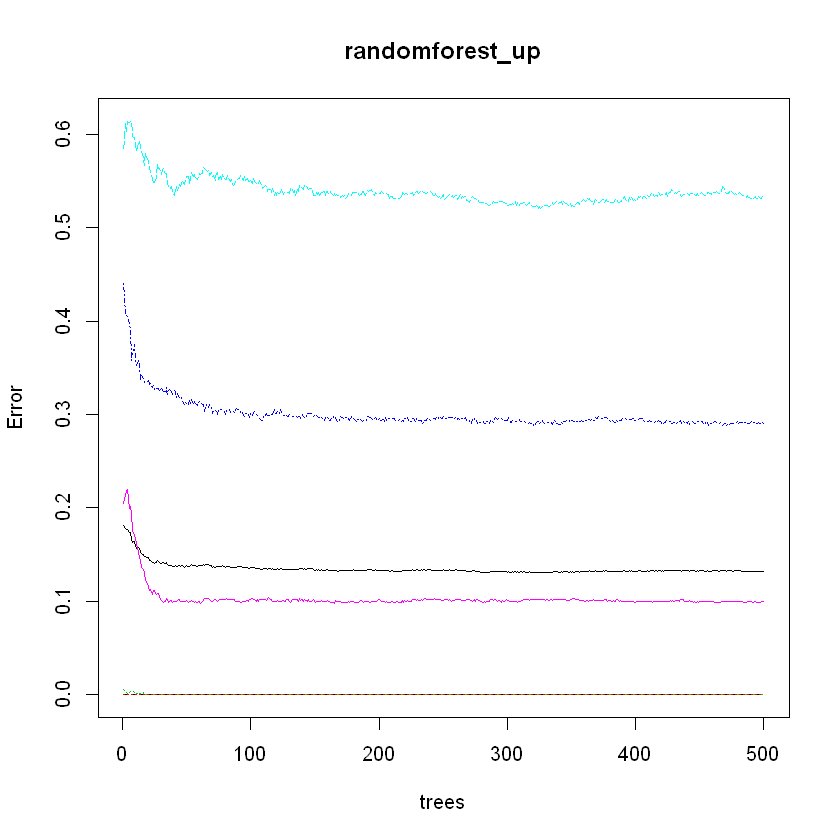

In [106]:
## observe the model
randomforest_up
plot(randomforest_up)

In [107]:
## predict
pred_randomForest_up <- predict(randomforest_up, uptest_data)
## accuracy
mean(pred_randomForest_up == uptest_data$Class)
## no pca 0.575953458306399
## crosstable
CrossTable(pred_randomForest_up, uptest_data$Class,
           prop.chisq = FALSE, prop.t = FALSE, prop.r = FALSE,
           dnn = c('predicted', 'actual'))

[1] 0.8659924


 
   Cell Contents
|-------------------------|
|                       N |
|           N / Col Total |
|-------------------------|

 
Total Observations in Table:  4746 

 
             | actual 
   predicted |         3 |         4 |         5 |         6 |         7 |         8 |         9 | Row Total | 
-------------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|
           3 |       678 |         0 |         1 |         1 |         0 |         0 |         0 |       680 | 
             |     1.000 |     0.000 |     0.001 |     0.001 |     0.000 |     0.000 |     0.000 |           | 
-------------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|
           4 |         0 |       678 |        20 |        17 |         0 |         0 |         0 |       715 | 
             |     0.000 |     1.000 |     0.029 |     0.025 |     0.000 |     0.000 |     0.000 |           | 
-------------|-------

#### the accuracy increase to 85%, but it's not true, since upsample will replicate the data, so there are a lot of same data 

#### K-fold Cross-Validation

In [ ]:
train_control <- trainControl(method="cv", number=10)
train_control.model <- train(Class ~ ., data= uptrain_data
                             , method="cforest", trControl=train_control)
train_control.model

#### Combine the quality

In [274]:
## (3, 4, 5) as low, 6 as mid, and (7, 8 ,9) as high
data2$trans.quality[data2$trans.quality == 3 | data2$trans.quality == 4 | data2$trans.quality == 5] <- "low"
data2$trans.quality[data2$trans.quality == 6] <- "mid"
data2$trans.quality[data2$trans.quality == 7 | data2$trans.quality == 8 | data2$trans.quality == 9] <- "high"
table(data2$trans.quality)


high  low  mid 
 970 1927 2263 

In [275]:
## seperate the data (7:3)
split1 <- createDataPartition(y=data2$trans.quality ,p=0.7,list = FALSE)
class_train_data <- data2[split1,]
class_test_data <- data2[-split1,]

In [277]:
## train the c50 model
c50_class <- C5.0(x= class_train_data[-13], y= as.factor(class_train_data$trans.quality), trials = 8)
c50_class


Call:
C5.0.default(x = class_train_data[-13], y
 = as.factor(class_train_data$trans.quality), trials = 8)

Classification Tree
Number of samples: 3613 
Number of predictors: 12 

Number of boosting iterations: 8 
Average tree size: 111.6 

Non-standard options: attempt to group attributes


In [279]:
#### predict
class_pred_c50 <- predict(c50_class, class_test_data[-13])
#### accuracy
mean(class_pred_c50 == class_test_data$trans.quality)
CrossTable(class_test_data$trans.quality, class_pred_c50,
           prop.chisq = FALSE,  prop.c = FALSE,
           dnn = c('actual', 'predicted'))

[1] 0.5850032


 
   Cell Contents
|-------------------------|
|                       N |
|           N / Row Total |
|         N / Table Total |
|-------------------------|

 
Total Observations in Table:  1547 

 
             | predicted 
      actual |      high |       low |       mid | Row Total | 
-------------|-----------|-----------|-----------|-----------|
        high |       110 |        26 |       155 |       291 | 
             |     0.378 |     0.089 |     0.533 |     0.188 | 
             |     0.071 |     0.017 |     0.100 |           | 
-------------|-----------|-----------|-----------|-----------|
         low |         4 |       395 |       179 |       578 | 
             |     0.007 |     0.683 |     0.310 |     0.374 | 
             |     0.003 |     0.255 |     0.116 |           | 
-------------|-----------|-----------|-----------|-----------|
         mid |        79 |       199 |       400 |       678 | 
             |     0.117 |     0.294 |     0.590 |     0.438 | 
       

In [285]:
## train the randomForest model
class_train_data$trans.quality <- as.factor(class_train_data$trans.quality)
randomforest_up <- randomForest(
  formula = trans.quality ~ .,
  data    = class_train_data
)


Call:
 randomForest(formula = trans.quality ~ ., data = class_train_data) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 3

        OOB estimate of  error rate: 38.2%
Confusion matrix:
     high low  mid class.error
high  301  29  349   0.5567010
low    17 899  433   0.3335804
mid   160 392 1033   0.3482650

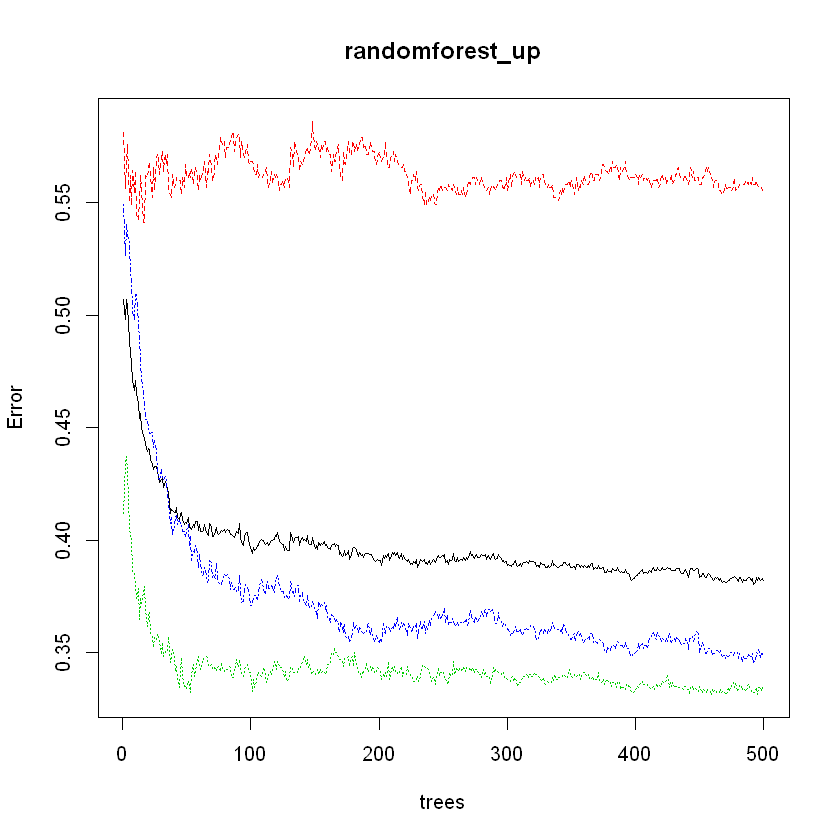

In [286]:
## observe the model
randomforest_up
plot(randomforest_up)

In [287]:
## predict
pred_randomForest_up <- predict(randomforest_up, class_test_data)
## accuracy
mean(pred_randomForest_up == class_test_data$trans.quality)
## crosstable
CrossTable(pred_randomForest_up, class_test_data$trans.quality,
           prop.chisq = FALSE, prop.t = FALSE, prop.r = FALSE,
           dnn = c('predicted', 'actual'))

[1] 0.6302521


 
   Cell Contents
|-------------------------|
|                       N |
|           N / Col Total |
|-------------------------|

 
Total Observations in Table:  1547 

 
             | actual 
   predicted |      high |       low |       mid | Row Total | 
-------------|-----------|-----------|-----------|-----------|
        high |       118 |         3 |        73 |       194 | 
             |     0.405 |     0.005 |     0.108 |           | 
-------------|-----------|-----------|-----------|-----------|
         low |        15 |       409 |       157 |       581 | 
             |     0.052 |     0.708 |     0.232 |           | 
-------------|-----------|-----------|-----------|-----------|
         mid |       158 |       166 |       448 |       772 | 
             |     0.543 |     0.287 |     0.661 |           | 
-------------|-----------|-----------|-----------|-----------|
Column Total |       291 |       578 |       678 |      1547 | 
             |     0.188 |     0.374 | 

## Model Summary

|  Model   | Accuracy  |
|  ----  | ----  |
| c50  | 0.51 |
| c50(pca)  | 0.548 |
| naiveBayes  | 0.442 |
| naiveBayes(pca)  | 0.528 |
| Neural Network  | 0.529 |
| SVM  | 0.533 |
| SVM(pca)  | 0.521 |
| RandomForest  | 0.55 |
| RandomForest(pca)  | 0.517 |
| Xgboost  | 0.535 |
| Xgboost(pca)  | 0.49 |
| c50(upsample)  | 0.859 |
| RandomForest(pca)  | 0.865 | 
| c50(Combine into 3 class)  | 0.585 |
| RandomForest(Combine into 3 class)   | 0.63 |

## Conclusion

#### This data have 7 class and the data in each class are simlair
#### And the distribution of data is extremely imbalance
#### These make it hard to classify compare to the homeworks we did in the class
#### First, I didn't do PCA, and I did't address the imbalance data
#### The accuracy for c50 naiveBayes Neural Networks SVM are all low, 40%~50%
#### Although this accuracy seems not well, it have 7 class, so better than random guessing a lot (1/7)
#### Later, I perform PCA to reduce the dimension
#### The accuracy for some model increase a little, some are lower
#### But PCA let the model become harder to explain, since all the factor combine together
#### The last step is address the imbalance data
#### I use upsample, the accuracy increase a lot, but it's not meaningful
#### Since upsample just replicate the less class, therefore, there will be a lot of same data
#### The value for each quality difference too much, the 9 only have 5, 3 have 30, the max is 6 have 2323
#### Whether use upsample or downsample is not appropriate
#### So, I combine (3, 4, 5) as low, 6 as mid, and (7, 8 ,9) as high
#### In such way, the number of each class are closer than original data
#### The accuracy increase a little ,but still not well
#### What important the most is still the raw data

In [288]:
pkgs = c("base")
r_version = paste("R", getRversion())
pkg_version = c()
for (package_name in pkgs) {
    pkg_version = c(pkg_version, 
                    paste(package_name,packageVersion(package_name)))
}
c(r_version, pkg_version)

[1] "R 3.6.1"    "base 3.6.1"